In [1]:
""" Clean up plot_coldeurasia_ts.py
    Oct. 27 2015
    
"""
import cccmaplots as cplt
import cccmaNC as cnc
import cccmautils as cutl
import constants as con
import cccmacmaps as ccm
import platform as platform
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import numpy.ma as ma


%matplotlib inline

con=reload(con)


# SET UP DATA
#timesel='1979-01-01,2015-07-01'
timesel='1979-01-01,2014-12-31'

obspath= '/HOME/rkm/work/DATA/'
obspath2 = '/HOME/rkm/work/BCs/'

graveraint= 9.80665 # m/s2 (different from Canadian models)

regions = {'EUR': 'eurasiamori',
           'BKS': 'bksmori',
           'GM': 'gm',
           'NH': 'nh',
           'EPAC': 'etroppac'}


# MOVED KUG STUFF TO NEW NOTEBOOK 2/19/2016 plot_coldeurasia_ts_rebuttal

regionskug = {'EUR': 'eurasiakug',
           'BKS': 'bkskug',
           'CHUCK': 'chuckkug',
           'NA':'nthamkug'}

fnames={'sat': obspath + 'GISS/gistemp1200_ERSSTv4.nc',
           'sat2': obspath + 'ERAINT/td_era_int_197901_201507_gp_128_64_st_1979011612-2015071612.nc',
           'z500': obspath + 'ERAINT/td_era_int_197901_201507_gp_128_64_phi500_1979011612-2015071612.nc',
           'sic': obspath2 + 'NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc',
           'slp': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_pmsl.001_1979011612-2015121612.nc' }

# Use long reanalyses to compute Z500 / SAT correlation
regionslong={'EUR': 'eurasiamori',
             'BKS': 'bksmori',
             'GM': 'gm',
              'NH': 'nh'}
fnameslong={'sat': obspath + '20CR/air950.mon.mean.nc',
            'z500': obspath + '20CR/hgt500.mon.mean.nc'} # try air temp at 1000 hPa or 950 hPa?@@
timesellong='1900-01-01,2012-12-31'
fieldslong={'sat':'air',
           'z500': 'hgt'}


# reproduce Kug et al. 2015 analysis 2/17/2016
fnameskug={'sat': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_st.001_1979011612-2015121612.nc',
           'z500': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_phi500.001_1979011612-2015121612.nc',
           'z300': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_phi300.nc',
           'slp': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_pmsl.001_1979011612-2015121612.nc'}
fnamesdaykug ={'sat': obspath + 'ERAINT/td_era_int_197901_latest_dp_128_64_st.nc'}


fieldskug={'sat': 'ST',
           'z500': 'PHI',
           'z300': 'PHI',
           'slp': 'PMSL'}
convskug = {'sat': 1,
         'z500': 1/graveraint,
         'z300': 1/graveraint,
         'slp': 1 }

fields={'sat': 'tempanomaly',
        'sat2': 'ST',
        'z500': 'PHI',
        'sic': 'SICN',
        'slp': 'PMSL'}
convs = {'sat': 100, # GISStemp needs *100 b/c scale_factor is not working anymore in reading NC file. @@@
         'sat2': 1,
         'z500': 1/graveraint,
         'sic': 100,
         'slp': 1 }


In [2]:

def runmean(input, window=5,axis=0) :
    ret = np.cumsum(input, dtype=float,axis=axis)
    ret[window:,...] = ret[window:,...] - ret[:-window,...]
    return ret[window - 1:,...] / np.float(window)

def selectmonths(input,start=0, incr=3, weights=(0.34444444,0.34444444,0.31111111),
                 retavg=False):
    """ choose selected months but repeat until end of time dim (assume axis=0!!)
        This is for a monthly average dataset!
        
            retavg: a flag to specify whether the average of the chosen months
                    should be returned instead of the individual months
                    For example, if True, if selected months are D,J,F then 
                       timeseries of DJF means will be returned instead of D,J,F repeating
            weights are for D,J,F average into DJF seasonal mean
            
            returns either array of D,J,F OR array of DJF mean
            
    """
    nt = input.shape[0]
    #nyrs = nt/12
    # note that start is a zero-based index, whereas nt is a value starting at 1.
    rem = np.mod((nt-start),12)
    nyrs = (nt-start)/12
    print 'start,nyrs,remainder ' + str(start),str(nyrs),str(rem)
    if rem>=incr:
        nyrs=nyrs+1
        
    print 'nyrs ' + str(nyrs)
    
    ntout = nyrs*incr # leave off trailing months if they exist. @@@ works only if first idx is 0??
    
    #print type(input[0])
    
    if input.ndim>1:
        otherdims=input.shape[1:]
    else:
        #print 'selectmonths() on 1-D not tested @@@@'
        otherdims=()
        #return -1
    
    if 'datetime' in str(type(input[0])) :
        ret=[]
    else:
        if retavg:
            ret = np.zeros((nyrs,)+otherdims)
        else:
            ret = np.zeros((ntout,)+otherdims) #input.shape[1],input.shape[2]))

        print 'ret.shape ' + str(ret.shape)
    print 'nyrs ' + str(nyrs) + ', and ' + str(ntout/incr)
    
    for yridx in range(0,nyrs):
        subsamp = range(start+yridx*12,start+yridx*12+incr)
        #print yridx, subsamp # @@@
        if retavg:
            ret[yridx,...] = np.average(input[subsamp,...],weights=np.array(weights),axis=0)
        else:
            if 'datetime' in str(type(input[0])): # hack to check dates that are selected               
                ret[yridx*incr:yridx*incr+incr] = input[subsamp]
                
            else: # hack to check dates that are selected
                
                ret[yridx*incr:yridx*incr+incr,...] = input[subsamp,...]  
        
        #print 'input[subsamp,...].shape ' + str(input[subsamp,...].shape)

    return ret

def rem_monmean(input,incr=3):
    """
          Should handle 1D or >1D. Time must be first dimension!
          
          removes the climatological monthly mean from a timeseries that
              does not include all months. 
              
              incr: number of months per year in the timeseries
                    e.g. could be Dec_yr1,Jan_yr1,Feb_yr1,Dec_yr2,Jan_yr2,Feb_yr2 
                         so incr=3
                         
              returns a tuple: timeseries w/ climo removed, the tiled climo that was removed      
    """
    ntime = input.shape[0]
    nyr = ntime/incr
    print 'nyr ' + str(nyr)
    
    if input.ndim>1:
        otherdims=input.shape[1:]
        oshape = tuple(np.ones(len(otherdims)))
        tshape = (nyr,)+oshape # tile shape
        remclimo = np.zeros((incr,)+otherdims) # climatology to remove
        print 'remclimo.shape ' + str(remclimo.shape)
    else:
        tshape = (nyr,) # tile shape
        remclimo = np.zeros((incr)) # climatology to remove
        print 'remclimo.shape ' + str(remclimo.shape)
        
    # average each month separately
    for midx in range(0,incr):
        #print midx
        #print 'removing ' + str(np.mean(input[midx::incr,...],axis=0))
        remclimo[midx,...] = np.mean(input[midx::incr,...],axis=0)
        
    
    remclimot=np.tile(remclimo,tshape) # tile the climo for number of years
    print 'remclimot.shape ' + str(remclimot.shape)
    
    
    inrem = input - remclimot
    
    return inrem,remclimot

def detrend_monthly(input,incr=3):
    """
          Should handle 1D or >1D. Time must be first dimension!
          
          detrends on a monthly basis, when input is a timeseries that
              does not include all months. (It could, haven't tried)
              
              incr: number of months per year in the timeseries
                    e.g. could be Dec_yr1,Jan_yr1,Feb_yr1,Dec_yr2,Jan_yr2,Feb_yr2 
                         so incr=3
                         
              returns: detrended timeseries w/ shape the same as input
    """
    
    ntime = input.shape[0]
    nyr = ntime/incr
    print 'nyr ' + str(nyr)
    
    if input.ndim>1:
        otherdims=input.shape[1:]
        retdtr = np.zeros((ntime,)+otherdims) # detrended data
        print 'retdtr.shape ' + str(retdtr.shape)
    else:
        retdtr = np.zeros((ntime)) # detrended data
        #print 'retdtr.shape ' + str(retdtr.shape)
        
    # average each month separately
    for midx in range(0,incr):
        #print midx
        #print 'detrending ' + str(np.mean(input[midx::incr,...],axis=0))
        retdtr[midx::incr,...] = cutl.detrend(input[midx::incr,...],axis=0)
        #@@input[midx::incr,...] = cutl.detrend(input[midx::incr,...],axis=0)
        
    return retdtr

# calculate regressions w/ space
def corrmap(inr,insp,dims):
    """   
          inr is 1D [time or numens]
          insp is 2D [time or numens x space.flat]
          dims are a tuple of dims to reshape space to (nlat,nlon) 

          returns slopemap,corrmap,pvalmap [dims]           
    """ 
    #print inr.shape, insp.shape
    
    mm,bb,rval,pval = cutl.regress(inr,insp)
    #slope,intercept = np.polyfit(inr,insp, 1)
    corrmap = rval.reshape(dims)
    pvmap = pval.reshape(dims)
    slopemap = mm.reshape(dims)
    
    return slopemap,corrmap,pvmap


In [3]:
# LOAD DATA
sea='DJF'

flddt={}; fldregdt={}; latdt={}; londt={}; xxdt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas=sea)*conv 
    latdt[fkey] = cnc.getNCvar(fname,'lat')
    londt[fkey] = cnc.getNCvar(fname,'lon')

    flddt[fkey] = fld

    regdt={}
    for regkey in regions.keys():
        print regkey
        regdt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                          regions[regkey],model=None,alsomask=alsomask)

    xxdt[fkey] = np.arange(0,len(regdt[regkey])) # length of last reg good for all reg in field
    fldregdt[fkey] = regdt

# load 3D SAT for obs:
fldspdt={}
fldspdt['sat'] = cnc.getNCvar(fname,fields['sat'],timesel=timesel,seas=sea)*conv 

    
# DO ANN too
fldanndt={}; fldannregdt={}; xxanndt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas='ANN')*conv 

    fldanndt[fkey] = fld

    reganndt={}
    for regkey in regions.keys():
        reganndt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                             regions[regkey],model=None,alsomask=alsomask)

    xxanndt[fkey] = np.arange(0,len(reganndt[regkey])) # length of last reg good for all reg in field
    fldannregdt[fkey] = reganndt

    
# and JJA
fldjjadt={}; fldjjaregdt={}; xxjjadt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas='JJA')*conv 

    fldjjadt[fkey] = fld

    regjjadt={}
    for regkey in regions.keys():
        regjjadt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                             regions[regkey],model=None,alsomask=alsomask)

    xxjjadt[fkey] = np.arange(0,len(regjjadt[regkey])) # length of last reg good for all reg in field
    fldjjaregdt[fkey] = regjjadt
    
# and SON
fldsondt={}; fldsonregdt={}; xxsondt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas='SON')*conv 

    fldsondt[fkey] = fld

    regsondt={}
    for regkey in regions.keys():
        regsondt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                             regions[regkey],model=None,alsomask=alsomask)

    xxsondt[fkey] = np.arange(0,len(regsondt[regkey])) # length of last reg good for all reg in field
    fldsonregdt[fkey] = regsondt


/HOME/rkm/work/BCs/NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc SICN 100
lat: squeezing data upon read all
lon: squeezing data upon read all
NH
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
GM
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
Global average!
BKS
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
EPAC
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
EUR
calc_regmean() removing extra lon. fld new shape: (34, 64, 128)
/HOME/rkm/work/DATA/ERAINT/td_era_int_197901_201507_gp_128_64_st_1979011612-2015071612.nc ST 1
lat: squeezing data upon read all
lon: squeezing data upon read all
NH
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
GM
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
Global average!
BKS
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
EPAC
calc_regmean() removing extra lon. fld new shape: (35, 64, 128)
EUR
calc_regmean() removing e

LONG /HOME/rkm/work/DATA/20CR/hgt500.mon.mean.nc hgt
lat: squeezing data upon read all
lon: squeezing data upon read all
NH
GM
Global average!
BKS
EUR
LONG /HOME/rkm/work/DATA/20CR/air950.mon.mean.nc air
lat: squeezing data upon read all
lon: squeezing data upon read all
NH
GM
Global average!
BKS
EUR
LOAD ALL SEA
JJA LONG /HOME/rkm/work/DATA/20CR/hgt500.mon.mean.nc hgt
NH
GM
Global average!
BKS
EUR
JJA LONG /HOME/rkm/work/DATA/20CR/air950.mon.mean.nc air
NH
GM
Global average!
BKS
EUR
SON LONG /HOME/rkm/work/DATA/20CR/hgt500.mon.mean.nc hgt
NH
GM
Global average!
BKS
EUR
SON LONG /HOME/rkm/work/DATA/20CR/air950.mon.mean.nc air
NH
GM
Global average!
BKS
EUR
DJF LONG /HOME/rkm/work/DATA/20CR/hgt500.mon.mean.nc hgt
NH
GM
Global average!
BKS
EUR
DJF LONG /HOME/rkm/work/DATA/20CR/air950.mon.mean.nc air
NH
GM
Global average!
BKS
EUR
MAM LONG /HOME/rkm/work/DATA/20CR/hgt500.mon.mean.nc hgt
NH
GM
Global average!
BKS
EUR
MAM LONG /HOME/rkm/work/DATA/20CR/air950.mon.mean.nc air
NH
GM
Global averag

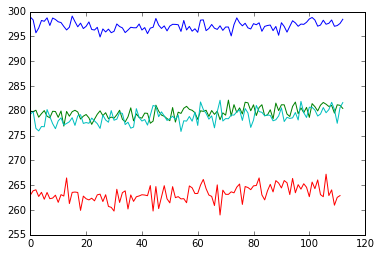

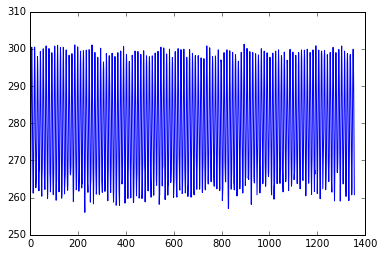

In [4]:
# ####### load LONG data for DJF
sea='DJF'
fldldt={}; fldregldt={}; latldt={}; lonldt={}; xxldt={} # 'l' for long
for fkey in fnameslong.keys():
    fname = fnameslong[fkey]
    #conv = convs[fkey]
    print 'LONG ' + fname, fieldslong[fkey]
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fieldslong[fkey],timesel=timesellong,seas=sea)
    latldt[fkey] = cnc.getNCvar(fname,'lat')
    lonldt[fkey] = cnc.getNCvar(fname,'lon')

    fldldt[fkey] = fld

    regdt={}
    for regkey in regionslong.keys():
        print regkey
        regdt[regkey] = cutl.calc_regmean(fld,latldt[fkey],lonldt[fkey],
                                          regionslong[regkey],model=None,alsomask=alsomask)

    xxldt[fkey] = np.arange(0,len(regdt[regkey])) # length of last reg good for all reg in field
    fldregldt[fkey] = regdt
# ##########################

# ####### load LONG data for all sea
#    ### load all seasons into one object for lead/lag
print 'LOAD ALL SEA'
plt.figure()
fldallldt={}; fldregallldt={}; xxallldt={} # 'l' for long

for asea in ('JJA','SON','DJF','MAM'):
    
    fldregsealdt={}; fldsealdt={}; 
    
    for fkey in fnameslong.keys():
        fname = fnameslong[fkey]
        #conv = convs[fkey]
        print asea + ' LONG ' + fname, fieldslong[fkey]
        alsomask=None
        if fkey=='sic':
            alsomask='land'
        fld = cnc.getNCvar(fname,fieldslong[fkey],timesel=timesellong,seas=asea)

        fldsealdt[fkey] = fld

        regdt={}
        for regkey in regionslong.keys():
            print regkey
            regdt[regkey] = cutl.calc_regmean(fld,latldt[fkey],lonldt[fkey],
                                              regionslong[regkey],model=None,alsomask=alsomask)

        xxallldt[fkey] = np.arange(0,len(regdt[regkey])) # length of last reg good for all reg in field
        fldregsealdt[fkey] = regdt
        if fkey=='sat' and regkey=='EUR': # testing data
            plt.plot(regdt[regkey])
        
    fldallldt[asea]= fldsealdt # [SEA][FKEY]
    fldregallldt[asea] = fldregsealdt # [SEA][FKEY][REG]
    
    
# ####### load all MONTHS for lead/lag
print 'LOAD ALL MON'
plt.figure()
fldregallmonldt={}; xxallmonldt={} # 'l' for long

#for asea in ('Ja','F','Mr','Ap','My','Jn','Jl','Au','S','O','N','D'):
if 1:    
    #fldregsealdt={}; fldsealdt={}; 
    
    for fkey in fnameslong.keys():
        fname = fnameslong[fkey]
        #conv = convs[fkey]
        print ' LONG ' + fname, fieldslong[fkey]
        alsomask=None
        if fkey=='sic':
            alsomask='land'
        fld = cnc.getNCvar(fname,fieldslong[fkey],timesel=timesellong)

        #fldsealdt[fkey] = fld  # don't save 3D all months

        regdt={}
        for regkey in regionslong.keys():
            print regkey
            regdt[regkey] = cutl.calc_regmean(fld,latldt[fkey],lonldt[fkey],
                                              regionslong[regkey],model=None,alsomask=alsomask)

        xxallmonldt[fkey] = np.arange(0,len(regdt[regkey])) # length of last reg good for all reg in field
        fldregallmonldt[fkey] = regdt
        if fkey=='sat' and regkey=='EUR': # testing data
            plt.plot(regdt[regkey])
        
    #fldallmonldt[asea]= fldsealdt # [SEA][FKEY]
    #fldregallmonldt[asea] = fldregsealdt # [SEA][FKEY][REG]


# ##########################

start,nyrs,remainder 0 113 0
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 1 112 11
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 2 112 10
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 3 112 9
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 4 112 8
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 5 112 7
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 6 112 6
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 7 112 5
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 8 112 4
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 9 112 3
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 10 112 2
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 11 112 1
nyrs 113
ret.shape (113,)
nyrs 113, and 113


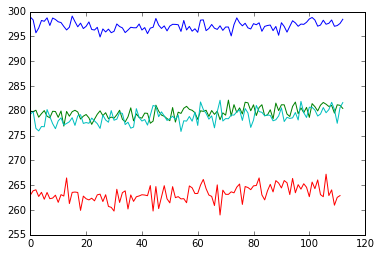

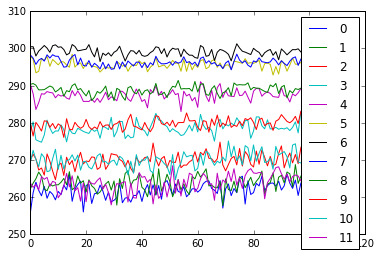

In [5]:
plt.figure()
for asea in ('JJA','SON','DJF','MAM'):
    
    plt.plot(fldregallldt[asea]['sat']['EUR'])
    
plt.figure()
for mii in range(0,12):
    
    pltfld = selectmonths(fldregallmonldt['sat']['EUR'], incr=1,start=mii)
    plt.plot(pltfld)
    
plt.legend((range(0,12)))

In [6]:
print fldldt['sat'].shape
print fldregldt['sat'].keys()
print fldregldt['sat']['EUR'].shape

print fldregallldt.keys()
print fldregallldt['JJA'].keys()

(112, 91, 180)
['NH', 'GM', 'EUR', 'BKS']
(112,)
['DJF', 'MAM', 'JJA', 'SON']
['sat', 'z500']


In [7]:
# loop through all months and compute lead/lag



mons = [5,6,7,8,9,10,11,12,13,14,15,16,17]

mondays = np.array([30,31, 31, 30,31,30,31,31,28,31,30,31,30])
monwgts = mondays / np.float(mondays.sum())
monsstr = ['Jn','Jl','Au','S','O','N','D','Ja','F','Mr','Ap','My','Jn'] # 13

leadlagmonr = np.zeros((len(mons),len(mons)))
leadlagmonp = np.zeros_like(leadlagmonr)
leadlagmondtrr = np.zeros_like(leadlagmonr)
leadlagmondtrp = np.zeros_like(leadlagmonr)


for cmii,cmon in enumerate(mons):
    
    for smii,smon in enumerate(mons):

        print '--- cmon ' + str(cmon) + ', smon ' + str(smon)
        # compute circ
        tmpbks = selectmonths(fldregallmonldt['z500']['BKS'],start=cmon,incr=1)
        tmpeur = selectmonths(fldregallmonldt['z500']['EUR'],start=cmon,incr=1)
        tmpcirc = tmpbks/tmpbks.std() - tmpeur/tmpeur.std()        

        tmpsat = selectmonths(fldregallmonldt['sat']['EUR'],start=smon,incr=1)

        if cmon<12 and smon>=12: # if one is into next yr, reduce timeseries length
            tmpcirc = tmpcirc[:-1]
        if smon<12 and cmon>=12:
            tmpsat = tmpsat[:-1]
                    
        print '--- ' + str(tmpcirc.shape), str(tmpsat.shape)
        
        
        _,_,corr_r,corr_p = cutl.regress(tmpcirc,tmpsat)
        print corr_r, corr_p
        
        leadlagmonr[cmii,smii] = corr_r
        leadlagmonp[cmii,smii] = corr_p
        
        _,_,corr_r,corr_p = cutl.regress(cutl.detrend(tmpcirc),cutl.detrend(tmpsat))
        print corr_r, corr_p
        
        leadlagmondtrr[cmii,smii] = corr_r
        leadlagmondtrp[cmii,smii] = corr_p
        

# HERE do a running 3 month avg ----------------
#   JJA, JAS, ASO, SON, OND, NDJ, DJF, JFM, FMA, MAM, AMJ  # 11

leadlagsear = np.zeros((len(mons)-2,len(mons)-2))
leadlagseap = np.zeros_like(leadlagsear)
leadlagseadtrr = np.zeros_like(leadlagsear)
leadlagseadtrp = np.zeros_like(leadlagsear)


for cmii,cmon in enumerate(mons[:-2]):
    
    cwgts = monwgts[cmii:cmii+3]
    
    for smii,smon in enumerate(mons[:-2]):

        swgts = monwgts[smii:smii+3]
        
        print '--- cmon ' + str(cmon) + ', smon ' + str(smon)
        # compute circ
        tmpbks = selectmonths(fldregallmonldt['z500']['BKS'],start=cmon,incr=3,weights=cwgts,retavg=True)
        tmpeur = selectmonths(fldregallmonldt['z500']['EUR'],start=cmon,incr=3,weights=cwgts,retavg=True)
        tmpcirc = tmpbks/tmpbks.std() - tmpeur/tmpeur.std()        

        tmpsat = selectmonths(fldregallmonldt['sat']['EUR'],start=smon,incr=3,weights=swgts,retavg=True)

        if cmon<10 and smon>=10: # if one sea is into next yr (ie sea start w/ N), reduce timeseries length
            tmpcirc = tmpcirc[:-1]
        if smon<10 and cmon>=10:
            tmpsat = tmpsat[:-1]
            
        
        print '--- ' + str(tmpcirc.shape), str(tmpsat.shape)
        
        
        _,_,corr_r,corr_p = cutl.regress(tmpcirc,tmpsat)
        print corr_r, corr_p
        
        leadlagsear[cmii,smii] = corr_r
        leadlagseap[cmii,smii] = corr_p
        
        _,_,corr_r,corr_p = cutl.regress(cutl.detrend(tmpcirc),cutl.detrend(tmpsat))
        print corr_r, corr_p
        
        leadlagseadtrr[cmii,smii] = corr_r
        leadlagseadtrp[cmii,smii] = corr_p


--- cmon 5, smon 5
start,nyrs,remainder 5 112 7
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 5 112 7
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 5 112 7
nyrs 113
ret.shape (113,)
nyrs 113, and 113
--- (113,) (113,)
-0.483513591593 5.80142820599e-08
-0.480998922257 6.94745341399e-08
--- cmon 5, smon 6
start,nyrs,remainder 5 112 7
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 5 112 7
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 6 112 6
nyrs 113
ret.shape (113,)
nyrs 113, and 113
--- (113,) (113,)
-0.302817904027 0.00111370912504
-0.309746075743 0.000842203404675
--- cmon 5, smon 7
start,nyrs,remainder 5 112 7
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 5 112 7
nyrs 113
ret.shape (113,)
nyrs 113, and 113
start,nyrs,remainder 7 112 5
nyrs 113
ret.shape (113,)
nyrs 113, and 113
--- (113,) (113,)
-0.277001439427 0.00297630024312
-0.272897280343 0.00345116027017
--- cmon 5, smon 8
start,nyrs,r

In [8]:
monwgts


array([ 0.07594937,  0.07848101,  0.07848101,  0.07594937,  0.07848101,
        0.07594937,  0.07848101,  0.07848101,  0.07088608,  0.07848101,
        0.07594937,  0.07848101,  0.07594937])

['Jn' 'Au' 'O' 'D' 'F' 'Ap' 'Jn']


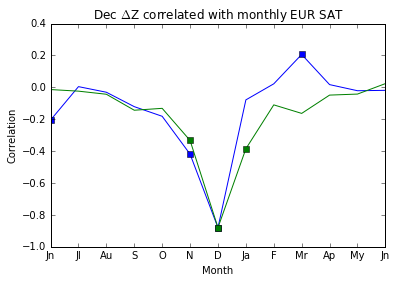

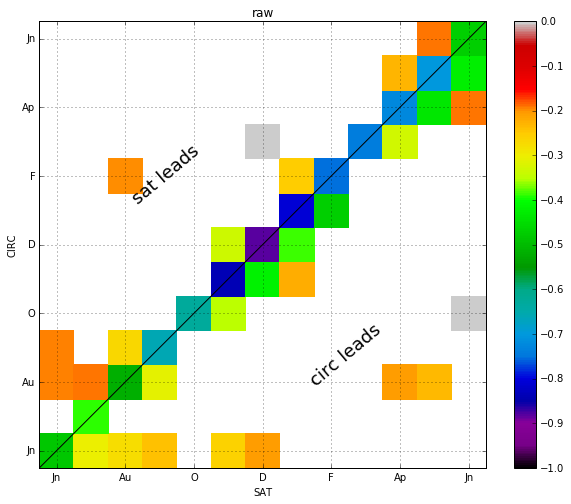

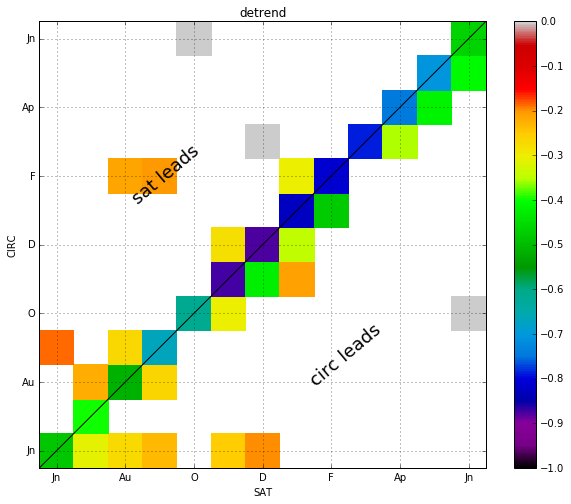

In [9]:
printtofile=False

# plot monthly lead/lag
xt = [1,3,5,7,9,11,13,15,17]
xt = [0,2,4,6,8,10,12]
cmap = plt.cm.get_cmap('nipy_spectral') #'Set1') #red2blue_20')

leadlagmonsig = ma.masked_where(leadlagmonp>0.05,leadlagmonr)
leadlagmondtrsig = ma.masked_where(leadlagmondtrp>0.05,leadlagmondtrr)


fig,ax = plt.subplots(1,1)
ax.plot(mons,leadlagmonr[:,6],color='b')
ax.plot(mons,leadlagmonsig[:,6],linestyle='none',marker='s',color='b')
ax.set_xticks(mons)
ax.set_xticklabels(monsstr)
ax.set_ylabel('Correlation')
ax.set_xlabel('Month')
ax.set_title('Dec $\Delta$Z correlated with monthly EUR SAT')
# @@@ not sure I have the correct axis plotted @@@
ax.plot(mons,leadlagmonr[6,:],color='g')
ax.plot(mons,leadlagmonsig[6,:],color='g',marker='s',linestyle='none')


print np.array(monsstr)[xt]

fig,ax = plt.subplots(1,1,figsize=(10,8))
#pc = ax.pcolor(leadlagmonr,vmin=-1,vmax=.4,cmap=cmap)
pc = ax.pcolor(leadlagmonsig,vmin=-1,vmax=0,cmap=cmap)
ax.grid()
ax.plot((0,len(mons)),(0,len(mons)),color='k')
ax.annotate('sat leads',xy=(0.2,.7),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')
ax.annotate('circ leads',xy=(0.6,.3),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')

plt.colorbar(pc)
ax.set_xticks(np.array(xt)+.5)
ax.set_xticklabels(np.array(monsstr)[xt])
ax.set_xlabel('SAT')
ax.set_yticks(np.array(xt)+.5)
ax.set_yticklabels(np.array(monsstr)[xt])
ax.set_ylabel('CIRC')
ax.set_title('raw')
ax.set_xlim((0,len(mons)))
ax.set_ylim((0,len(mons)))
if printtofile:
    fig.savefig('leadlagcorr_raw_monthly_circ_v_eursat.pdf')
    fig.savefig('leadlagcorr_raw_monthly_circ_v_eursat.png')


fig,ax = plt.subplots(1,1,figsize=(10,8))
#pc = ax.pcolor(leadlagmondtrr,vmin=-1,vmax=0,cmap=cmap)
pc = ax.pcolor(leadlagmondtrsig,vmin=-1,vmax=0,cmap=cmap)
ax.grid()
ax.plot((0,len(mons)),(0,len(mons)),color='k')
ax.annotate('sat leads',xy=(0.2,.7),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')
ax.annotate('circ leads',xy=(0.6,.3),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')

plt.colorbar(pc)
ax.set_xticks(np.array(xt)+.5)
ax.set_xticklabels(np.array(monsstr)[xt])
ax.set_xlabel('SAT')
ax.set_yticks(np.array(xt)+.5)
ax.set_yticklabels(np.array(monsstr)[xt])
ax.set_ylabel('CIRC')
ax.set_title('detrend')
ax.set_xlim((0,len(mons)))
ax.set_ylim((0,len(mons)))
if printtofile:
    fig.savefig('leadlagcorr_dtr_monthly_circ_v_eursat.pdf')
    fig.savefig('leadlagcorr_dtr_monthly_circ_v_eursat.png')


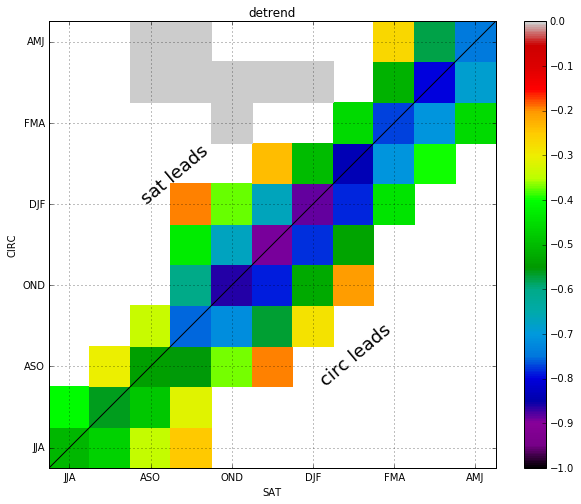

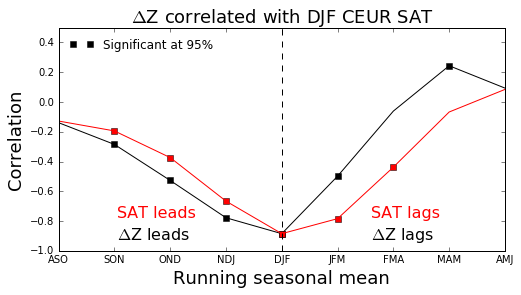

In [10]:
# 3-mo running monthly lead/lag

printtofile=False

#xt = [1,3,5,7,9,11,13,15] # JAS, SON, ..., AMJ
xt = [0,2,4,6,8,10] # JJA, ASO, OND, DJF ...
seastr = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ']  # 11

cmap = plt.cm.get_cmap('nipy_spectral') #'Set1') #red2blue_20')

leadlagseasig = ma.masked_where(leadlagseap>0.05,leadlagsear)
leadlagseadtrsig = ma.masked_where(leadlagseadtrp>0.05,leadlagseadtrr)

fig,ax = plt.subplots(1,1,figsize=(10,8))
#pc = ax.pcolor(leadlagmondtrr,vmin=-1,vmax=0,cmap=cmap)
pc = ax.pcolor(leadlagseadtrsig,vmin=-1,vmax=0,cmap=cmap)
ax.grid()
ax.plot((0,len(mons)-2),(0,len(mons)-2),color='k')
ax.annotate('sat leads',xy=(0.2,.7),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')
ax.annotate('circ leads',xy=(0.6,.3),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')

plt.colorbar(pc)
ax.set_xticks(np.array(xt)+.5)
ax.set_xticklabels(np.array(seastr)[xt])
ax.set_xlabel('SAT')
ax.set_yticks(np.array(xt)+.5)
ax.set_yticklabels(np.array(seastr)[xt])
ax.set_ylabel('CIRC')
ax.set_title('detrend')
ax.set_xlim((0,len(mons)-2))
ax.set_ylim((0,len(mons)-2))
if printtofile:
    fig.savefig('leadlagcorr_dtr_3monrun_circ_v_eursat.pdf')
    fig.savefig('leadlagcorr_dtr_3monrun_circ_v_eursat.png')

    
# idx 6 is DJF
xt = [2,3,4,5,6,7,8,9,10] # JJA, ASO, OND, DJF ...

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(leadlagseadtrsig[:,6],linestyle='none',marker='s',color='k')
ax.plot(leadlagseadtrr[:,6],color='k') # this shows circ lead/lag
ax.plot(leadlagseadtrsig[6,:],linestyle='none',marker='s',color='r')
ax.plot(leadlagseadtrr[6,:],color='r') # this shows sat lead/lag

ax.set_xticks(xt)
ax.set_xticklabels(np.array(seastr)[xt])
ax.set_ylabel('Correlation',fontsize=18)
ax.set_xlabel('Running seasonal mean',fontsize=18)
ax.set_title('$\Delta$Z correlated with DJF CEUR SAT',fontsize=18)
ax.set_xlim(2,10)
ax.set_ylim((-1,.5))
ax.annotate('$\Delta$Z leads',xy=(0.13,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('$\Delta$Z lags',xy=(0.7,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('SAT leads',xy=(0.13,.15),
            xycoords='axes fraction',fontsize=16,color='red')#,fontweight='bold')
ax.annotate('SAT lags',xy=(0.7,.15),
            xycoords='axes fraction',fontsize=16,color='red')#,fontweight='bold')
ax.axvline(x=6,linestyle='dashed',color='k')
ax.legend(('Significant at 95%',),loc='upper left',frameon=False)
if printtofile:
    fig.savefig('leadlagcorr_dtr_3monrun_circ_v_DJFeursat.pdf')
    fig.savefig('leadlagcorr_dtr_3monrun_circ_v_DJFeursat.png')

# @@@ not sure I have the correct axis plotted @@@
#ax.plot(leadlagseadtrr[6,:],color='g') # this shows sat lead/lag
#ax.plot(leadlagseadtrsig[6,:],color='g',marker='s',linestyle='none')


In [11]:
# loop through all seas and compute lead/lag

leadlagr = np.zeros((5,5))
leadlagp = np.zeros((5,5))
leadlagdtrr = np.zeros((5,5))
leadlagdtrp = np.zeros((5,5))
for cii,csea in enumerate(('JJA','SON','DJF','MAM','JJApost')):
    
    getcsea = csea
    if csea=='JJApost': getcsea='JJA'
        
    for sii,ssea in enumerate(('JJA','SON','DJF','MAM','JJApost')):
        
        getssea=ssea        
        if ssea=='JJApost': getssea='JJA'
            
        #compute circ
        tmpbks = fldregallldt[getcsea]['z500']['BKS']
        tmpeur = fldregallldt[getcsea]['z500']['EUR']
        tmpcirc = tmpbks/tmpbks.std() - tmpeur/tmpeur.std()        
        
        tmpsat = fldregallldt[getssea]['sat']['EUR']
        
        # need to line up lead/lag months (and deal w/ DJF being shorter)
        if csea in ('MAM','JJApost'):
            tmpcirc = tmpcirc[1:]
            if ssea not in ('MAM','JJApost','DJF'): 
                tmpsat=tmpsat[:-1]
        elif csea == 'DJF' and ssea not in ('DJF','MAM','JJApost'):
            tmpsat = tmpsat[:-1] # remove last one to make equal length
            
        if ssea in ('MAM','JJApost'):
            tmpsat = tmpsat[1:]
            if csea not in ('MAM','JJApost','DJF'): 
                tmpcirc=tmpcirc[:-1]
        elif ssea == 'DJF' and csea not in ('DJF','MAM','JJApost'):
            tmpcirc = tmpcirc[:-1] # remove last one to make equal length
        
        
        print str(cii),csea,str(sii),ssea
        print tmpcirc.shape, tmpsat.shape
        
        _,_,corr_r,corr_p = cutl.regress(tmpcirc,tmpsat)
        print corr_r, corr_p
        
        leadlagr[cii,sii] = corr_r
        leadlagp[cii,sii] = corr_p
        
        _,_,corr_r,corr_p = cutl.regress(cutl.detrend(tmpcirc),cutl.detrend(tmpsat))
        print corr_r, corr_p
        
        leadlagdtrr[cii,sii] = corr_r
        leadlagdtrp[cii,sii] = corr_p

0 JJA 0 JJA
(113,) (113,)
-0.50844649866 8.95849386831e-09
-0.504342741203 1.23102571136e-08
0 JJA 1 SON
(113,) (113,)
-0.306428440652 0.000963596936212
-0.247962487799 0.00809551120834
0 JJA 2 DJF
(112,) (112,)
-0.122911102618 0.196676764868
-0.0611589387591 0.521792775648
0 JJA 3 MAM
(112,) (112,)
-0.120956280865 0.20394559108
-0.0403921510396 0.672406576018
0 JJA 4 JJApost
(112,) (112,)
-0.0233289849612 0.807111346554
-0.00336294714115 0.97192750432
1 SON 0 JJA
(113,) (113,)
-0.065817103181 0.488549423984
-0.0553095789599 0.560662763723
1 SON 1 SON
(113,) (113,)
-0.724152541768 1.26511514414e-19
-0.757638249687 2.67531113171e-22
1 SON 2 DJF
(112,) (112,)
-0.318736724256 0.000614485426506
-0.280733842201 0.00271565984758
1 SON 3 MAM
(112,) (112,)
-0.0276433315369 0.772334313778
0.0605942059755 0.525651278442
1 SON 4 JJApost
(112,) (112,)
0.173874975065 0.0667328943353
0.19639500493 0.0379504096296
2 DJF 0 JJA
(112,) (112,)
-0.110701347275 0.245241429959
-0.107596628461 0.258812218015

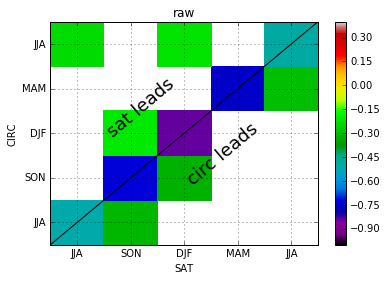

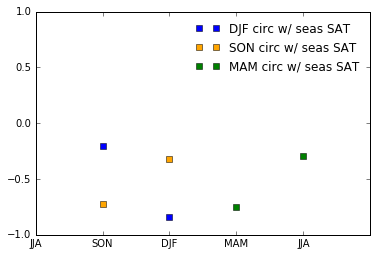

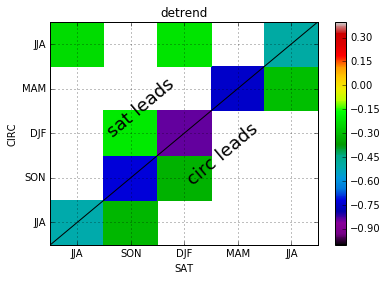

In [12]:
printtofile=False


cmap = plt.cm.get_cmap('nipy_spectral') #'Set1') #red2blue_20')

leadlagsig = ma.masked_where(leadlagp>0.05,leadlagr)
leadlagdtrsig = ma.masked_where(leadlagdtrp>0.05,leadlagdtrr)


fig,ax = plt.subplots(1,1)
#pc = ax.pcolor(leadlagr,vmin=-1,vmax=1,cmap=cmap)
pc = ax.pcolor(leadlagsig,vmin=-1,vmax=.4,cmap=cmap)
ax.plot((0,5),(0,5),color='k')
ax.annotate('sat leads',xy=(0.2,.7),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')
ax.annotate('circ leads',xy=(0.5,.5),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')

#ax.plot(leadlagsig,marker='.',linestyle='none')
#ax.contourf(leadlagsig,colors='none',hatches='o')
plt.colorbar(pc)
ax.set_xticks((0.5,1.5,2.5,3.5,4.5))
ax.set_xticklabels(('JJA','SON','DJF','MAM','JJA'))
ax.set_xlabel('SAT')
ax.set_yticks((0.5,1.5,2.5,3.5,4.5))
ax.set_yticklabels(('JJA','SON','DJF','MAM','JJA'))
ax.set_ylabel('CIRC')
ax.set_title('raw')
ax.grid()
if printtofile:
    fig.savefig('leadlagcorr_raw_seasonal_circ_v_eursat.pdf')
    fig.savefig('leadlagcorr_raw_seasonal_circ_v_eursat.png')

fig,ax = plt.subplots(1,1)
ax.plot(leadlagsig[2,:], linestyle='none',marker='s',color='b')
ax.plot(leadlagsig[1,:], linestyle='none',marker='s',color='orange')
ax.plot(leadlagsig[3,:], linestyle='none',marker='s',color='g')
ax.legend(('DJF circ w/ seas SAT','SON circ w/ seas SAT','MAM circ w/ seas SAT'),frameon=False)
ax.set_xlim((0,5))
ax.set_ylim((-1,1))
ax.set_xticklabels(('JJA','SON','DJF','MAM','JJA'))



fig,ax = plt.subplots(1,1)
#pc = ax.pcolor(leadlagr,vmin=-1,vmax=1,cmap=cmap)
pc = ax.pcolor(leadlagsig,vmin=-1,vmax=.4,cmap=cmap)
#ax.plot(leadlagsig,marker='.',linestyle='none')
#ax.contourf(leadlagsig,colors='none',hatches='o')
ax.plot((0,5),(0,5),color='k')
ax.annotate('sat leads',xy=(0.2,.7),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')
ax.annotate('circ leads',xy=(0.5,.5),
            xycoords='axes fraction',fontsize=18, rotation=40)#,fontweight='bold')

plt.colorbar(pc)
ax.set_xticks((0.5,1.5,2.5,3.5,4.5))
ax.set_xticklabels(('JJA','SON','DJF','MAM','JJA'))
ax.set_xlabel('SAT')
ax.set_yticks((0.5,1.5,2.5,3.5,4.5))
ax.set_yticklabels(('JJA','SON','DJF','MAM','JJA'))
ax.set_ylabel('CIRC')
ax.set_title('detrend')
ax.grid()
if printtofile:
    fig.savefig('leadlagcorr_dtr_seasonal_circ_v_eursat.pdf')
    fig.savefig('leadlagcorr_dtr_seasonal_circ_v_eursat.png')


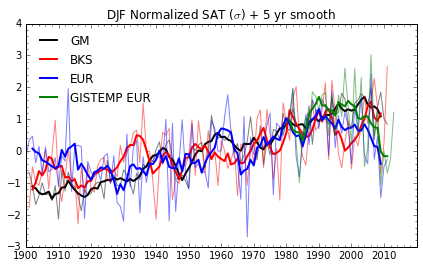

In [13]:
# #### long data


printtofile=False

clrs = {'GM': 'k', 'NH': '0.5', 'EUR': 'b', 'BKS': 'r', 'EPAC': 'g'}
gmlg=mlines.Line2D([],[],color=clrs['GM'],linewidth=2) 
nhlg=mlines.Line2D([],[],color=clrs['NH'],linewidth=2) 
eurlg=mlines.Line2D([],[],color=clrs['EUR'],linewidth=2) 
bkslg=mlines.Line2D([],[],color=clrs['BKS'],linewidth=2) 
paclg=mlines.Line2D([],[],color=clrs['EPAC'],linewidth=2) 


fkey='sat'
styear=1900
xxl=xxldt[fkey]
window=5
xxlrun = xxl[window/2:-window/2+1]


# note GISTEMP anomaly is from a diff timeperiod than the reanalysis. @@

doregs=('GM','BKS','EUR')
dolgs=(gmlg,bkslg,eurlg)

fig,ax=plt.subplots(1,1)
fig.set_size_inches((7,4))
for regkey in doregs:
    fldreg = fldregldt[fkey][regkey]-273
    #fldreg = fldreg - fldreg.mean()
    
    ax.plot(xxlrun, runmean((fldreg-fldreg.mean())/np.std(fldreg),window=window),
            color=clrs[regkey],linewidth=2)
    ax.plot(xxl, (fldreg-fldreg.mean())/np.std(fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)
    #ax.plot(xxrun, runmean((fldreg),window=window),
    #        color=clrs[regkey],linewidth=2)
    #ax.plot(xx, (fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)

fldreg = fldregdt['sat']['EUR']
xx=xxdt[fkey]+79
xxrun = xx[window/2:-window/2+1]
ax.plot(xxrun, runmean(fldreg/fldreg.std(),window=window),
       color='g', linewidth=2)
ax.plot(xx, (fldreg)/np.std(fldreg),color='g',linewidth=1,alpha=0.5)    
    
ax.legend(dolgs+(paclg,),doregs+('GISTEMP EUR',),loc='upper left',frameon=False)
ax.set_title(sea + ' Normalized SAT ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))
if printtofile:
    fig.savefig('SATbkseurgm_stdanom_' + sea + '_20CR1900-2012_run' + str(window) + 'timeseries.pdf')
    fig.savefig('SATbkseurgm_stdanom_' + sea + '_20CR1900-2012_run' + str(window) + 'timeseries.png',dpi=300)
    
 

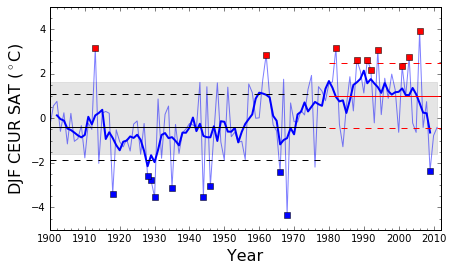

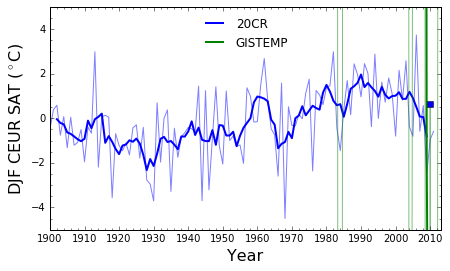

In [14]:
printtofile=False

fsz=18

# "cold event"
eursatl = fldregldt['sat']['EUR']
eursd1 = eursatl.std()
eurm = eursatl.mean()
eurmg = eursatl[51:81].mean() # base period for GISTEMP 1951-80

eursatlanom = eursatl-eurm
eursatlanomg = eursatl-eurmg


eurmearly = eursatlanom[0:80].mean()
eurmlate = eursatlanom[80:].mean()
eurmearlysd = eursatlanom[0:80].std()
eurmlatesd = eursatlanom[80:].std()


fig,ax=plt.subplots(1,1)
fig.set_size_inches((7,4))
ax.plot(xxlrun, runmean(eursatlanom,window=window),
        color='b',linewidth=2)
ax.plot(xxl, eursatlanom,color='b',linewidth=1,alpha=0.5)
#ax.axhline(y=eursd1,color='k',linestyle='--')
#ax.axhline(y=-eursd1,color='k',linestyle='--')

ax.plot((0,79),(eurmearly,eurmearly),color='k')
ax.plot((0,79),(eurmearly+eurmearlysd,eurmearly+eurmearlysd),color='k',linestyle='--')
ax.plot((0,79),(eurmearly-eurmearlysd,eurmearly-eurmearlysd),color='k',linestyle='--')

ax.plot((80,112),(eurmlate,eurmlate),color='r')
ax.plot((80,112),(eurmlate+eurmlatesd,eurmlate+eurmlatesd),color='r',linestyle='--')
ax.plot((80,112),(eurmlate-eurmlatesd,eurmlate-eurmlatesd),color='r',linestyle='--')

ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))

ax.fill_between(xxl,eursd1,-eursd1,color='0.8',alpha=0.5)

ax.set_ylabel('DJF CEUR SAT ($^\circ$C)',fontsize=fsz-2)
ax.set_xlabel('Year',fontsize=fsz-2)
ax.set_ylim((-5,5))

nn=10
hhighidx = (-eursatlanom).argsort()[:nn]
hlowidx = eursatlanom.argsort()[:nn]
ax.plot(xxl[hhighidx], eursatlanom[hhighidx],color='r',marker='s',linestyle='none')
ax.plot(xxl[hlowidx], eursatlanom[hlowidx],color='b',marker='s',linestyle='none')

if printtofile:
    fig.savefig('SATeur_topbot10_anom_' + sea + '_20CR_run' + str(window) + 'timeseries.pdf')
    fig.savefig('SATeur_topbot10_anom_' + sea + '_20CR_run' + str(window) + 'timeseries.png',dpi=300)
    
    
# short, using GISTEMP
fig,ax=plt.subplots(1,1)
fig.set_size_inches((7,4))

ax.plot(xxlrun, runmean(eursatlanomg,window=window),
        color='b',linewidth=2)
ax.plot(xxl, eursatlanomg,color='b',linewidth=1,alpha=0.5)

eursats = fldregdt['sat']['EUR']*100

xx=xxdt[fkey]+79
xxrun = xx[window/2:-window/2+1]
ax.plot(xxrun, runmean(eursats,window=window),
       color='g', linewidth=2)
ax.plot(xx, eursats,color='g',linewidth=1,alpha=0.5)    
ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))
ax.set_ylabel('DJF CEUR SAT ($^\circ$C)',fontsize=fsz-2)
ax.set_xlabel('Year',fontsize=fsz-2)
ax.set_ylim((-5,5))


nn=10
hhighidxs = (-eursats).argsort()[:nn]
hlowidxs = eursats.argsort()[:nn]
ax.plot(xx[hhighidxs], eursats[hhighidxs],color='r',marker='s',linestyle='none')
ax.plot(xx[hlowidxs], eursats[hlowidxs],color='b',marker='s',linestyle='none')

ax.legend((eurlg,paclg,),('20CR','GISTEMP',),loc='best',frameon=False)

if printtofile:
    fig.savefig('SATeur_topbot10GIS_anombase1951-80_' + sea + '_20CRGISTEMP_run' + str(window) + 'timeseries.pdf')
    fig.savefig('SATeur_topbot10GIS_anombase1951-80_' + sea + '_20CRGISTEMP_run' + str(window) + 'timeseries.png',
               dpi=300)

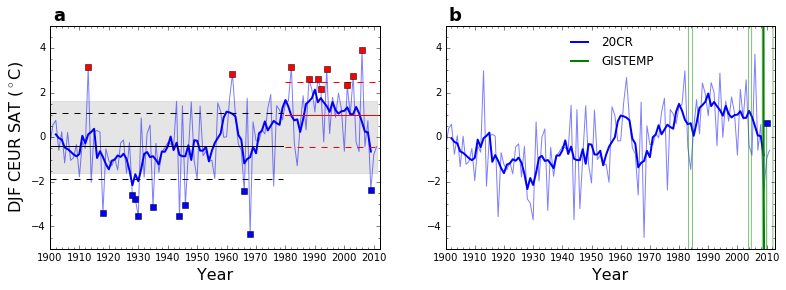

In [15]:
printtofile=False


fig,axs=plt.subplots(1,2)
fig.set_size_inches((13,4))
ax=axs[0]
ax.plot(xxlrun, runmean(eursatlanom,window=window),
        color='b',linewidth=2)
ax.plot(xxl, eursatlanom,color='b',linewidth=1,alpha=0.5)
#ax.axhline(y=eursd1,color='k',linestyle='--')
#ax.axhline(y=-eursd1,color='k',linestyle='--')

ax.plot((0,79),(eurmearly,eurmearly),color='k')
ax.plot((0,79),(eurmearly+eurmearlysd,eurmearly+eurmearlysd),color='k',linestyle='--')
ax.plot((0,79),(eurmearly-eurmearlysd,eurmearly-eurmearlysd),color='k',linestyle='--')

ax.plot((80,112),(eurmlate,eurmlate),color='r')
ax.plot((80,112),(eurmlate+eurmlatesd,eurmlate+eurmlatesd),color='r',linestyle='--')
ax.plot((80,112),(eurmlate-eurmlatesd,eurmlate-eurmlatesd),color='r',linestyle='--')

ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))

ax.fill_between(xxl,eursd1,-eursd1,color='0.8',alpha=0.5)

ax.set_ylabel('DJF CEUR SAT ($^\circ$C)',fontsize=fsz-2)
ax.set_xlabel('Year',fontsize=fsz-2)
ax.set_ylim((-5,5))

nn=10
hhighidx = (-eursatlanom).argsort()[:nn]
hlowidx = eursatlanom.argsort()[:nn]
ax.plot(xxl[hhighidx], eursatlanom[hhighidx],color='r',marker='s',linestyle='none')
ax.plot(xxl[hlowidx], eursatlanom[hlowidx],color='b',marker='s',linestyle='none')
ax.annotate('a',xy=(0.01,1.02),
            xycoords='axes fraction',fontsize=18,fontweight='bold')
    
# short, using GISTEMP
ax=axs[1]
ax.plot(xxlrun, runmean(eursatlanomg,window=window),
        color='b',linewidth=2)
ax.plot(xxl, eursatlanomg,color='b',linewidth=1,alpha=0.5)

eursats = fldregdt['sat']['EUR']*100

xx=xxdt[fkey]+79
xxrun = xx[window/2:-window/2+1]
ax.plot(xxrun, runmean(eursats,window=window),
       color='g', linewidth=2)
ax.plot(xx, eursats,color='g',linewidth=1,alpha=0.5)    
ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))
#ax.set_ylabel('DJF CEUR SAT ($^\circ$C)',fontsize=fsz-2)
ax.set_xlabel('Year',fontsize=fsz-2)
ax.set_ylim((-5,5))


nn=10
hhighidxs = (-eursats).argsort()[:nn]
hlowidxs = eursats.argsort()[:nn]
ax.plot(xx[hhighidxs], eursats[hhighidxs],color='r',marker='s',linestyle='none')
ax.plot(xx[hlowidxs], eursats[hlowidxs],color='b',marker='s',linestyle='none')
ax.annotate('b',xy=(0.01,1.02),
            xycoords='axes fraction',fontsize=18,fontweight='bold')
ax.legend((eurlg,paclg,),('20CR','GISTEMP',),loc='best',frameon=False)
if printtofile:
    fig.savefig('SATeur_2panel_topbot10GIS_anombase1951-80_' + sea + '_20CRGISTEMP_run' + str(window) + 'timeseries.pdf')
    fig.savefig('SATeur_2panel_topbot10GIS_anombase1951-80_' + sea + '_20CRGISTEMP_run' + str(window) + 'timeseries.png',
               dpi=300)

regress mm,bb,pval,rval: -0.00313905912249 0.174217781298 0.517873489106 -0.0617347409136


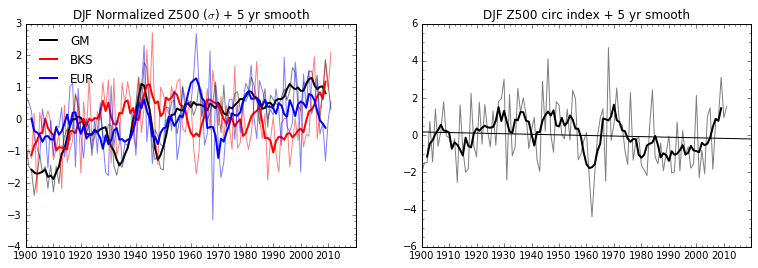

In [16]:
cplt=reload(cplt)

fkey='z500'
fig,axs=plt.subplots(1,2)
fig.set_size_inches((13,4))

bkszl = fldregldt[fkey]['BKS']
eurzl = fldregldt[fkey]['EUR']
circlong = bkszl/bkszl.std() - eurzl/eurzl.std()
circlong = (bkszl-bkszl.mean())/bkszl.std() - (eurzl-eurzl.mean())/eurzl.std()

ax=axs[0]
for regkey in doregs:
    fldreg = fldregldt[fkey][regkey]
    #fldreg = fldreg - fldreg.mean()
    
    ax.plot(xxlrun, runmean((fldreg-fldreg.mean())/np.std(fldreg),window=window),
            color=clrs[regkey],linewidth=2)
    ax.plot(xxl, (fldreg-fldreg.mean())/np.std(fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)
    #ax.plot(xxrun, runmean((fldreg),window=window),
    #        color=clrs[regkey],linewidth=2)
    #ax.plot(xx, (fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)
    
    
ax.legend(dolgs,doregs,loc='upper left',frameon=False)
ax.set_title(sea + ' Normalized Z500 ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))

ax=axs[1]
ax.plot(xxlrun, runmean(circlong,window=window),
        color='k',linewidth=2)
ax.plot(xxl, circlong,color='k',linewidth=1,alpha=0.5)
cplt.add_regressline(xxl,circlong,ax=ax)
ax.set_title(sea + ' Z500 circ index + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))

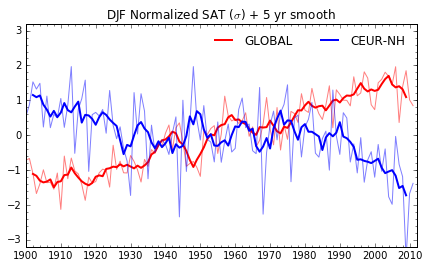

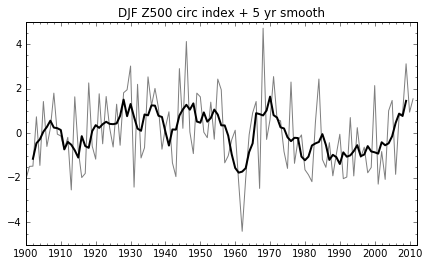

In [17]:
printtofile=False


eursatl = fldregldt['sat']['EUR']
nhsatl = fldregldt['sat']['NH']
gmsatl = fldregldt['sat']['GM']

fig,ax=plt.subplots(1,1)
fig.set_size_inches((7,4))

ax.plot(xxlrun, runmean((gmsatl-gmsatl.mean())/gmsatl.std(),window=window),
        color='r',linewidth=2)
ax.plot(xxl, (gmsatl-gmsatl.mean())/gmsatl.std(),color='r',linewidth=1,alpha=0.5)
eurnhsatl = (eursatl-eursatl.mean())/eursatl.std()-(nhsatl-nhsatl.mean())/nhsatl.std()
ax.plot(xxlrun, runmean(eurnhsatl,window=window),
        color='b',linewidth=2)
ax.plot(xxl,eurnhsatl,color='b',linewidth=1,alpha=0.5)
ax.set_title(sea + ' Normalized SAT ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))
ax.set_xlim((0,112))
ax.legend((bkslg,eurlg),('GLOBAL','CEUR-NH'),loc='best',ncol=2,frameon=False)
ax.set_ylim((-3.2,3.2))

if printtofile:
    fig.savefig('Figure1long_SAT_stdanom_' + sea + '_20CR1900-2012_run' + str(window) + 'timeseries.pdf')
    fig.savefig('Figure1long_SAT_stdanom_' + sea + '_20CR1900-2012_run' + str(window) + 'timeseries.png',
               dpi=300)

fig,ax=plt.subplots(1,1)
fig.set_size_inches((7,4))

ax.plot(xxlrun, runmean(circlong,window=window),
        color='k',linewidth=2)
ax.plot(xxl, circlong,color='k',linewidth=1,alpha=0.5)
ax.set_title(sea + ' Z500 circ index + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(0,len(xxl),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear,2012,10))
ax.set_ylim((-5,5))
ax.set_xlim((0,112))
if printtofile:
    fig.savefig('SuppFigure5long_Z500circidx_' + sea + '_20CR1900-2012_run' + str(window) + 'timeseries.pdf')
    fig.savefig('SuppFigure5long_Z500circidx_' + sea + '_20CR1900-2012_run' + str(window) + 'timeseries.png',
               dpi=300)


In [18]:
# read in climate indices
idxdir = '/HOME/rkm/work/DATA/climateindices/'
import pandas as pd

nao = pd.read_csv(idxdir+'naoread.data',sep=r"\s*",index_col='Year') #delimiter=' ')
ao = pd.read_csv(idxdir+'aoread.data',sep=r"\s*",index_col='Year') #delimiter=' ')


/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


(63, 12)
start,nyrs,remainder 11 62 1
nyrs 62
ret.shape (62,)
nyrs 62, and 62


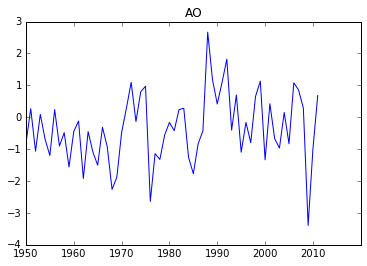

In [19]:
aosub=ao[ao.index<2013]
print aosub.shape
aomoar = aosub.values.flatten()
aodjfar = selectmonths(aomoar,start=11,incr=3,retavg=True)

plt.figure()
plt.plot(np.arange(1950,2012),aodjfar)
plt.xticks(np.arange(1950,2020,10))
plt.title('AO')

(68, 12)
(63, 12)
(756,)
start,nyrs,remainder 11 62 1
nyrs 62
ret.shape (62,)
nyrs 62, and 62
(62,)


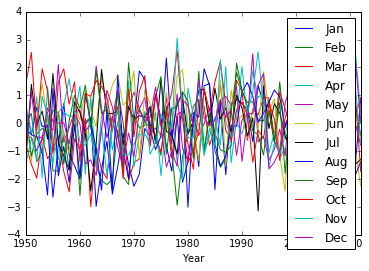

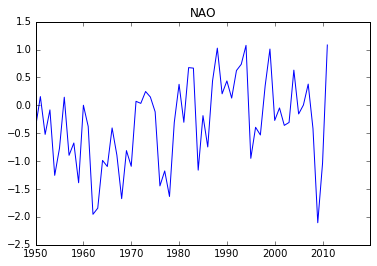

In [20]:
print nao.values.shape
naosub=nao[nao.index<2013]
naosub=naosub[naosub.index!=-99.9] # to match 20CR
print naosub.shape
#print naosub
naosub.plot()

naomoar = naosub.values.flatten()
print naomoar.shape
naodjfar = selectmonths(naomoar,start=11,incr=3,retavg=True)
print naodjfar.shape

plt.figure()
plt.plot(np.arange(1950,2012),naodjfar)
plt.xticks(np.arange(1950,2020,10))
plt.title('NAO')

(62,)
(62,)
circ idx reg on NAO
-0.351674487747 -0.299077048842 -0.164020706266 0.202711491569
detrend
-0.361404508251 -0.302236323728 -0.158949402094 0.217217512054
circ idx reg on NAO 1979-2012
-0.856432931292 -0.410156530193 -0.40855673867 0.0182481731123
detrend
-0.743559411868 -0.41204383624 -0.377268623327 0.0304357148802

circ idx reg on AO 1950-2012
-0.540719148905 -0.3768814729 -0.35007626452 0.00528287580647
detrend
-0.551610501447 -0.380748619387 -0.349252706807 0.00539833837501
circ idx reg on AO 1979-2012
-0.702354992331 -0.47577140355 -0.531001105295 0.00147584926641
detrend
-0.666460899102 -0.473149962441 -0.542082784847 0.00111967163956


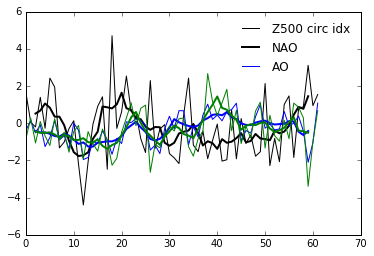

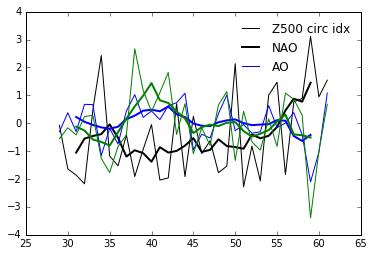

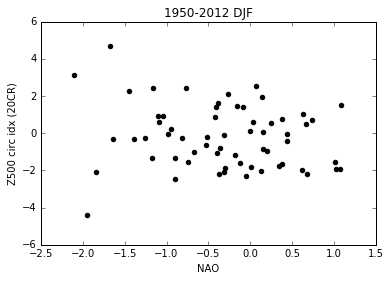

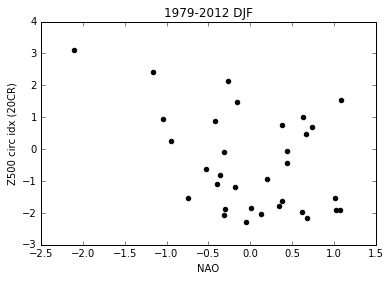

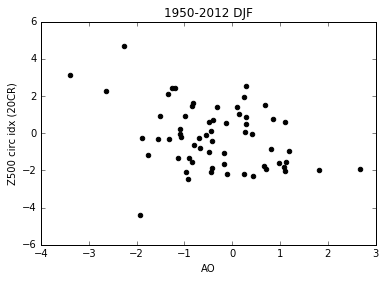

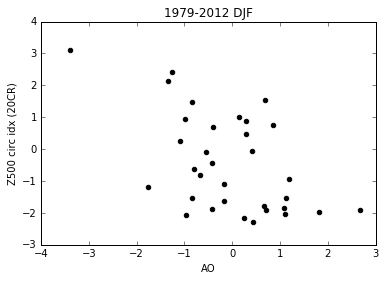

In [21]:
print circlong[50:].shape
print naodjfar.shape

xxn=np.arange(0,len(naodjfar))
window=5
xxnrun = xxn[window/2:-window/2+1]

fig,ax = plt.subplots(1,1)
ax.plot(circlong[50:],'k')
ax.plot(xxnrun,runmean(circlong[50:],window=window),linewidth=2,color='k')
ax.plot(naodjfar,'b')
ax.plot(xxnrun,runmean(naodjfar,window=window),linewidth=2,color='b')
ax.plot(aodjfar,'g')
ax.plot(xxnrun,runmean(aodjfar,window=window),linewidth=2,color='g')
ax.legend(('Z500 circ idx','NAO','AO'),frameon=False)

xxn=np.arange(29,len(naodjfar))
window=5
xxnrun = xxn[window/2:-window/2+1]

fig,ax = plt.subplots(1,1)
ax.plot(xxn,circlong[79:],'k')
ax.plot(xxnrun,runmean(circlong[79:],window=window),color='k',linewidth=2)
ax.plot(xxn,naodjfar[29:],'b')
ax.plot(xxnrun,runmean(naodjfar[29:],window=window),color='b',linewidth=2)
ax.plot(xxn,aodjfar[29:],'g')
ax.plot(xxnrun,runmean(aodjfar[29:],window=window),color='g',linewidth=2)
ax.legend(('Z500 circ idx','NAO','AO'),frameon=False)


print 'circ idx reg on NAO'
naocirc_mm, naocirc_bb, naocirc_r, naocirc_p = cutl.regress(naodjfar,circlong[50:])
print naocirc_mm, naocirc_bb, naocirc_r, naocirc_p
print 'detrend'
naocirc_mmdtr, naocirc_bbdtr, naocirc_rdtr, naocirc_pdtr = cutl.regress(cutl.detrend(naodjfar),
                                                                        cutl.detrend(circlong[50:]))
print naocirc_mmdtr, naocirc_bbdtr, naocirc_rdtr, naocirc_pdtr
print 'circ idx reg on NAO 1979-2012'
naocirc_mm, naocirc_bb, naocirc_r, naocirc_p = cutl.regress(naodjfar[29:],circlong[79:])
print naocirc_mm, naocirc_bb, naocirc_r, naocirc_p
print 'detrend'
naocirc_mmdtr, naocirc_bbdtr, naocirc_rdtr, naocirc_pdtr = cutl.regress(cutl.detrend(naodjfar[29:]),
                                                                        cutl.detrend(circlong[79:]))
print naocirc_mmdtr, naocirc_bbdtr, naocirc_rdtr, naocirc_pdtr

fig,ax = plt.subplots(1,1)
ax.scatter(naodjfar,circlong[50:],color='k')
ax.set_xlabel('NAO')
ax.set_ylabel('Z500 circ idx (20CR)')
ax.set_title('1950-2012 DJF')

fig,ax = plt.subplots(1,1)
ax.scatter(naodjfar[29:],circlong[79:],color='k')
ax.set_xlabel('NAO')
ax.set_ylabel('Z500 circ idx (20CR)')
ax.set_title('1979-2012 DJF')


print '\ncirc idx reg on AO 1950-2012'
aocirc_mm, aocirc_bb, aocirc_r, aocirc_p = cutl.regress(aodjfar,circlong[50:])
print aocirc_mm, aocirc_bb, aocirc_r, aocirc_p
print 'detrend'
aocirc_mmdtr, aocirc_bbdtr, aocirc_rdtr, aocirc_pdtr = cutl.regress(cutl.detrend(aodjfar),
                                                                        cutl.detrend(circlong[50:]))
print aocirc_mmdtr, aocirc_bbdtr, aocirc_rdtr, aocirc_pdtr
print 'circ idx reg on AO 1979-2012'
aocirc_mm, aocirc_bb, aocirc_r, aocirc_p = cutl.regress(aodjfar[29:],circlong[79:])
print aocirc_mm, aocirc_bb, aocirc_r, aocirc_p
print 'detrend'
aocirc_mmdtr, aocirc_bbdtr, aocirc_rdtr, aocirc_pdtr = cutl.regress(cutl.detrend(aodjfar[29:]),
                                                                        cutl.detrend(circlong[79:]))
print aocirc_mmdtr, aocirc_bbdtr, aocirc_rdtr, aocirc_pdtr


fig,ax = plt.subplots(1,1)
ax.scatter(aodjfar,circlong[50:],color='k')
ax.set_xlabel('AO')
ax.set_ylabel('Z500 circ idx (20CR)')
ax.set_title('1950-2012 DJF')

fig,ax = plt.subplots(1,1)
ax.scatter(aodjfar[29:],circlong[79:],color='k')
ax.set_xlabel('AO')
ax.set_ylabel('Z500 circ idx (20CR)')
ax.set_title('1979-2012 DJF')


raw
  mm,r,p
-0.821762404668 -0.841310248873 3.68032069936e-31
detrend
  mm,r,p
-0.802071016518 -0.884973085062 2.61826701479e-38
SON eursat to DJF circidx raw
  mm,r,p
-0.137488211677 -0.204775617607 0.0303237321789
SON eursat to DJF circidx detrend
  mm,r,p
-0.117786893159 -0.200368219471 0.0341547232048


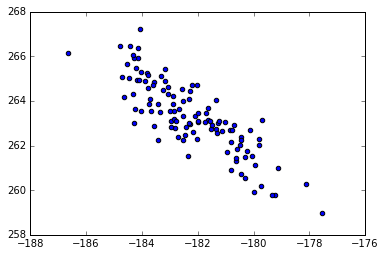

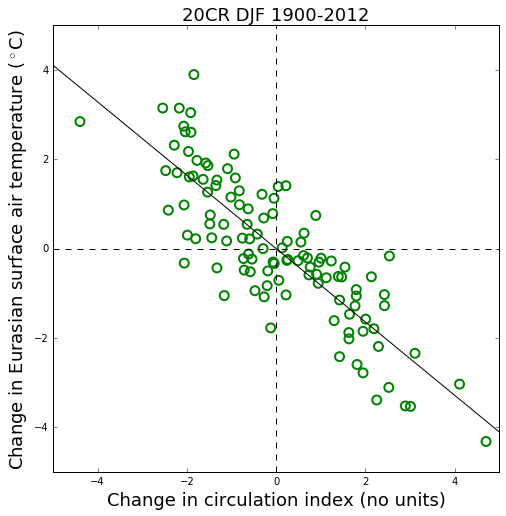

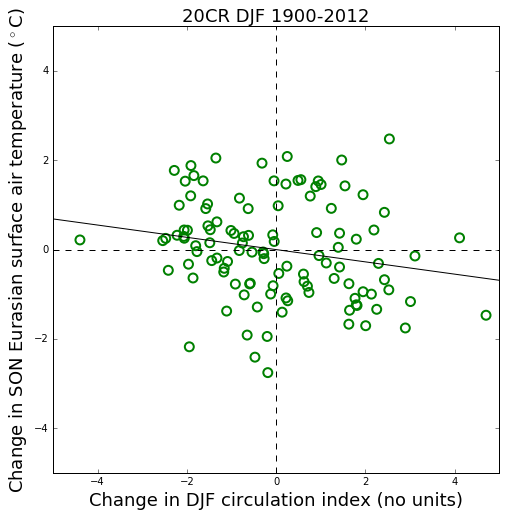

In [22]:
printtofile=False


eursatl = fldregldt['sat']['EUR']
#eursatsonl = fldregsonldt['sat']['EUR']
eursatsonl = fldregallldt['SON']['sat']['EUR']
eursatsonl = eursatsonl[:-1]

circlong = bkszl/bkszl.std() - eurzl/eurzl.std()

circindl_mm,_,circindl_r,circindl_p = cutl.regress(circlong,eursatl)
print 'raw'
print '  mm,r,p'
print circindl_mm, circindl_r,circindl_p
circindl_mmdtr,circindl_bbdtr,circindl_rdtr,circindl_pdtr = cutl.regress(cutl.detrend(circlong),cutl.detrend(eursatl))
print 'detrend'
#print circindl_rdtr,circindl_pdtr
print '  mm,r,p'
print circindl_mmdtr,circindl_rdtr,circindl_pdtr 

plt.figure()
plt.scatter(circlong,eursatl)


fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(circlong-circlong.mean(),eursatl-eursatl.mean(),
           linewidths=2,edgecolor='g',s=80, facecolors='none', marker='o')

testmm,testbb,testr,testp = cutl.regress(circlong-circlong.mean(),eursatl-eursatl.mean())

axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)

ax.set_xlabel('Change in circulation index (no units)', fontsize=fsz)
ax.set_ylabel('Change in Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
ax.set_ylim((-5,5))
ax.set_xlim((-5,5))

ax.axvline(x=0,linestyle='--',color='k')
ax.axhline(y=0,linestyle='--',color='k')
ax.set_title('20CR DJF 1900-2012', fontsize=fsz)

if printtofile:
    fig.savefig('SuppFigure_20CR_1900-2012_circidx_v_eursat_DJF_scatter.pdf')
    fig.savefig('SuppFigure_20CR_1900-2012_circidx_v_eursat_DJF_scatter.png',dpi=300)
    
    
# @@@review: add mm and r to the histogram in paper? (Supp Figure 6)

# SON ..... lag corr....
fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(circlong-circlong.mean(),eursatsonl-eursatsonl.mean(),
           linewidths=2,edgecolor='g',s=80, facecolors='none', marker='o')

testmm,testbb,testr,testp = cutl.regress(circlong-circlong.mean(),eursatsonl-eursatsonl.mean())

axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)

ax.set_xlabel('Change in DJF circulation index (no units)', fontsize=fsz)
ax.set_ylabel('Change in SON Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
ax.set_ylim((-5,5))
ax.set_xlim((-5,5))

ax.axvline(x=0,linestyle='--',color='k')
ax.axhline(y=0,linestyle='--',color='k')
ax.set_title('20CR DJF 1900-2012', fontsize=fsz)

if printtofile:
    fig.savefig('SuppFigure_20CR_1900-2012_circidxDJF_v_eursatSON_scatter.pdf')
    fig.savefig('SuppFigure_20CR_1900-2012_circidxDJF_v_eursatSON_scatter.png',dpi=300)

circindsonl_mm,_,circindsonl_r,circindsonl_p = cutl.regress(circlong,eursatsonl)
print 'SON eursat to DJF circidx raw'
print '  mm,r,p'
print circindsonl_mm, circindsonl_r,circindsonl_p
#circindsonl_mm,_,circindsonl_r,circindsonl_p = cutl.regress(eursatsonl,circlong)
#print 'FLIP SON eursat to DJF circidx raw (it is the same except slope)'
#print '  mm,r,p'
#print circindsonl_mm, circindsonl_r,circindsonl_p

circindsonl_mmdtr,circindsonl_bbdtr,circindsonl_rdtr,circindsonl_pdtr = cutl.regress(cutl.detrend(circlong),cutl.detrend(eursatsonl))
print 'SON eursat to DJF circidx detrend'
print '  mm,r,p'
print circindsonl_mmdtr,circindsonl_rdtr,circindsonl_pdtr 


In [23]:
cutl=reload(cutl)

ERAINT DJF Eurasia temp: -15.3485261949 -14.3155234996


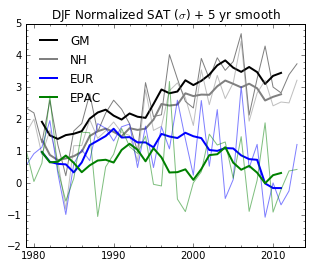

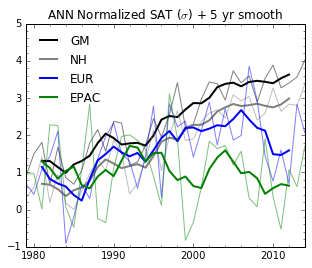

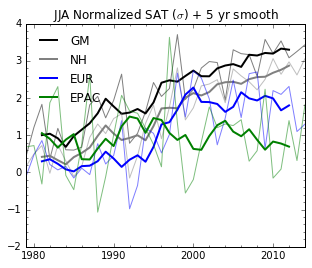

In [24]:
printtofile=False

clrs = {'GM': 'k', 'NH': '0.5', 'EUR': 'b', 'BKS': 'r', 'EPAC': 'g'}
gmlg=mlines.Line2D([],[],color=clrs['GM'],linewidth=2) 
nhlg=mlines.Line2D([],[],color=clrs['NH'],linewidth=2) 
eurlg=mlines.Line2D([],[],color=clrs['EUR'],linewidth=2) 
bkslg=mlines.Line2D([],[],color=clrs['BKS'],linewidth=2) 
paclg=mlines.Line2D([],[],color=clrs['EPAC'],linewidth=2) 


fkey='sat'
styear=1979
xx=xxdt[fkey]
window=5
xxrun = xx[window/2:-window/2+1]


doregs=('GM','NH','EUR','EPAC')
dolgs=(gmlg,nhlg,eurlg,paclg)

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,4))
for regkey in doregs:
    fldreg = fldregdt[fkey][regkey]
    #fldreg = fldreg - fldreg.mean()
    
    ax.plot(xxrun, runmean((fldreg)/np.std(fldreg),window=window),
            color=clrs[regkey],linewidth=2)
    ax.plot(xx, (fldreg)/np.std(fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)
    
fkey='sat2'
xx=xxdt[fkey]
xxrun = xx[window/2:-window/2+1]
for regkey in ('GM','NH','EUR'):
    fldreg = fldregdt[fkey][regkey]
    if regkey=='EUR': saveerats=fldreg-273
    fldreg = fldreg - fldreg.mean()# - fldregdt['sat'][regkey].mean() # @@@ fldreg.mean()
    
    #ax.plot(xxrun, runmean((fldreg)/np.std(fldreg),window=window),
    #        color=clrs[regkey],linewidth=2, linestyle='--')
    #ax.plot(xx, (fldreg)/np.std(fldreg),color=clrs[regkey],
    #        linewidth=1,alpha=0.5, linestyle='--')
# leave ERA-INT off for now
    
ax.legend(dolgs,doregs,loc='upper left',frameon=False)
ax.set_title(sea + ' Normalized SAT ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(1,len(xx),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,2014,10))

if printtofile:
    fig.savefig('SATregs_stdanom_' + sea + '_' + str(styear) + '-2014_run' + str(window)+'timeseries.pdf')
    fig.savefig('SATregs_stdanom_' + sea + '_' + str(styear) + '-2014_run' + str(window)+'timeseries.png',dpi=600)
    
    
# ANNUAL
fkey='sat'

xx=xxanndt[fkey]
xxrun = xx[window/2:-window/2+1]

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,4))
for regkey in doregs:
    fldreg = fldannregdt[fkey][regkey]
    #fldreg = fldreg - fldreg.mean()
    
    ax.plot(xxrun, runmean((fldreg)/np.std(fldreg),window=window),
            color=clrs[regkey],linewidth=2)
    ax.plot(xx, (fldreg)/np.std(fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)
    
    
ax.legend(dolgs,doregs,loc='upper left',frameon=False)
ax.set_title('ANN Normalized SAT ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(1,len(xx),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,2014,10))



# JJA
xx=xxjjadt[fkey]
xxrun = xx[window/2:-window/2+1]

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,4))
for regkey in doregs:
    fldreg = fldjjaregdt[fkey][regkey]
    #fldreg = fldreg - fldreg.mean()
    
    ax.plot(xxrun, runmean((fldreg)/np.std(fldreg),window=window),
            color=clrs[regkey],linewidth=2)
    ax.plot(xx, (fldreg)/np.std(fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)
    
    
ax.legend(dolgs,doregs,loc='upper left',frameon=False)
ax.set_title('JJA Normalized SAT ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(1,len(xx),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,2014,10))

print 'ERAINT DJF Eurasia temp: ' + str(saveerats[-10:].mean()), str(saveerats[:10].mean())




['sic', 'sat2', 'sat', 'slp', 'z500']
['NH', 'GM', 'EPAC', 'EUR', 'BKS']

timesel: 1979-01-01,2014-12-31, -1 EUR sat winters, reproduce John numbers
Stats listed as with trend, and detrended (r-val, p-val)

BKS SIC vs EUR SAT
bkssic, eursat shapes: (34,) (34,)
0.362889136614 0.0349147202372
0.338715274453 0.05005237218

EPAC SAT vs EUR SAT
0.143700373376 0.417486627728
0.117956640455 0.506435401468

FULL TIME PERIOD: CIRC IDX vs EUR SAT
circind.shape (35,)
-0.814512639487 2.62499082435e-09
-0.840055712457 2.78767931937e-10

FULL TIME PERIOD: CIRC IDX vs EUR SAT (norm by std before subtracting
-0.862802956267 2.65007535146e-11
-0.87984983751 3.38779263534e-12

FULL TIME PERIOD: CIRC IDX vs EUR SAT (remove 10-yr mean and norm by std before subtracting
-0.862802956267 2.65007535146e-11
-0.87984983751 3.38779263534e-12

2 LESS WINTERS: CIRC IDX vs EUR SAT
circind2.shape (33,)
-0.834095771 1.6473483272e-09
-0.853503068602 2.76063148687e-10

2 LESS WINTERS: CIRC IDX vs EUR SAT (norm by std b

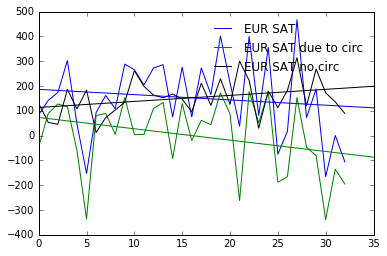

In [25]:
cutl=reload(cutl)

# NOTE, changed all the "shortening" of arrays to -1 after changed
#   timesel to be through 2014-12-31 only (instead of 2015-07-31')
#   Dec. 7, 2015


# OBS: compute correlations between the various timeseries
print fldregdt.keys()
print fldregdt['sic'].keys()

print '\ntimesel: ' + timesel + ', -1 EUR sat winters, reproduce John numbers'
print 'Stats listed as with trend, and detrended (r-val, p-val)'


# correlate: 
# =========== BKS SIC with EUR SAT
print '\nBKS SIC vs EUR SAT'
bkssic=fldregdt['sic']['BKS']
eursat=fldregdt['sat']['EUR']*100 # @@@ .nc scale factor no longer working 3/24/2016
nhsat=fldregdt['sat']['NH']*100 # @@@ .nc scale factor no longer working 3/24/2016
print 'bkssic, eursat shapes: ' + str(bkssic.shape),str(eursat[:-1].shape)

#corr = np.correlate(bkssic,eursat[:-2], mode='full')
#print corr
_,_,bkssic_r,bkssic_p = cutl.regress(bkssic,eursat[:-1])
print bkssic_r,bkssic_p
#norm gives same results as not-normed
#_,_,bkssic_rnorm,bkssic_pnorm = cutl.regress(bkssic/bkssic.std(),eursat[:-2]/eursat[:-2].std())
#print bkssic_rnorm,bkssic_pnorm
_,_,bkssic_rdtr,bkssic_pdtr = cutl.regress(cutl.detrend(bkssic),cutl.detrend(eursat[:-1]))
print bkssic_rdtr,bkssic_pdtr # reproduced john's numbers


# ========== EPAC SAT with EUR SAT
epacsat=fldregdt['sat']['EPAC']*100
_,_,epacsat_r,epacsat_p = cutl.regress(epacsat[:-1],eursat[:-1])
print '\nEPAC SAT vs EUR SAT'
print epacsat_r,epacsat_p
_,_,epacsat_rdtr,epacsat_pdtr = cutl.regress(cutl.detrend(epacsat[:-1]),cutl.detrend(eursat[:-1]))
print epacsat_rdtr,epacsat_pdtr


# ========== CIRC INDEX with EUR SAT
bksz500 = fldregdt['z500']['BKS']
eurz500 = fldregdt['z500']['EUR']
circind = fldregdt['z500']['BKS']-fldregdt['z500']['EUR']
circind_mm,_,circind_r,circind_p = cutl.regress(circind,eursat)
print '\nFULL TIME PERIOD: CIRC IDX vs EUR SAT'
print 'circind.shape ' + str(circind.shape)
print circind_r,circind_p
circind_mmdtr,_,circind_rdtr,circind_pdtr = cutl.regress(cutl.detrend(circind),cutl.detrend(eursat))
print circind_rdtr,circind_pdtr

print '\nFULL TIME PERIOD: CIRC IDX vs EUR SAT (norm by std before subtracting'
circind = bksz500/bksz500.std() - eurz500/eurz500.std() # subtracting the first 10-yr mean shouldn't change this.
circind_mm,_,circind_r,circind_p = cutl.regress(circind,eursat)
print circind_r,circind_p
circind_mmdtr,_,circind_rdtr,circind_pdtr = cutl.regress(cutl.detrend(circind),cutl.detrend(eursat))
print circind_rdtr,circind_pdtr

print '\nFULL TIME PERIOD: CIRC IDX vs EUR SAT (remove 10-yr mean and norm by std before subtracting'
circind = (bksz500-bksz500[:10].mean())/bksz500.std() - (eurz500-eurz500[:10].mean())/eurz500.std()
circind_mm,_,circind_r,circind_p = cutl.regress(circind,eursat)
print circind_r,circind_p
circind_mmdtr,_,circind_rdtr,circind_pdtr = cutl.regress(cutl.detrend(circind),cutl.detrend(eursat))
print circind_rdtr,circind_pdtr

# ====== repeat above but with 2 less winters (changed to one less winter)
# NOTE that analysis for paper related to model data would be -2 winters w/ SAT and circ, and -1 with SIC
#  Here -1 just makes SIC and circ/SAT match up. But the SIC data is even more updated than what was used in AGCM
#       which would still be -2 winters

bksz5002=bksz500[:-2] # this should match "anomaly time periods"
eurz5002=eurz500[:-2]
circind2 = bksz5002-eurz5002
eursat2=eursat[:-2]
nhsat2=nhsat[:-2]
bkssic2=bkssic[:-1]

# spatial
satsp=fldspdt['sat']
satsp2=satsp[:-2,...]
nt,nlat,nlon = satsp2.shape

circind_mm2,_,circind_r2,circind_p2 = cutl.regress(circind2,eursat2)
print '\n2 LESS WINTERS: CIRC IDX vs EUR SAT'
print 'circind2.shape ' + str(circind2.shape)

print circind_r2,circind_p2
circind_mmdtr2,_,circind_rdtr2,circind_pdtr2 = cutl.regress(cutl.detrend(circind2),cutl.detrend(eursat2))
print circind_rdtr2,circind_pdtr2

print '\n2 LESS WINTERS: CIRC IDX vs EUR SAT (norm by std before subtracting)'
circind2 = bksz5002/bksz5002.std() - eurz5002/eurz5002.std() # subtracting the first 10-yr mean shouldn't change this.
circind_mm2,_,circind_r2,circind_p2 = cutl.regress(circind2,eursat2)
print circind_r2,circind_p2
circind_mmdtr2,_,circind_rdtr2,circind_pdtr2 = cutl.regress(cutl.detrend(circind2),cutl.detrend(eursat2))
print circind_rdtr2,circind_pdtr2

# ################ compute spatial map of SAT regress on circ index in time (for Lawrence):

import numpy.ma as ma

lat=latdt['sat']
lon=londt['sat']

print '\n begin lawrence analysis'
print circind2.shape, satsp2.reshape(nt,nlat*nlon).shape


# regress spatial SAT on circulation index
circsatobs_mm,circsatobs_r,circsatobs_p = corrmap(cutl.detrend(circind2),cutl.detrend(satsp2*100).reshape(nt,nlat*nlon),dims=(nlat,nlon))
                                #satkmon.reshape((ntkmon,nlatk*nlonk)),dims=(nlatk,nlonk))
circsatobs_mmsig = ma.masked_where(circsatobs_p>0.05,circsatobs_mm)
#   these have dims of nlat x nlon

# regress EUR SAT on circulation index (done just above):
#circind_mmdtr2,_,circind_rdtr2,circind_pdtr2 = cutl.regress(cutl.detrend(circind2),cutl.detrend(eursat2))
# then circulation congruent EUR SAT can be obtained from the slope (?).
print 'EUR SAT / circ index (C/dz_std?)'
print circind_mmdtr2,circind_mmdtr2.shape

# had to subtract mean to get magnitude right
circeursatinf = circind_mmdtr2 * (circind2-circind2.mean()) #(?) units C/std in circ

xx = np.arange(0,len(eursat2))
fig,ax = plt.subplots(1,1)
ax.plot(xx,eursat2,'b')
ax.plot(xx,circeursatinf,color='g')
# then EUR SAT not congruent with circ index:
eursatnocirc = eursat2 - circeursatinf # how do I make this spatial?
ax.plot(xx,eursatnocirc,'k')
ax.legend(('EUR SAT','EUR SAT due to circ','EUR SAT no circ'),frameon=False)
cplt.add_regressline(xx,eursat2,color='b',ax=ax)
cplt.add_regressline(xx,circeursatinf,color='g',ax=ax)
cplt.add_regressline(xx,eursatnocirc,color='k',ax=ax)


# Now do that same thing spatially
# circsatobs_mm * circind2 # ValueError: operands could not be broadcast together with shapes (90,180) (33,) 

# Now regress on eursatnocirc:

(33, 90, 180) (33, 90, 180)
(33, 90, 180)


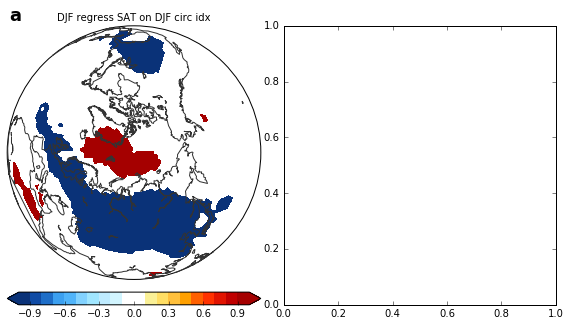

In [26]:
# @@@@@@@@@@ now regress out the circulation portion
# TODO: need circindex that is not standardized?
#     then mult mm (C/m?) by circindex (m) ?
#           this will be "inferred" SAT change due to circ idx
#
# @@@@ this is wrong. I don't know what the correct way to implement is. The inferred value still has time dimension.@@
circind2t = np.tile(circind2,(nlat,nlon,1))
circind2t = np.transpose(circind2t,(2,0,1))
circsatobs_mmt = np.tile(circsatobs_mm,(nt,1,1))
print circsatobs_mmt.shape, circind2t.shape
circsatinf = circsatobs_mmt * circind2t # this is actually C/std in circ

print circsatinf.shape


printtofile=False
seasp=sear='DJF'
ttl1=seasp + ' regress SAT on ' + sear + ' circ idx'
ttl2='inferred SAT change due to circ idx'

cminsp=-1; cmaxsp=1
cminsp2=-15; cmaxsp2=15

cmlen=15.
incr = (cmaxsp2-cminsp2) / (cmlen)
conts = np.arange(cminsp2,cmaxsp2+incr,incr)


fig,axs=plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.subplots_adjust(wspace=0.05)
ax=axs[0]
bm,pc=cplt.kemmap(circsatobs_mmsig,lat,lon,ptype='nheur',axis=ax,cmin=cminsp,cmax=cmaxsp,
                  title=ttl1,suppcb=False,
                  panellab='a',lcol='0.2') #cmin=cminsp,cmax=cmaxsp,
#bm.contour(lons,lats,z500oncircp,levels=conts,
#           colors='0.5',linewidths=1,latlon=True)#levels=conts,


ax=axs[1] # TypeError: Input z must be a 2D array.
#bm,pc=cplt.kemmap(circsatinf,lat,lon,ptype='nheur',axis=ax,
#                  title=ttl2,suppcb=False,
#                  panellab='a',lcol='0.2') #cmin=cminsp,cmax=cmaxsp,


# ################ end for Lawrence

In [27]:
print '\n2 LESS WINTERS: CIRC IDX vs EUR SAT (remove 10-yr mean and norm by std before subtracting)'
circind2 = (bksz5002-bksz5002[:10].mean())/bksz5002.std() - (eurz5002-eurz5002[:10].mean())/eurz5002.std()
circind_mm2,_,circind_r2,circind_p2 = cutl.regress(circind2,eursat2)
print circind_r2,circind_p2
circind_mmdtr2,_,circind_rdtr2,circind_pdtr2 = cutl.regress(cutl.detrend(circind2),cutl.detrend(eursat2))
print circind_rdtr2,circind_pdtr2



# ========== BKS Z500 with EUR SAT
print '\n BACK TO FULL TIMEPERIOD'
_,_,bksz500_r,bksz500_p = cutl.regress(bksz500,eursat)
print '\nBKS Z500 vs EUR SAT'
print bksz500_r,bksz500_p
_,_,bksz500_rdtr,bksz500_pdtr = cutl.regress(cutl.detrend(bksz500),cutl.detrend(eursat))
print bksz500_rdtr,bksz500_pdtr

# ========== EUR Z500 with EUR SAT
_,_,eurz500_r,eurz500_p = cutl.regress(eurz500,eursat)
print '\nEUR Z500 vs EUR SAT'
print eurz500_r,eurz500_p
_,_,eurz500_rdtr,eurz500_pdtr = cutl.regress(cutl.detrend(eurz500),cutl.detrend(eursat))
print eurz500_rdtr,eurz500_pdtr

# ========== BKS Z500 with EUR Z500
_,_,bkseurz500_r,bkseurz500_p = cutl.regress(bksz500,eurz500)
print '\nBKS Z500 vs EUR Z500'
print bkseurz500_r,bkseurz500_p
_,_,bkseurz500_rdtr,bkseurz500_pdtr = cutl.regress(cutl.detrend(bksz500),cutl.detrend(eurz500))
print bkseurz500_rdtr,bkseurz500_pdtr



# ========== CIRC INDEX with BKS SIC
_,_,circbks_r,circbks_p = cutl.regress(circind[:-1],bkssic)
print '\nCIRC IDX vs BKS SIC'
print circbks_r,circbks_p
_,_,circbks_rdtr,circbks_pdtr = cutl.regress(cutl.detrend(circind[:-1]),cutl.detrend(bkssic))
print circbks_rdtr,circbks_pdtr


# ========== BKS SIC with BKS Z500
_,_,bkssicz500_r,bkssicz500_p = cutl.regress(bkssic,bksz500[:-1])
print '\nBKS SIC vs BKS Z500'
print bkssicz500_r,bkssicz500_p
_,_,bkssicz500_rdtr,bkssicz500_pdtr = cutl.regress(cutl.detrend(bkssic),cutl.detrend(bksz500[:-1]))
print bkssicz500_rdtr,bkssicz500_pdtr


# ========== EPAC SAT with CIRC INDEX
_,_,epaccirc_r,epaccirc_p = cutl.regress(epacsat,circind)
print '\nEPAC SAT vs CIRC IDX'
print epaccirc_r,epaccirc_p
_,_,epaccirc_rdtr,epaccirc_pdtr = cutl.regress(cutl.detrend(epacsat),cutl.detrend(circind))
print epaccirc_rdtr,epaccirc_pdtr


2 LESS WINTERS: CIRC IDX vs EUR SAT (remove 10-yr mean and norm by std before subtracting)
-0.885871611392 7.27586685849e-12
-0.895359360745 2.02831061236e-12

 BACK TO FULL TIMEPERIOD

BKS Z500 vs EUR SAT
-0.682254060315 6.3634197225e-06
-0.692139429167 4.10782960856e-06

EUR Z500 vs EUR SAT
0.690565887763 4.40923610104e-06
0.682025342739 6.42691372241e-06

BKS Z500 vs EUR Z500
-0.265825725717 0.122721343169
-0.216754831192 0.211043704029

CIRC IDX vs BKS SIC
-0.535429143617 0.00110203651637
-0.433185619782 0.0104939046571

BKS SIC vs BKS Z500
-0.65669909794 2.46474336022e-05
-0.557803336425 0.000609068663769

EPAC SAT vs CIRC IDX
-0.172091018565 0.322893240243
-0.119600349231 0.493766169952


(34,) (35,)
(35,)
last endpoint 35
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.25338263485699591, 0.29774783127105908, 0.2766993811525269, 0.27026008462722151, 0.26138824663556104, 0.57754707571360853, 0.5785209373631397, 0.88230122629957963, 0.83022165977499141, 0.95646854665806647, 0.63238451301669796, 0.55091106233908738, 0.30086559770978555, 0.43227562758762639, 0.766086705395431, 0.63221021699169766, 0.21087876338264067, 0.087134816393846098, 0.24278429016404063, 0.15026934318121801, 0.14035257578795823, 0.15509112214522822, 0.22325117294604865, 0.078861963028015555, 0.05005237218003164]
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- 0.33548191472605937 -- -- -- -- -- 0.31027446169209316
 0.3387152744529466]


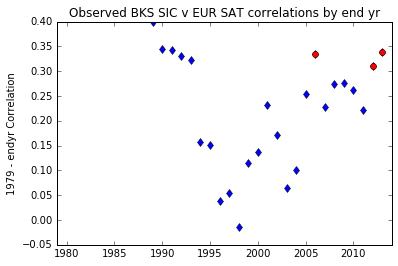

In [28]:
# look at how correlation changes with number of years
# start w/ 1979-1980
# DO FOR OBS:
import numpy.ma as ma

print bkssic.shape, eursat.shape
tmpsat = eursat #eursat[:-1]
print tmpsat.shape

ocorrs={}; opvals={}; oslopes={}
endpt=10
for yrii in np.arange(0,tmpsat.shape[0]):
    
    if yrii<10:
        oslopes[yrii]=np.nan
        ocorrs[yrii]=np.nan
        opvals[yrii]=1
    else:
        #print 'from start to ' + str(endpt)
        oslopes[yrii],_,ocorrs[yrii],opvals[yrii] = cutl.regress(cutl.detrend(bkssic[:endpt],axis=0),
                                                              cutl.detrend(tmpsat[:endpt],axis=0))
        endpt+=1

print 'last endpoint ' + str(endpt)

print opvals.values()
opv = np.array(opvals.values())


ocorrsm = ocorrs.values()
ocorrsm = ma.masked_where(opv>0.1, ocorrsm)
print ocorrsm

xxyrs = np.arange(1979,1979+len(tmpsat))

fig,ax = plt.subplots(1,1)
ax.plot(xxyrs, ocorrs.values(), linestyle='none',marker='d')
ax.set_ylabel('1979 - endyr Correlation')
ax.set_title('Observed BKS SIC v EUR SAT correlations by end yr')
ax.set_xlim((1979,2014))
ax.plot(xxyrs,ocorrsm, linestyle='none',marker='o',color='r')

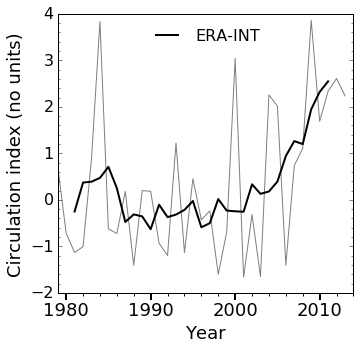

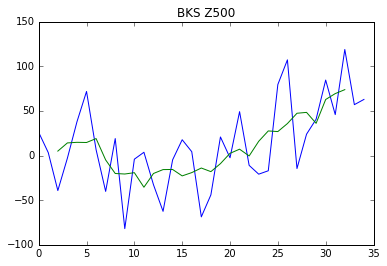

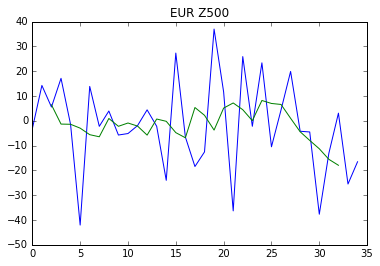

In [29]:
printtofile=False
eralg=mlines.Line2D([],[],color='k',linewidth=2) 

clrs = {'GM': 'k', 'NH': '0.5', 'EUR': 'b', 'BKS': 'r'}

fkey='z500'
styear=1979
xx=xxdt[fkey]
window=5
xxrun = xx[window/2:-window/2+1]
conv=convs[fkey]

fsz=18
fontP = fm.FontProperties()
fontP.set_size(fsz-2)

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5.3,5))
# Leave off individual components
# for regkey in ('BKS','EUR'):
#    fldreg = fldregdt[fkey][regkey]
#    fldreg = fldreg - fldreg[0:5].mean() # subtract first 5years?
    
#    ax.plot(xxrun, runmean((fldreg)/np.std(fldreg),window=window),
#            color=clrs[regkey],linewidth=2)
#    ax.plot(xx, (fldreg)/np.std(fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)

# now do the difference:
fldbks = fldregdt[fkey]['BKS']
fldbks = fldbks - fldbks[0:10].mean() # subtract first decade 1979-89 winters
fldeur = fldregdt[fkey]['EUR']
fldeur = fldeur - fldeur[0:10].mean() # subtract first decade 1979-89 winters
   
fldbks2 = fldbks[:-2] # this should match anomaly timeperiods
fldeur2 = fldeur[:-2]

ax.plot(xxrun, runmean( ((fldbks)/np.std(fldbks)) - ((fldeur)/np.std(fldeur)),window=window),
        color='k',linewidth=2)
ax.plot(xx, ((fldbks)/np.std(fldbks)) - ((fldeur)/np.std(fldeur)),
        color='k',linewidth=1, alpha=0.5)

    
ax.legend((eralg,),('ERA-INT',),loc='upper center',frameon=False,prop=fontP)
#ax.set_title(sea + ' Normalized (BKS-EUR) Z500 ($\sigma$) + ' + str(window) + ' yr smooth')
#ax.set_title('Circulation index (no units)',fontsize=fsz)
ax.set_ylabel('Circulation index (no units)',fontsize=fsz)
ax.set_xticks(np.arange(1,len(xx),10)) 

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,2014,10),fontsize=fsz)
ax.set_xlim((1979-1979,2014-1979))
ax.set_xlabel('Year',fontsize=fsz)
#ax.set_ylim((-3,5))
if printtofile:
    fig.savefig('Z500regs_stdanom_' + sea + '_' + str(styear) + '-2014_run' + str(window)+'timeseries.pdf')
    fig.savefig('Z500regs_stdanom_' + sea + '_' + str(styear) + '-2014_run' + str(window)+'timeseries.png',dpi=600)
    fig.savefig('SuppFigure_2.pdf')
    fig.savefig('SuppFigure_2.eps',dpi=600)
    fig.savefig('SuppFigure_2.jpg',dpi=600)
    
plt.figure()
plt.plot(xx,fldbks)
plt.plot(xxrun,runmean(fldbks,window=window))
plt.title('BKS Z500')

plt.figure()
plt.plot(xx,fldeur)
plt.plot(xxrun,runmean(fldeur,window=window))
plt.title('EUR Z500')    

(33,)
2 less winters. corr SLP circ idx with EUR sat (standardized before subtracting)
-0.0506014739577 0.779742839155
-0.0586841211854 0.74563843848
2 less winters. corr BKS SLP with EUR sat (standardized)
-0.762068983903 2.57070417426e-07
-0.759754621843 2.93468614793e-07


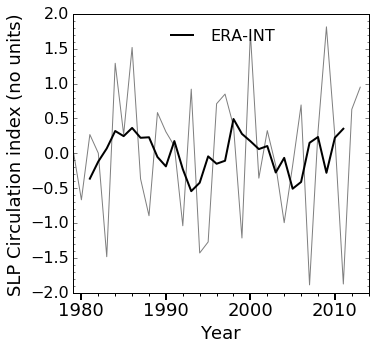

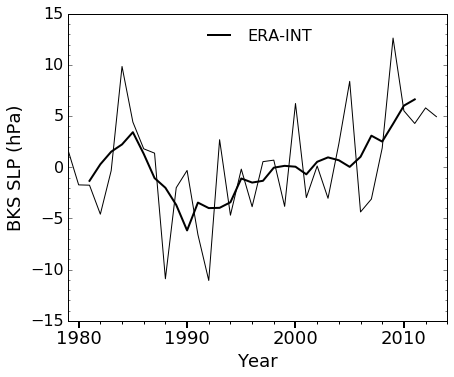

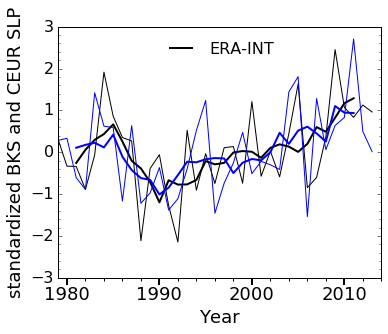

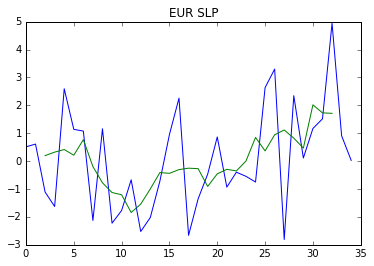

In [30]:
printtofile=False
# SLP


fkey='slp'

conv=convs[fkey]

fsz=18
fontP = fm.FontProperties()
fontP.set_size(fsz-2)

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5.3,5))
# Leave off individual components
# for regkey in ('BKS','EUR'):
#    fldreg = fldregdt[fkey][regkey]
#    fldreg = fldreg - fldreg[0:5].mean() # subtract first 5years?
    
#    ax.plot(xxrun, runmean((fldreg)/np.std(fldreg),window=window),
#            color=clrs[regkey],linewidth=2)
#    ax.plot(xx, (fldreg)/np.std(fldreg),color=clrs[regkey],linewidth=1,alpha=0.5)

# now do the difference:
fldbksp = fldregdt[fkey]['BKS']
fldbksp = fldbksp - fldbksp[0:10].mean() # subtract first decade 1979-89 winters
fldeurp = fldregdt[fkey]['EUR']
fldeurp = fldeurp - fldeurp[0:10].mean() # subtract first decade 1979-89 winters
   
fldbksp2 = fldbksp[:-2] # this should match anomaly timeperiods
fldeurp2 = fldeurp[:-2]

ax.plot(xxrun, runmean( ((fldbksp)/np.std(fldbksp)) - ((fldeurp)/np.std(fldeurp)),window=window),
        color='k',linewidth=2)
ax.plot(xx, ((fldbksp)/np.std(fldbksp)) - ((fldeurp)/np.std(fldeurp)),
        color='k',linewidth=1, alpha=0.5)

    
ax.legend((eralg,),('ERA-INT',),loc='upper center',frameon=False,prop=fontP)
#ax.set_title(sea + ' Normalized (BKS-EUR) Z500 ($\sigma$) + ' + str(window) + ' yr smooth')
#ax.set_title('Circulation index (no units)',fontsize=fsz)
ax.set_ylabel('SLP Circulation index (no units)',fontsize=fsz)
ax.set_xticks(np.arange(1,len(xx),10)) 

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,2014,10),fontsize=fsz)
ax.set_xlim((1979-1979,2014-1979))
ax.set_xlabel('Year',fontsize=fsz)
#ax.set_ylim((-3,5))


if printtofile:
    fig.savefig('SLPregs_stdanom_' + sea + '_' + str(styear) + '-2014_run' + str(window)+'timeseries.pdf')
    fig.savefig('SLPregs_stdanom_' + sea + '_' + str(styear) + '-2014_run' + str(window)+'timeseries.png',dpi=300)
#    fig.savefig('SuppFigure_2.pdf')
#    fig.savefig('SuppFigure_2.eps',dpi=600)
#    fig.savefig('SuppFigure_2.jpg',dpi=600)


# for review:
printtofile=False

fig,ax=plt.subplots(1,1)
fig.set_size_inches((6.8,5.5))
ax.plot(xx,fldbksp,'k')
ax.plot(xxrun,runmean(fldbksp,window=window),color='k',linewidth=2)
#ax.plot(xx,fldeurp,'b')
#ax.plot(xxrun,runmean(fldeurp,window=window),color='b',linewidth=2)
ax.set_ylabel('BKS SLP (hPa)',fontsize=fsz)
ax.legend((eralg,),('ERA-INT',),loc='upper center',frameon=False,prop=fontP)
ax.set_xticks(np.arange(1,len(xx),10)) 
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,2014,10),fontsize=fsz)
ax.set_xlim((1979-1979,2014-1979))
ax.set_xlabel('Year',fontsize=fsz)
if printtofile:
    fig.savefig('BKSSLP_' + sea + '_' + str(styear) + '-2014_run' + str(window)+'timeseries.pdf')
    fig.savefig('BKSSLP_' + sea + '_' + str(styear) + '-2014_run' + str(window)+'timeseries.png',dpi=300)

    
# standardized and put on same plot
fig,ax=plt.subplots(1,1)
fig.set_size_inches((5.8,4.5))
ax.plot(xx,fldbksp/fldbksp.std(),'k')
ax.plot(xxrun,runmean(fldbksp/fldbksp.std(),window=window),color='k',linewidth=2)
ax.plot(xx,fldeurp/fldeurp.std(),'b')
ax.plot(xxrun,runmean(fldeurp/fldeurp.std(),window=window),color='b',linewidth=2)
ax.set_ylabel('standardized BKS and CEUR SLP',fontsize=fsz)
ax.legend((eralg,),('ERA-INT',),loc='upper center',frameon=False,prop=fontP)
ax.set_xticks(np.arange(1,len(xx),10)) 
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,2014,10),fontsize=fsz)
ax.set_xlim((1979-1979,2014-1979))
ax.set_xlabel('Year',fontsize=fsz)
   
    
plt.figure()
plt.plot(xx,fldeurp)
plt.plot(xxrun,runmean(fldeurp,window=window))
plt.title('EUR SLP')



slpcirc = ((fldbksp)/np.std(fldbksp)) - ((fldeurp)/np.std(fldeurp))
slpcirc2 = slpcirc[:-2]
print slpcirc2.shape
fldbksp2 = fldbksp[:-2]

print '2 less winters. corr SLP circ idx with EUR sat (standardized before subtracting)'
slpcircind_mm2,_,slpcircind_r2,slpcircind_p2 = cutl.regress(slpcirc2,eursat2)
print slpcircind_r2,slpcircind_p2
slpcircind_mmdtr2,_,slpcircind_rdtr2,slpcircind_pdtr2 = cutl.regress(cutl.detrend(slpcirc2),cutl.detrend(eursat2))
print slpcircind_rdtr2,slpcircind_pdtr2


print '2 less winters. corr BKS SLP with EUR sat (standardized)'
bksslpsat_mm2,_,bksslpsat_r2,bksslpsat_p2 = cutl.regress(fldbksp2/fldbksp2.std(),eursat2)
print bksslpsat_r2,bksslpsat_p2
bksslpsat_mmdtr2,_,bksslpsat_rdtr2,bksslpsat_pdtr2 = cutl.regress(cutl.detrend(fldbksp2)/fldbksp2.std(),
                                                                  cutl.detrend(eursat2))
print bksslpsat_rdtr2,bksslpsat_pdtr2


In [31]:
# Compute the circulation index for the LE:
import loadLE as le

print timesel 

fdictbks = {'field': 'zg50000.00'+ regions['BKS'], 'ncfield': 'zg', 'comp': 'Amon'}
casename = 'historical'
conv=1/con.get_g() #convs['z500']
ledatbks = le.load_LEdata(fdictbks,casename,timesel=timesel, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)

fdicteur = {'field': 'zg50000.00'+ regions['EUR'], 'ncfield': 'zg', 'comp': 'Amon'}
ledateur = le.load_LEdata(fdicteur,casename,timesel=timesel, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)

#@@@review SLP =====
fdictbksp = {'field': 'psl'+ regions['BKS'], 'ncfield': 'psl', 'comp': 'Amon'}
casename = 'historical'
conv=convs['slp']
ledatbksp = le.load_LEdata(fdictbksp,casename,timesel=timesel, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)

fdicteurp = {'field': 'psl'+ regions['EUR'], 'ncfield': 'psl', 'comp': 'Amon'}
ledateurp = le.load_LEdata(fdicteurp,casename,timesel=timesel, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)
# @@@ ===============


fdictbkssic = {'field': 'sic'+ regions['BKS'], 'ncfield': 'sic', 'comp': 'OImon'}
conv=1 #convs['sic']
ledatbkssic = le.load_LEdata(fdictbkssic,casename,timesel=timesel, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)


fdicteursat = {'field': 'tas'+ regions['EUR'], 'ncfield': 'tas', 'comp': 'Amon'}
conv=1 #convs['sat']
ledateursat = le.load_LEdata(fdicteursat,casename,timesel=timesel, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)

fdictnhsat = {'field': 'tasnh', 'ncfield': 'tas', 'comp': 'Amon'}
conv=1 #convs['sat']
ledatnhsat = le.load_LEdata(fdictnhsat,casename,timesel=timesel, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)


1979-01-01,2014-12-31
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)
(50, 432)


(35, 50)


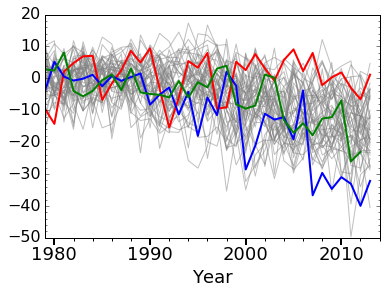

In [32]:
printtofile=False
fsz=18
styear=1979

# plot timeseries of all BKS ice
fig,ax = plt.subplots(1,1)
pltbkssic = cutl.seasonalize(ledatbkssic.T,season='DJF')
print pltbkssic.shape
bkstrends,yint = cutl.trend(pltbkssic)
#print bkstrends
maxtrendidx = np.argmax(bkstrends,axis=0)
mintrendidx = np.argmin(bkstrends, axis=0)
ax.plot(pltbkssic-pltbkssic[:10,:].mean(axis=0), color='0.5',alpha=0.5)
ax.plot(pltbkssic[:,maxtrendidx]-pltbkssic[:10,maxtrendidx].mean(axis=0),color='r',linewidth=2)
ax.plot(pltbkssic[:,mintrendidx]-pltbkssic[:10,mintrendidx].mean(axis=0),color='b',linewidth=2)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.minorticks_on()
ax.set_xticks(np.arange(1,2014-styear,10))
ax.set_xticklabels(np.arange(styear+1,2014,10),fontsize=fsz)
ax.set_xlim((1979-1979,2014-1979))
ax.set_xlabel('Year',fontsize=fsz)

if printtofile:
    fig.savefig('BKSSIC_LEminmaxtrend_timeseries_DJF.pdf')
    
ax.plot(bkssic-bkssic[:10].mean(),color='g',linewidth=2)
if printtofile:
    fig.savefig('BKSSIC_LEminmaxtrend_withOBS_timeseries_DJF.pdf')

printtofile=False

In [33]:
# get original runs for comparison w/ cmip5 calcs
fdictbks = {'field': 'zg50000.00'+ regions['BKS'], 'ncfield': 'zg', 'comp': 'Amon'}
casename = 'historical'
conv=1/con.get_g() #convs['z500']
leordatbks = le.load_LEdata(fdictbks,casename,timesel=timesel, orig='just45',
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=True)

fdicteur = {'field': 'zg50000.00'+ regions['EUR'], 'ncfield': 'zg', 'comp': 'Amon'}
leordateur = le.load_LEdata(fdicteur,casename,timesel=timesel, orig='just45',
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)



fdicteursat = {'field': 'tas'+ regions['EUR'], 'ncfield': 'tas', 'comp': 'Amon'}
conv=1 #convs['sat']
leordateursat = le.load_LEdata(fdicteursat,casename,timesel=timesel, orig='just45',
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)

orbks = cutl.seasonalize(leordatbks.T,season=sea)
oreur = cutl.seasonalize(leordateur.T,season=sea)
oreursat = cutl.seasonalize(leordateursat.T,season=sea)

orcirc = (orbks-orbks[:10,:].mean(axis=0)) / orbks.std(axis=0) -\
         (oreur-oreur[:10,:].mean(axis=0)) / oreur.std(axis=0)

print orcirc.shape

orcirceursat_mm,_,orcirceursat_r,orcirceursat_p = cutl.regress(orcirc,oreursat)
orcirceursat_mmdtr,_,orcirceursat_rdtr,orcirceursat_pdtr = cutl.regress(cutl.detrend(orcirc,axis=0),cutl.detrend(oreursat,axis=0))

print orcirceursat_mm, orcirceursat_mmdtr
print orcirceursat_r, orcirceursat_rdtr
print orcirceursat_p, orcirceursat_pdtr


/HOME/rkm/work/DATA/CanESM2/historicalrcp45/zg50000.00bksmori/zg50000.00bksmori_Amon_CanESM2_historicalrcp45_r1i1p1_185001-201212.nc
/HOME/rkm/work/DATA/CanESM2/historicalrcp45/zg50000.00bksmori/zg50000.00bksmori_Amon_CanESM2_historicalrcp45_r2i1p1_185001-201212.nc
/HOME/rkm/work/DATA/CanESM2/historicalrcp45/zg50000.00bksmori/zg50000.00bksmori_Amon_CanESM2_historicalrcp45_r3i1p1_185001-201212.nc
/HOME/rkm/work/DATA/CanESM2/historicalrcp45/zg50000.00bksmori/zg50000.00bksmori_Amon_CanESM2_historicalrcp45_r4i1p1_185001-201212.nc
/HOME/rkm/work/DATA/CanESM2/historicalrcp45/zg50000.00bksmori/zg50000.00bksmori_Amon_CanESM2_historicalrcp45_r5i1p1_185001-201212.nc
 @@ fname1 /HOME/rkm/work/DATA/CanESM2/historicalrcp45/zg50000.00bksmori/zg50000.00bksmori_Amon_CanESM2_historicalrcp45_r1i1p1_185001-201212.nc
(5, 408)
(5, 408)
(5, 408)
(5, 408)
(5, 408)
(5, 408)
(33, 5)
[-0.7394694  -0.80413869 -0.77620703 -0.74620765 -0.84828449] [-0.73443631 -0.71359925 -0.76488568 -0.65419609 -0.83258472]
[-0.8

In [34]:
lebks = cutl.seasonalize(ledatbks.T,season=sea) # z500
leeur = cutl.seasonalize(ledateur.T,season=sea) # z500
#lecirc = lebks-leeur
print lebks.shape
lecirc = (lebks-lebks[:10,:].mean(axis=0)) / lebks.std(axis=0) -\
         (leeur-leeur[:10,:].mean(axis=0)) / leeur.std(axis=0)

# shorter time period to match AGCM times
lebks2 = lebks[:-2,:]
leeur2 = leeur[:-2,:]
lecirc2 = (lebks2-lebks2[:10,:].mean(axis=0)) / lebks2.std(axis=0) -\
          (leeur2-leeur2[:10,:].mean(axis=0)) / leeur2.std(axis=0)
lecirc2save=lecirc2
lecirc2nostd = lebks2 - leeur2
lecirc2submean = (lebks2-lebks2[:10,:].mean(axis=0)) - (leeur2-leeur2[:10,:].mean(axis=0))


lebkssic = cutl.seasonalize(ledatbkssic.T,season=sea)
leeursat = cutl.seasonalize(ledateursat.T,season=sea)
lenhsat = cutl.seasonalize(ledatnhsat.T,season=sea)

leeursat2=leeursat[:-2,:]
lenhsat2=lenhsat[:-2,:]
lebkssic2=lebkssic[:-2,:]

print lecirc2.shape
print leeursat2.shape


# REPEAT WITH SLP @@@review
lebksp = cutl.seasonalize(ledatbksp.T,season=sea) # SLP
leeurp = cutl.seasonalize(ledateurp.T,season=sea) # SLP

print lebksp.shape
lecircp = (lebksp-lebksp[:10,:].mean(axis=0)) / lebksp.std(axis=0) -\
         (leeurp-leeurp[:10,:].mean(axis=0)) / leeurp.std(axis=0)

# shorter time period to match AGCM times
lebksp2 = lebksp[:-2,:]
leeurp2 = leeurp[:-2,:]
lecircp2 = (lebksp2-lebksp2[:10,:].mean(axis=0)) / lebksp2.std(axis=0) -\
          (leeurp2-leeurp2[:10,:].mean(axis=0)) / leeurp2.std(axis=0)
lecircp2save=lecircp2
lecircp2nostd = lebksp2 - leeurp2
lecircp2submean = (lebksp2-lebksp2[:10,:].mean(axis=0)) - (leeurp2-leeurp2[:10,:].mean(axis=0))



(35, 50)
(33, 50)
(33, 50)
(35, 50)


[]
===== mean 44.1701089455 sigma 0.574211221726
[ 0.]
===== mean 1.30521862725 sigma 0.647034376859
[ 0.]
mean adjusted SAT diff 44.1701089455


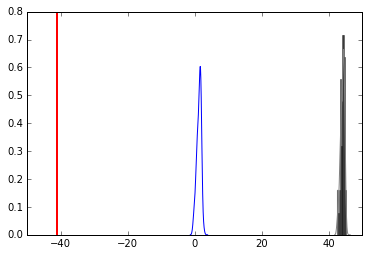

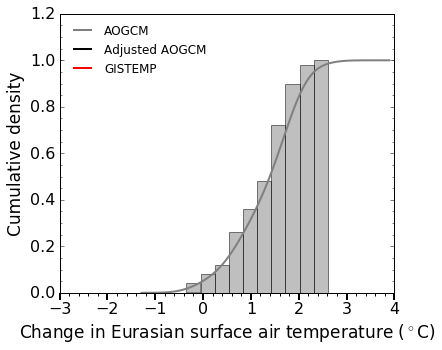

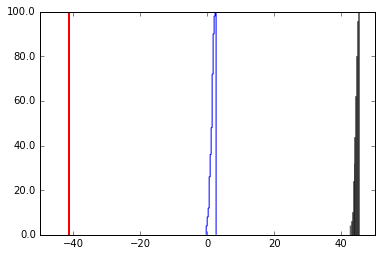

In [35]:
# test EUR sat w/o NH bias
#   and add back obs anomaly
eursatdiff2 = eursat2[-10:].mean() - eursat2[:10].mean()
nhsatdiff2 = nhsat2[-10:].mean() - nhsat2[:10].mean()

leeurdiff2 = leeursat2[-10:,:].mean(axis=0) - leeursat2[:10,:].mean(axis=0)
lenhdiff2 = lenhsat2[-10:,:].mean(axis=0) - lenhsat2[:10,:].mean(axis=0)
lesatdiff= (leeurdiff2-lenhdiff2) + nhsatdiff2


print lesatdiff[lesatdiff<=-0.0]
pdf,xxpdf = cutl.calc_kernel(lesatdiff)

kernel = sp.stats.gaussian_kde(lesatdiff)
print kernel(eursatdiff2)
  
pdforig,xxpdforig = cutl.calc_kernel(leeurdiff2)
kernelorig = sp.stats.gaussian_kde(leeurdiff2)
print kernelorig(eursatdiff2)


plt.figure()
plt.hist(lesatdiff, normed=True,color='0.5',alpha=0.5)
plt.axvline(eursatdiff2, linewidth=2, color='r')
plt.plot(xxpdf,pdf,color='0.5')
plt.plot(xxpdforig,pdforig,color='b')


# PAPER
printtofile=False

lelg=mlines.Line2D([],[],color='0.5',linewidth=2) 
adjlg=mlines.Line2D([],[],color='k',linewidth=2) 
obslg=mlines.Line2D([],[],color='r',linewidth=2) 

fig,ax = plt.subplots(1,1)
fig.set_size_inches(6,5)
ret = ax.hist(lesatdiff, normed=True,cumulative=True,color='k',histtype='step')
ax.axvline(eursatdiff2, linewidth=2, color='r')
ax.hist(leeurdiff2, normed=True,cumulative=True,color='0.5',alpha=0.5)#,histtype='step')
ax.plot(xxpdf,pdf.cumsum()/pdf.sum(),color='k',linewidth=2)
ax.plot(xxpdforig,pdforig.cumsum()/pdforig.sum(),color='0.5',linewidth=2)
ax.set_ylabel('Cumulative density', fontsize=fsz-1)
ax.set_xlabel('Change in Eurasian surface air temperature ($^\circ$C)',
              fontsize=fsz-1)
ax.set_xlim((-3,4))
ax.legend((lelg,adjlg,obslg), ('AOGCM', 'Adjusted AOGCM', 'GISTEMP'),
          frameon=False,loc='upper left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.minorticks_on()

if printtofile:
    fig.savefig('SuppFig_maybe.pdf')


printtofile=False
    
fig,ax = plt.subplots(1,1)
ret = ax.hist(lesatdiff, cumulative=True,color='0.5',alpha=0.5)
ax.axvline(eursatdiff2, linewidth=2, color='r')
ax.hist(leeurdiff2,cumulative=True,color='b',histtype='step')

counts = ret[0]; bins = ret[1]

yticks = ax.get_yticks()
yticklabs = yticks / 50. * 100
yticks = counts / 50. * 100
ax.set_yticklabels(yticklabs)
print 'mean adjusted SAT diff ' + str(lesatdiff.mean())




1.06555760742
-41.2096786154
(33, 50)
(33, 50)
mm, bb, r, p
-0.831381778978 0.991969157516 -0.765514077584 9.48143181914e-11
[-0.0746999782986677 -0.34458087497290535 -0.03242824978292447]
mean dz anom: -0.376781735727
mean dz anom (no std): 0.170647199165
mean dz anom (sub first decade mean): 0.170647199164
mean eur sat anom: 1.30521862725
test dz anom for significance: tstat, pval
(-4.4269829317569478, 2.4843820824083232e-05)
test dz anom (no std) for significance: tstat, pval
(0.55042961955351555, 0.58327723362144968)
test dz anom (sub first dec mean) for significance: tstat, pval
(0.58414460865032314, 0.56046526521540274)

note that these are not standardized:
lebks2.shape (33, 50)
(50,)
mean bks z500 anom: 2.13384013672
test bks Z500 anom for significance: tstat, pval
(8.3537862741163718, 4.4349694469180953e-13)
mean eur z500 anom: 1.96319293755
test eur Z500 anom for significance: tstat, pval
(14.967377934405274, 4.6322930017854051e-27)
(33, 50)
(33, 50)
mm, bb, r, p
-0.017705524

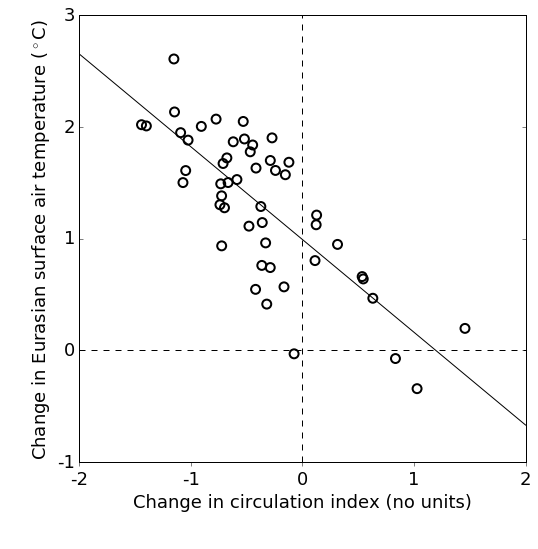

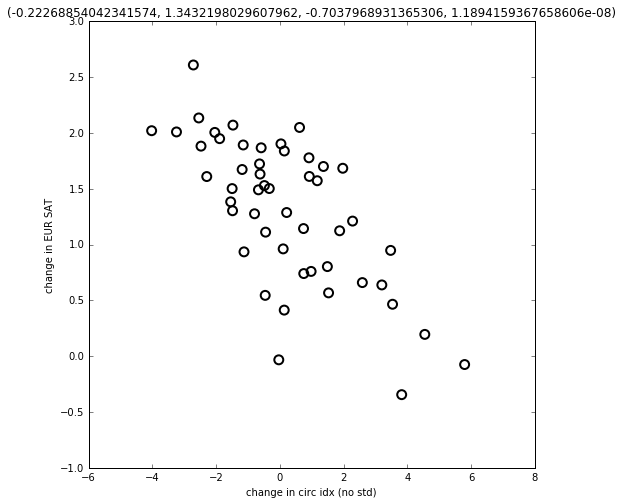

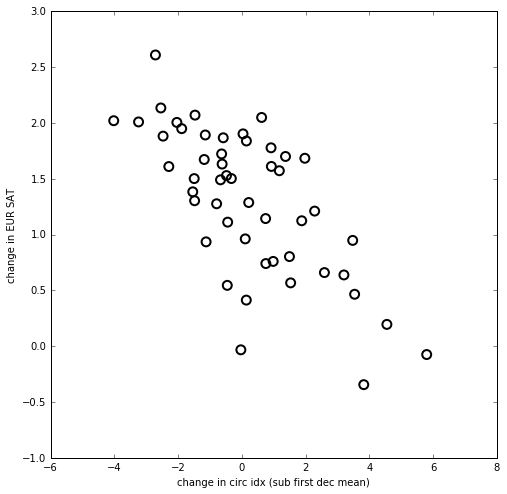

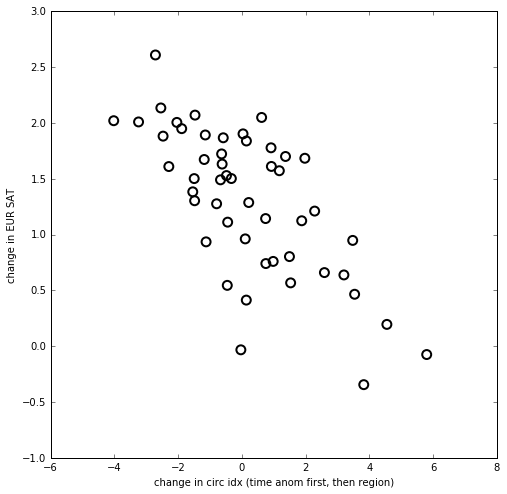

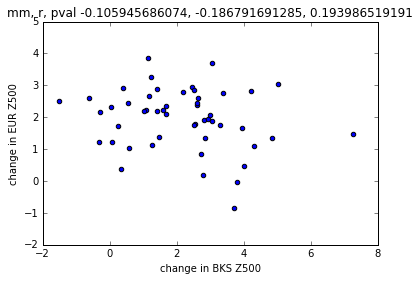

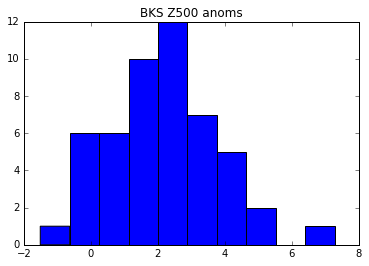

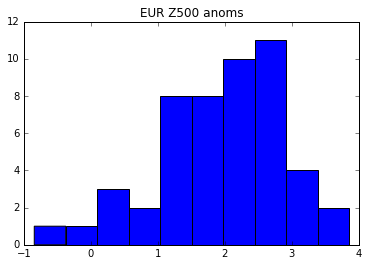

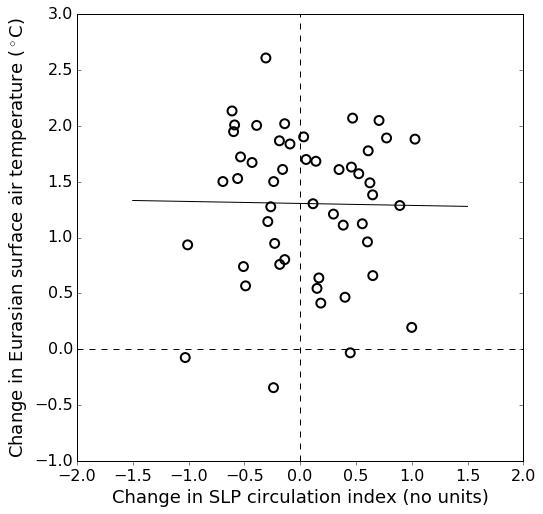

In [36]:

printtofile=False

# obs:
testobscircanom = circind2[-10:].mean() - circind2[:10].mean()
testobseuranom = eursat2[-10:].mean() - eursat2[:10].mean()
print testobscircanom
print testobseuranom

# test scatter:
testcircanom = lecirc2[-10:,:].mean(axis=0) - lecirc2[:10,:].mean(axis=0)
testcircnostdanom = lecirc2nostd[-10:,:].mean(axis=0) - lecirc2nostd[:10,:].mean(axis=0)
testcircsubmeananom = lecirc2submean[-10:,:].mean(axis=0) - lecirc2submean[:10,:].mean(axis=0)


#testeursatanom = leeursat[-12:-2,:].mean(axis=0) - leeursat[:10,:].mean(axis=0)
testeursatanom = leeursat2[-10:,:].mean(axis=0) - leeursat2[:10,:].mean(axis=0)
print leeursat2.shape
print lecirc2.shape

fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(testcircanom,testeursatanom, linewidths=2,edgecolor='k',s=80, facecolors='none', marker='o')
ax.plot(testobscircanom,testobseuranom,marker='o',markersize=9,markerfacecolor='none',color='r',markeredgewidth=2,mec='r')
ax.annotate('Obs', xy=(testobscircanom,testobseuranom), 
            xycoords='data',
            textcoords='offset points',xytext=(30,-5),
            arrowprops=dict(arrowstyle='-',
                            facecolor='r', edgecolor='r'), fontsize=fsz-2, color='r') #,connectionstyle='arc3'#xytext = (testobscircanom+.1,testobseuranom), 
ax.set_xlabel('Change in circulation index (no units)', fontsize=fsz)
ax.set_ylabel('Change in Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
ax.set_ylim((-1,3))
ax.set_xlim((-2,2))

ax.axvline(x=0,linestyle='--',color='k')
ax.axhline(y=0,linestyle='--',color='k')

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
#ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
#ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.tick_params('x',labelsize=fsz-2)

#ax.minorticks_on()
ax.set_yticks(np.arange(-1,4))
ax.set_yticklabels(np.arange(-1,4),fontsize=fsz)
ax.set_xticks(np.arange(-2,3))
ax.set_xticklabels(np.arange(-2,3),fontsize=fsz)

testmm,testbb,test_r,test_p = cutl.regress(testcircanom,testeursatanom) # mm, bb, r-val, p-val
#plt.annotate('r='+str(test_r),xy=(.7,.85),xycoords='figure fraction')

axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)

print 'mm, bb, r, p'
print testmm,testbb,test_r,test_p
if printtofile:
    fig.savefig('Figure_4_kem.pdf')
    
    

print testeursatanom[testeursatanom<0]
print 'mean dz anom: ' + str(testcircanom.mean())
print 'mean dz anom (no std): ' + str(testcircnostdanom.mean())
print 'mean dz anom (sub first decade mean): ' + str(testcircsubmeananom.mean())

print 'mean eur sat anom: ' + str(testeursatanom.mean())
print 'test dz anom for significance: tstat, pval'
print cutl.ttest_ind(lecirc2[-10:,:].mean(axis=0), lecirc2[:10,:].mean(axis=0),axis=0)
print 'test dz anom (no std) for significance: tstat, pval'
print cutl.ttest_ind(lecirc2nostd[-10:,:].mean(axis=0), lecirc2nostd[:10,:].mean(axis=0),axis=0)
print 'test dz anom (sub first dec mean) for significance: tstat, pval'
print cutl.ttest_ind(lecirc2submean[-10:,:].mean(axis=0), lecirc2submean[:10,:].mean(axis=0),axis=0)



print '\nnote that these are not standardized:'
print 'lebks2.shape ' + str(lebks2.shape)
testbkscircanom2 = lebks2[-10:,:].mean(axis=0) - lebks2[:10,:].mean(axis=0)
print testbkscircanom2.shape


# this is testing whether the ens mean of anomalies over the pert
# time period is statistically diff from ens mean of anomalies over the control
# period
print 'mean bks z500 anom: ' + str(testbkscircanom2.mean())
print 'test bks Z500 anom for significance: tstat, pval'
print cutl.ttest_ind(lebks2[-10:,:].mean(axis=0), lebks2[:10,:].mean(axis=0),axis=0)
testeurcircanom2 = leeur2[-10:,:].mean(axis=0) - leeur2[:10,:].mean(axis=0)
print 'mean eur z500 anom: ' + str(testeurcircanom2.mean())
print 'test eur Z500 anom for significance: tstat, pval'
print cutl.ttest_ind(leeur2[-10:,:].mean(axis=0), leeur2[:10,:].mean(axis=0),axis=0)

bksmineurcircanom = testbkscircanom2 - testeurcircanom2 # supposed to be orig way the index was calc'd in canesm_LE_general.py


# the 3 ways of calc'ing circ index (without standardizing) all seem to give same answer
# this is good, but it seems like maybe the calc in canesm_LE_general.py is incorrect then?
#  OR figure 4 from paper was not showing circ index but instead bks z500?
fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(testcircnostdanom,testeursatanom, linewidths=2,edgecolor='k',s=80, facecolors='none', marker='o')
ax.set_xlabel('change in circ idx (no std)')
ax.set_ylabel('change in EUR SAT')
ret_circnostd = cutl.regress(testcircnostdanom,testeursatanom) # mm, bb, r-val, p-val
ax.set_title(ret_circnostd)

fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(testcircnostdanom,testeursatanom, linewidths=2,edgecolor='k',s=80, facecolors='none', marker='o')
ax.set_xlabel('change in circ idx (sub first dec mean)')
ax.set_ylabel('change in EUR SAT')

fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(bksmineurcircanom,testeursatanom, linewidths=2,edgecolor='k',s=80, facecolors='none', marker='o')
ax.set_xlabel('change in circ idx (time anom first, then region)')
ax.set_ylabel('change in EUR SAT')


plt.figure()
plt.scatter(testbkscircanom2,testeurcircanom2)
plt.xlabel('change in BKS Z500')
plt.ylabel('change in EUR Z500')
testmm3,testbb3,test_r3,test_p3 = cutl.regress(testbkscircanom2,testeurcircanom2) # mm, bb, r-val, p-val
plt.title('mm, r, pval ' + str(testmm3) + ', ' + str(test_r3) + ', ' + str(test_p3))

plt.figure()
plt.hist(testbkscircanom2)
plt.title('BKS Z500 anoms')

plt.figure()
plt.hist(testeurcircanom2)
plt.title('EUR Z500 anoms')


# ===================== SLP
#  @@@review

# test scatter:
testcircpanom = lecircp2[-10:,:].mean(axis=0) - lecircp2[:10,:].mean(axis=0)
testcircpnostdanom = lecircp2nostd[-10:,:].mean(axis=0) - lecircp2nostd[:10,:].mean(axis=0)
testcircpsubmeananom = lecircp2submean[-10:,:].mean(axis=0) - lecircp2submean[:10,:].mean(axis=0)



print leeursat2.shape
print lecircp2.shape

fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(testcircpanom,testeursatanom, linewidths=2,edgecolor='k',s=80, facecolors='none', marker='o')
#ax.plot(testobscircanom,testobseuranom,marker='o',markersize=9,markerfacecolor='none',color='r',markeredgewidth=2,mec='r')
#ax.annotate('Obs', xy=(testobscircanom,testobseuranom), 
#            xycoords='data',
#            textcoords='offset points',xytext=(30,-5),
#            arrowprops=dict(arrowstyle='-',
#                            facecolor='r', edgecolor='r'), fontsize=fsz-2, color='r') #,connectionstyle='arc3'#xytext = (testobscircanom+.1,testobseuranom), 
ax.set_xlabel('Change in SLP circulation index (no units)', fontsize=fsz)
ax.set_ylabel('Change in Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
#ax.set_ylim((-1,3))
#ax.set_xlim((-2,2))

ax.axvline(x=0,linestyle='--',color='k')
ax.axhline(y=0,linestyle='--',color='k')

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('y',labelsize=fsz-2)
ax.tick_params('x',labelsize=fsz-2)

#ax.set_yticks(np.arange(-1,4))
#ax.set_yticklabels(np.arange(-1,4),fontsize=fsz)
#ax.set_xticks(np.arange(-2,3))
#ax.set_xticklabels(np.arange(-2,3),fontsize=fsz)

testmm,testbb,test_r,test_p = cutl.regress(testcircpanom,testeursatanom) # mm, bb, r-val, p-val
#plt.annotate('r='+str(test_r),xy=(.7,.85),xycoords='figure fraction')

axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)

print 'mm, bb, r, p'
print testmm,testbb,test_r,test_p
if printtofile:
    fig.savefig('SLPcircidx_v_EURsat_scatter.pdf')
    fig.savefig('SLPcircidx_v_EURsat_scatter.png',dpi=300)

In [37]:
print testbkscircanom2.shape
print testeurcircanom2.shape
bksmineurcircanom = testbkscircanom2 - testeurcircanom2


(50,)
(50,)


In [38]:
# HERE do a running 3 month avg in the LE ----------------
#   JJA, JAS, ASO, SON, OND, NDJ, DJF, JFM, FMA, MAM, AMJ  # 11


# next section repeated from above for ref
#lebks = cutl.seasonalize(ledatbks.T,season=sea) # z500
#leeur = cutl.seasonalize(ledateur.T,season=sea) # z500
##lecirc = lebks-leeur
#print lebks.shape
#lecirc = (lebks-lebks[:10,:].mean(axis=0)) / lebks.std(axis=0) -\
#         (leeur-leeur[:10,:].mean(axis=0)) / leeur.std(axis=0)

## shorter time period to match AGCM times
#lebks2 = lebks[:-2,:]
#leeur2 = leeur[:-2,:]
#lecirc2 = (lebks2-lebks2[:10,:].mean(axis=0)) / lebks2.std(axis=0) -\
#          (leeur2-leeur2[:10,:].mean(axis=0)) / leeur2.std(axis=0)
#lecirc2save=lecirc2
#lecirc2nostd = lebks2 - leeur2
#lecirc2submean = (lebks2-lebks2[:10,:].mean(axis=0)) - (leeur2-leeur2[:10,:].mean(axis=0))


#lebkssic = cutl.seasonalize(ledatbkssic.T,season=sea)
#leeursat = cutl.seasonalize(ledateursat.T,season=sea)
#lenhsat = cutl.seasonalize(ledatnhsat.T,season=sea)

#leeursat2=leeursat[:-2,:]


# these are ensemble x running month x running month (calc done in time for e/ ens)
leleadlagsear = np.zeros((ledatbks.shape[0],len(mons)-2,len(mons)-2))
leleadlagseap = np.zeros_like(leleadlagsear)
leleadlagseadtrr = np.zeros_like(leleadlagsear)
leleadlagseadtrp = np.zeros_like(leleadlagsear)

# these are running month x running month (calc done over ens dimension)
leleadlagseaanr = np.zeros((len(mons)-2,len(mons)-2))
leleadlagseaanp = np.zeros_like(leleadlagseaanr)

for cmii,cmon in enumerate(mons[:-2]):
    
    cwgts = monwgts[cmii:cmii+3]

    print '--- cmon ' + str(cmon) 
    # compute circ        
    tmpbks = selectmonths(ledatbks.T,start=cmon,incr=3,weights=cwgts,retavg=True)
    tmpeur = selectmonths(ledateur.T,start=cmon,incr=3,weights=cwgts,retavg=True)
    tmpbks=tmpbks[:-2]     # to match anomaly period (thru 2012 only)
    tmpeur=tmpeur[:-2]
    
    for smii,smon in enumerate(mons[:-2]):

        swgts = monwgts[smii:smii+3]
        tmpcirc = tmpbks/tmpbks.std() - tmpeur/tmpeur.std()   
        tmpcircan = tmpcirc[-10:,:].mean(axis=0) - tmpcirc[0:10,:].mean(axis=0)
        
        print '----- smon ' + str(smon)

        tmpsat = selectmonths(ledateursat.T,start=smon,incr=3,weights=swgts,retavg=True)
        tmpsat=tmpsat[:-2]
        tmpsatan = tmpsat[-10:,:].mean(axis=0) - tmpsat[0:10,:].mean(axis=0)
        
        if cmon<10 and smon>=10: # if one sea is into next yr (ie sea start w/ N), reduce timeseries length
            tmpcirc = tmpcirc[:-1,:]
        if smon<10 and cmon>=10:
            tmpsat = tmpsat[:-1,:]
                    
        print '--- ' + str(tmpcirc.shape), str(tmpsat.shape)
        print '--- ' + str(tmpcircan.shape), str(tmpsatan.shape)
                
        _,_,corr_r,corr_p = cutl.regress(tmpcirc,tmpsat)
        
        leleadlagsear[:,cmii,smii] = corr_r
        leleadlagseap[:,cmii,smii] = corr_p
        
        _,_,corr_r,corr_p = cutl.regress(cutl.detrend(tmpcirc,axis=0),cutl.detrend(tmpsat,axis=0))
        
        
        leleadlagseadtrr[:,cmii,smii] = corr_r
        leleadlagseadtrp[:,cmii,smii] = corr_p
        
        _,_,corr_r,corr_p = cutl.regress(tmpcircan,tmpsatan)
        print corr_r, corr_p
        
        leleadlagseaanr[cmii,smii] = corr_r
        leleadlagseaanp[cmii,smii] = corr_p


--- cmon 5
start,nyrs,remainder 5 35 7
nyrs 36
ret.shape (36, 50)
nyrs 36, and 36
start,nyrs,remainder 5 35 7
nyrs 36
ret.shape (36, 50)
nyrs 36, and 36
----- smon 5
start,nyrs,remainder 5 35 7
nyrs 36
ret.shape (36, 50)
nyrs 36, and 36
--- (34, 50) (34, 50)
--- (50,) (50,)
-0.40950254475 0.0031462433799
----- smon 6
start,nyrs,remainder 6 35 6
nyrs 36
ret.shape (36, 50)
nyrs 36, and 36
--- (34, 50) (34, 50)
--- (50,) (50,)
-0.264555430444 0.0633672354322
----- smon 7
start,nyrs,remainder 7 35 5
nyrs 36
ret.shape (36, 50)
nyrs 36, and 36
--- (34, 50) (34, 50)
--- (50,) (50,)
-0.154856238693 0.282913658431
----- smon 8
start,nyrs,remainder 8 35 4
nyrs 36
ret.shape (36, 50)
nyrs 36, and 36
--- (34, 50) (34, 50)
--- (50,) (50,)
-0.0752653277144 0.603423929107
----- smon 9
start,nyrs,remainder 9 35 3
nyrs 36
ret.shape (36, 50)
nyrs 36, and 36
--- (34, 50) (34, 50)
--- (50,) (50,)
0.0064733057187 0.964413481228
----- smon 10
start,nyrs,remainder 10 35 2
nyrs 35
ret.shape (35, 50)
nyrs 35, a

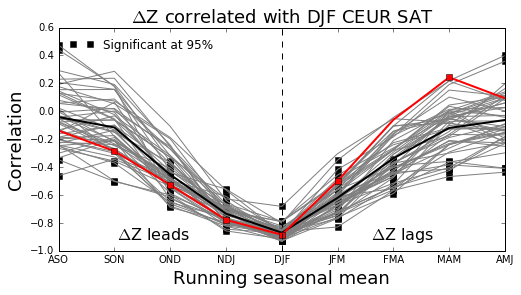

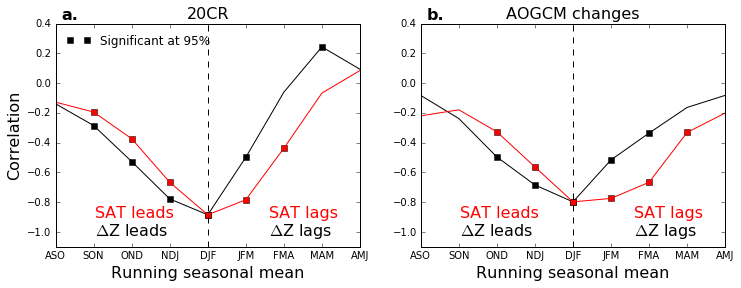

In [39]:
# plot DJF CEUR SAT corr w/ running mean circidx (for e/ ens member)
printtofile=False

leleadlagseadtrsig = ma.masked_where(leleadlagseadtrp>0.05,leleadlagseadtrr)
leleadlagseaansig = ma.masked_where(leleadlagseaanp>0.05,leleadlagseaanr)

# idx 6 is DJF
xt = [2,3,4,5,6,7,8,9,10] # JJA, ASO, OND, DJF ...

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(leleadlagseadtrsig[:,:,6].T,linestyle='none',marker='s',color='k')
ax.plot(leleadlagseadtrr[:,:,6].T,color='0.5') # this shows circ lead/lag
pltmean = leleadlagseadtrr.mean(axis=0)
ax.plot(pltmean[:,6].T,color='k',linewidth=2) # this shows circ lead/lag
ax.plot(leadlagseadtrr[:,6].T,color='r',linewidth=2) # observations
ax.plot(leadlagseadtrsig[:,6].T,color='r',linestyle='none',marker='s') # observations

#ax.plot(leleadlagseaanr[:,6].T, color='r',linewidth=2) # this one is across ensemble.

ax.set_xticks(xt)
ax.set_xticklabels(np.array(seastr)[xt])
ax.set_ylabel('Correlation',fontsize=18)
ax.set_xlabel('Running seasonal mean',fontsize=18)
ax.set_title('$\Delta$Z correlated with DJF CEUR SAT',fontsize=18)
ax.set_xlim(2,10)
ax.set_ylim((-1,.6))
ax.annotate('$\Delta$Z leads',xy=(0.13,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('$\Delta$Z lags',xy=(0.7,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.axvline(x=6,linestyle='dashed',color='k')
ax.legend(('Significant at 95%',),loc='upper left',frameon=False)
if printtofile:
    fig.savefig('LEleadlagcorr_dtr_3monrun_circ_v_DJFeursat.pdf')
    fig.savefig('LEleadlagcorr_dtr_3monrun_circ_v_DJFeursat.png')

# idx 6 is DJF
xt = [2,3,4,5,6,7,8,9,10] # JJA, ASO, OND, DJF ...

fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
ax.plot(leadlagseadtrsig[:,6],linestyle='none',marker='s',color='k')
ax.plot(leadlagseadtrr[:,6],color='k') # this shows circ lead/lag
ax.plot(leadlagseadtrsig[6,:],linestyle='none',marker='s',color='r')
ax.plot(leadlagseadtrr[6,:],color='r') # this shows sat lead/lag
ax.set_xticks(xt)
ax.set_xticklabels(np.array(seastr)[xt])
ax.set_ylabel('Correlation',fontsize=16)
ax.set_xlabel('Running seasonal mean',fontsize=16)
#ax.set_title('20CR $\delta$Z correlated with DJF CEUR SAT',fontsize=16)
ax.set_title('20CR',fontsize=16)
ax.set_xlim(2,10)
ax.set_ylim((-1.1,.4))
ax.annotate('$\Delta$Z leads',xy=(0.13,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('$\Delta$Z lags',xy=(0.7,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('SAT leads',xy=(0.13,.13),
            xycoords='axes fraction',fontsize=16,color='red')#,fontweight='bold')
ax.annotate('SAT lags',xy=(0.7,.13),
            xycoords='axes fraction',fontsize=16,color='red')#,fontweight='bold')
ax.axvline(x=6,linestyle='dashed',color='k')
ax.legend(('Significant at 95%',),loc='upper left',frameon=False)
ax.annotate('a.', xy=(.02,1.02),xycoords='axes fraction',fontsize=16,fontweight='bold')

ax=axs[1]
ax.plot(leleadlagseaansig[:,6],linestyle='none',marker='s',color='k')
ax.plot(leleadlagseaanr[:,6],color='k') # this shows circ lead/lag
ax.plot(leleadlagseaansig[6,:],linestyle='none',marker='s',color='r')
ax.plot(leleadlagseaanr[6,:],color='r') # this shows sat lead/lag
ax.set_xticks(xt)
ax.set_xticklabels(np.array(seastr)[xt])
#ax.set_ylabel('Correlation',fontsize=16)
ax.set_xlabel('Running seasonal mean',fontsize=16)
#ax.set_title('AOGCM $\delta$Z change correlated with DJF CEUR SAT change',fontsize=16)
ax.set_title('AOGCM changes',fontsize=16)
ax.set_xlim(2,10)
ax.set_ylim((-1.1,.4))
ax.annotate('$\Delta$Z leads',xy=(0.13,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('$\Delta$Z lags',xy=(0.7,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('SAT leads',xy=(0.13,.13),
            xycoords='axes fraction',fontsize=16,color='red')#,fontweight='bold')
ax.annotate('SAT lags',xy=(0.7,.13),
            xycoords='axes fraction',fontsize=16,color='red')#,fontweight='bold')
ax.annotate('b.', xy=(.02,1.02),xycoords='axes fraction',fontsize=16,fontweight='bold')
ax.axvline(x=6,linestyle='dashed',color='k')
#ax.legend(('Significant at 95%',),loc='upper left',frameon=False)
if printtofile:
    fig.savefig('20CR_LEanom_leadlagcorr_3monrun_DJFcirc_v_DJFeursat.pdf')
    fig.savefig('20CR_LEanom_leadlagcorr_3monrun_DJFcirc_v_DJFeursat.png')
 

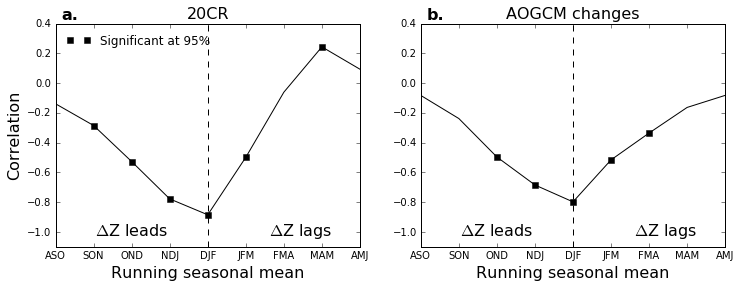

In [40]:
# ***PAPER SUPP**

printtofile=False
# idx 6 is DJF
xt = [2,3,4,5,6,7,8,9,10] # JJA, ASO, OND, DJF ...

fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
ax.plot(leadlagseadtrsig[:,6],linestyle='none',marker='s',color='k')
ax.plot(leadlagseadtrr[:,6],color='k') # this shows circ lead/lag
#ax.plot(leadlagseadtrsig[6,:],linestyle='none',marker='s',color='r')
#ax.plot(leadlagseadtrr[6,:],color='r') # this shows sat lead/lag
ax.set_xticks(xt)
ax.set_xticklabels(np.array(seastr)[xt])
ax.set_ylabel('Correlation',fontsize=16)
ax.set_xlabel('Running seasonal mean',fontsize=16)
#ax.set_title('20CR $\delta$Z correlated with DJF CEUR SAT',fontsize=16)
ax.set_title('20CR',fontsize=16)
ax.set_xlim(2,10)
ax.set_ylim((-1.1,.4))
ax.annotate('$\Delta$Z leads',xy=(0.13,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('$\Delta$Z lags',xy=(0.7,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.axvline(x=6,linestyle='dashed',color='k')
ax.legend(('Significant at 95%',),loc='upper left',frameon=False)
ax.annotate('a.', xy=(.02,1.02),xycoords='axes fraction',fontsize=16,fontweight='bold')

ax=axs[1]
ax.plot(leleadlagseaansig[:,6],linestyle='none',marker='s',color='k')
ax.plot(leleadlagseaanr[:,6],color='k') # this shows circ lead/lag
#ax.plot(leleadlagseaansig[6,:],linestyle='none',marker='s',color='r')
#ax.plot(leleadlagseaanr[6,:],color='r') # this shows sat lead/lag
ax.set_xticks(xt)
ax.set_xticklabels(np.array(seastr)[xt])
#ax.set_ylabel('Correlation',fontsize=16)
ax.set_xlabel('Running seasonal mean',fontsize=16)
#ax.set_title('AOGCM $\delta$Z change correlated with DJF CEUR SAT change',fontsize=16)
ax.set_title('AOGCM changes',fontsize=16)
ax.set_xlim(2,10)
ax.set_ylim((-1.1,.4))
ax.annotate('$\Delta$Z leads',xy=(0.13,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('$\Delta$Z lags',xy=(0.7,.05),
            xycoords='axes fraction',fontsize=16)#,fontweight='bold')
ax.annotate('b.', xy=(.02,1.02),xycoords='axes fraction',fontsize=16,fontweight='bold')
ax.axvline(x=6,linestyle='dashed',color='k')
#ax.legend(('Significant at 95%',),loc='upper left',frameon=False)
if printtofile:
    fig.savefig('20CR_LEanom_leadlagcorr_3monrun_DJFcirc.pdf')
    fig.savefig('20CR_LEanom_leadlagcorr_3monrun_DJFcirc.png',dpi=400)
    fig.savefig('20CR_LEanom_leadlagcorr_3monrun_DJFcirc.eps')
printtofile=False

In [41]:
# regressions:

print lebkssic.shape
print leeursat.shape
print lecirc.shape

lesiceursat_mm,_,lesiceursat_r,lesiceursat_p = cutl.regress(lebkssic,leeursat)
lesiceursat_mmdtr,_,lesiceursat_rdtr,lesiceursat_pdtr = cutl.regress(cutl.detrend(lebkssic,axis=0),cutl.detrend(leeursat,axis=0))

lecirceursat_mm,_,lecirceursat_r,lecirceursat_p = cutl.regress(lecirc,leeursat)
lecirceursat_mmdtr,_,lecirceursat_rdtr,lecirceursat_pdtr = cutl.regress(cutl.detrend(lecirc,axis=0),cutl.detrend(leeursat,axis=0))

leeursat2 = leeursat[:-2,:]
lecirceursat_mm2,_,lecirceursat_r2,lecirceursat_p2 = cutl.regress(lecirc2,leeursat2)
lecirceursat_mmdtr2,_,lecirceursat_rdtr2,lecirceursat_pdtr2 = cutl.regress(cutl.detrend(lecirc2,axis=0),cutl.detrend(leeursat2,axis=0))

lecircbkssic_mm,_,lecircbkssic_r,lecircbkssic_p = cutl.regress(lecirc,lebkssic)
lecircbkssic_mmdtr,_,lecircbkssic_rdtr,lecircbkssic_pdtr = cutl.regress(cutl.detrend(lecirc,axis=0),cutl.detrend(lebkssic,axis=0))

lesicbksz500_mm,_,lesicbksz500_r,lesicbksz500_p = cutl.regress(lebkssic,lebks)
lesicbksz500_mmdtr,_,lesicbksz500_rdtr,lesicbksz500_pdtr = cutl.regress(cutl.detrend(lebkssic,axis=0),cutl.detrend(lebks,axis=0))


(35, 50)
(35, 50)
(35, 50)


DJF


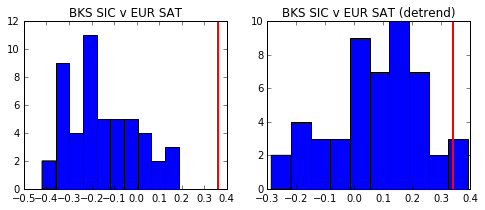

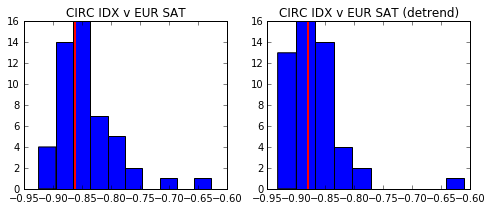

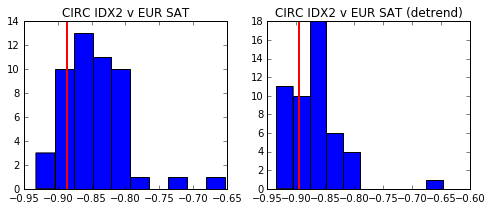

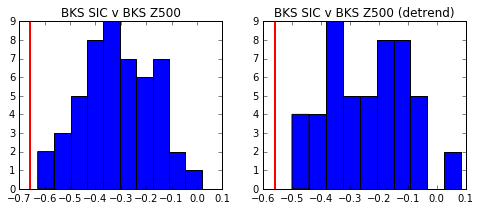

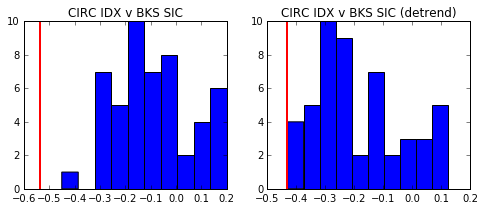

In [42]:
printtofile=False
print sea

fig,axs=plt.subplots(1,2)
fig.set_size_inches(8,3)
ax=axs[0]
ax.hist(lesiceursat_r)
ax.axvline(bkssic_r,color='r',linewidth=2)
ax.set_title('BKS SIC v EUR SAT')
#if printtofile:
#    plt.savefig('BKSSIC_EURSAT_corr_histogramLE.pdf')

ax=axs[1]
ax.hist(lesiceursat_rdtr)
ax.axvline(bkssic_rdtr,color='r',linewidth=2)
ax.set_title('BKS SIC v EUR SAT (detrend)')
if printtofile:
    fig.savefig('BKSSIC_EURSAT_corrdetrend_histogramLE_' + sea + '.pdf')


    
fig,axs=plt.subplots(1,2)
fig.set_size_inches(8,3)
ax=axs[0]
ax.hist(lecirceursat_r)
ax.axvline(circind_r,color='r',linewidth=2)
ax.set_title('CIRC IDX v EUR SAT')

ax=axs[1]
ax.hist(lecirceursat_rdtr)
ax.axvline(circind_rdtr,color='r',linewidth=2)
ax.set_title('CIRC IDX v EUR SAT (detrend)')
if printtofile:
    fig.savefig('CIRCIDX_EURSAT_corrdetrend_histogramLE_' + sea + '.pdf')

fig,axs=plt.subplots(1,2)
fig.set_size_inches(8,3)
ax=axs[0]
ax.hist(lecirceursat_r2)
ax.axvline(circind_r2,color='r',linewidth=2)
ax.set_title('CIRC IDX2 v EUR SAT')

ax=axs[1]
ax.hist(lecirceursat_rdtr2)
ax.axvline(circind_rdtr2,color='r',linewidth=2)
ax.set_title('CIRC IDX2 v EUR SAT (detrend)')
if printtofile:
    fig.savefig('CIRCIDX2_EURSAT_corrdetrend_histogramLE_' + sea + '.pdf')

fig,axs=plt.subplots(1,2)
fig.set_size_inches(8,3)
ax=axs[0]
ax.hist(lesicbksz500_r)
ax.axvline(bkssicz500_r,color='r',linewidth=2)
ax.set_title('BKS SIC v BKS Z500')

ax=axs[1]
ax.hist(lesicbksz500_rdtr)
ax.axvline(bkssicz500_rdtr,color='r',linewidth=2)
ax.set_title('BKS SIC v BKS Z500 (detrend)')
if printtofile:
    fig.savefig('BKSSIC_BKSZ500_corrdetrend_histogramLE_' + sea + '.pdf')


fig,axs=plt.subplots(1,2)
fig.set_size_inches(8,3)
ax=axs[0]
ax.hist(lecircbkssic_r)
ax.axvline(circbks_r,color='r',linewidth=2)
ax.set_title('CIRC IDX v BKS SIC')
    
#plt.figure()
ax=axs[1]
ax.hist(lecircbkssic_rdtr)
ax.axvline(circbks_rdtr,color='r',linewidth=2)
ax.set_title('CIRC IDX v BKS SIC (detrend)')
if printtofile:
    fig.savefig('CIRCIDX_BKSSIC_corrdetrend_histogramLE_' + sea + '.pdf')
    

-0.895359360745 2.02831061236e-12
[  5.53453089e-12   2.22137227e-10   4.85170488e-11   5.21841165e-10
   7.47884738e-14   6.33761103e-12   3.66367868e-12   1.01298834e-09
   1.55609522e-09   2.95359615e-11   4.29096505e-09   7.44888125e-15
   5.40800245e-09   2.46687206e-14   6.80496421e-11   2.08978609e-11
   5.46499464e-14   5.88711650e-11   1.83956264e-14   4.44590932e-11
   8.18468981e-11   2.55383323e-10   4.60473063e-11   3.72287067e-11
   1.66385514e-13   7.67184932e-10   3.21964589e-10   1.94263721e-15
   2.01183773e-10   2.91186252e-10   4.01914217e-13   1.01187520e-08
   2.57699349e-12   7.72698885e-13   5.86269723e-13   5.65620276e-11
   5.31612927e-11   8.36782187e-12   1.96761321e-13   3.72417757e-10
   5.85328235e-11   9.18422490e-12   6.02154206e-12   4.62011171e-05
   3.16083510e-08   2.77543589e-09   1.06360295e-14   1.20540124e-14
   1.92650342e-10   3.91231149e-08]


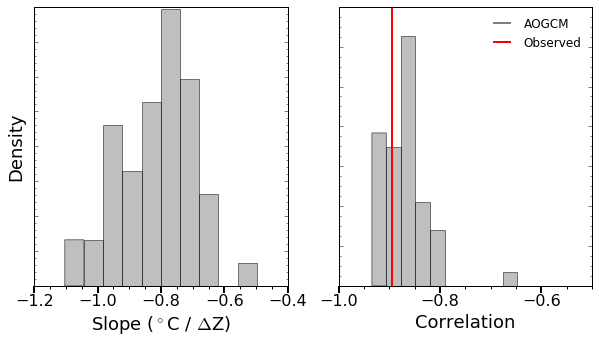

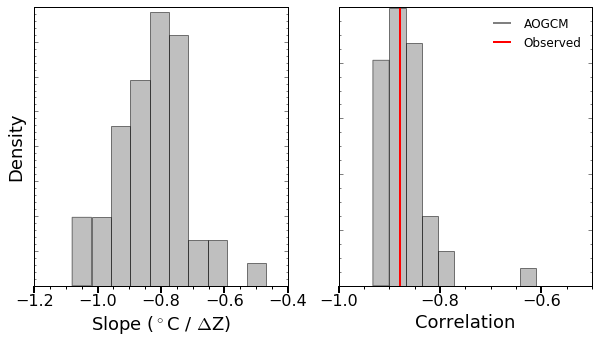

In [43]:
printtofile=False

# ==== PAPER SUPP ============
lecol='0.5'
obscol='r'
lelg=mlines.Line2D([],[],color='0.5',linewidth=2) 
obslg=mlines.Line2D([],[],color='r',linewidth=2) 

# ====== CIRC IDX2 v EUR SAT (detrend) 
fig,axs=plt.subplots(1,2)
fig.set_size_inches(10,5)
ax=axs[0]
ax.hist(lecirceursat_mmdtr2, normed=True, color=lecol, alpha=0.5)
ax.axvline(circind_mmdtr2,color=obscol,linewidth=2)
ax.set_xlabel('Slope ($^\circ$C / $\Delta$Z)', fontsize=fsz)
ax.set_ylabel('Density',fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.minorticks_on()
ax.set_xlim((-1.2,-0.4))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
ax.set_yticklabels('')


ax=axs[1]
ax.hist(lecirceursat_rdtr2, normed=True, color=lecol, alpha=0.5)
ax.axvline(circind_rdtr2,color=obscol,linewidth=2)
ax.set_xlabel('Correlation', fontsize=fsz)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.minorticks_on()
ax.set_xlim((-1.,-0.5))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
ax.set_yticklabels('')
ax.legend((lelg,obslg), ('AOGCM','Observed'),loc='upper right',frameon=False)

if printtofile:
    fig.savefig('CIRCIDX2_EURSAT_slopecorrdtrnd_histLE_' + sea + '_1979-2012.pdf')

print circind_rdtr2, circind_pdtr2
print lecirceursat_pdtr2
    
# ====== CIRC IDX v EUR SAT (detrend) 
fig,axs=plt.subplots(1,2)
fig.set_size_inches(10,5)
ax=axs[0]
ax.hist(lecirceursat_mmdtr, normed=True, color=lecol, alpha=0.5)
ax.axvline(circind_mmdtr,color=obscol,linewidth=2)
ax.set_xlabel('Slope ($^\circ$C / $\Delta$Z)', fontsize=fsz)
ax.set_ylabel('Density',fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.minorticks_on()
ax.set_xlim((-1.2,-0.4))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
ax.set_yticklabels('')


ax=axs[1]
ax.hist(lecirceursat_rdtr, normed=True, color=lecol, alpha=0.5)
ax.axvline(circind_rdtr,color=obscol,linewidth=2)
ax.set_xlabel('Correlation', fontsize=fsz)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.minorticks_on()
ax.set_xlim((-1.,-0.5))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
ax.set_yticklabels('')
ax.legend((lelg,obslg), ('AOGCM','Observed'),loc='upper right',frameon=False)

if printtofile:
    fig.savefig('CIRCIDX_EURSAT_slopecorrdtrnd_histLE_' + sea + '_1979-2014.pdf')


min, max LE corrs -0.286726425934 0.392131137431
obs corr 0.338715274453
how many corrs are sig at 95%? [ 0.01981621  0.02993399  0.04225987]
what are the sig corrs? [ 0.39213114  0.36736221  0.34519682]
how many corrs are negative (sea ice loss assoc w/ warming)[-0.25740523 -0.13185647 -0.00118086 -0.14869783 -0.07578708 -0.04110122
 -0.14914104 -0.00779099 -0.15807379 -0.16288731 -0.21240483 -0.0338797
 -0.01162383 -0.28672643 -0.20857111]
    %?
15 50
30.0%


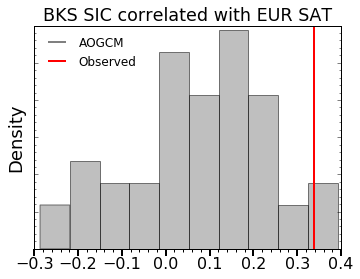

In [44]:
printtofile=False
lelg=mlines.Line2D([],[],color='0.5',linewidth=2) 
obslg=mlines.Line2D([],[],color='r',linewidth=2) 

# PAPER
fig,ax=plt.subplots(1,1)
fig.set_size_inches(5.5,4)
ax.hist(lesiceursat_rdtr,normed=True,color='0.5',alpha=0.5)
ax.axvline(bkssic_rdtr,color='r',linewidth=2)
ax.set_title('BKS SIC correlated with EUR SAT',fontsize=fsz-.5)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
#ax.tick_params('y',labelsize=fsz-2)
ax.set_ylabel('Density',fontsize=fsz)
ax.set_yticklabels('')
ax.minorticks_on()
#ax.set_xticklabels(np.arange(styear+1,2014,10),fontsize=fsz)
#ax.set_xlim((1979-1979,2014-1979))
#ax.set_ylim((-3,5))
ax.legend((lelg,obslg), ('AOGCM','Observed'),loc='upper left',frameon=False)

if printtofile:
    fig.savefig('SuppFigure_3.pdf')
    fig.savefig('SuppFigure_3.eps')
    fig.savefig('SuppFigure_3.jpg',dpi=600)

print 'min, max LE corrs ' + str(min(lesiceursat_rdtr)), str(max(lesiceursat_rdtr))
print 'obs corr ' + str(bkssic_rdtr)

print 'how many corrs are sig at 95%? ' + str(lesiceursat_pdtr[lesiceursat_pdtr<=0.05])
print 'what are the sig corrs? ' + str(lesiceursat_rdtr[lesiceursat_pdtr<=0.05])
print 'how many corrs are negative (sea ice loss assoc w/ warming)' + str(lesiceursat_rdtr[lesiceursat_rdtr<0])
print '    %?' 
print len(lesiceursat_rdtr[lesiceursat_rdtr<0]), len(lesiceursat_rdtr)
print str(len(lesiceursat_rdtr[lesiceursat_rdtr<0]) / np.float(len(lesiceursat_rdtr))*100) + '%'

(33,)
(29,)


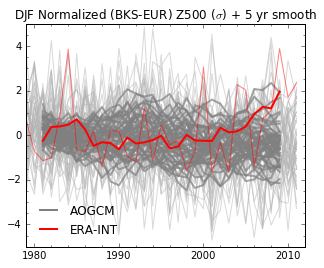

In [45]:
lelg=mlines.Line2D([],[],color='0.5',linewidth=2) 
eralg=mlines.Line2D([],[],color='r',linewidth=2) 

printtofile=False

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,4))
# Leave off individual components

# now do the difference:
endyr=2014
fldreg = lebks
fldreg2 = leeur
fldxx = xx
ofld = fldbks
ofld2 = fldeur

if 1:
    # this should match anomaly time periods
    endyr=2012
    fldreg = lebks2
    fldreg2 = leeur2
    fldxx=xx[:-2]
    ofld = fldbks2
    ofld2 = fldeur2

window=5
fldxxrun = fldxx[window/2:-window/2+1]
conv=convs[fkey]

print fldxx.shape
print fldxxrun.shape

fldreg = fldreg - fldreg[0:10,...].mean(axis=0) # subtract first 5years?
fldreg2 = fldreg2 - fldreg2[0:10,...].mean(axis=0) # subtract first 5years?
   
ax.plot(fldxx, ((fldreg)/np.std(fldreg,axis=0)) - ((fldreg2)/np.std(fldreg2,axis=0)),
        color='0.7',linewidth=1, alpha=0.5)
ax.plot(fldxxrun, runmean( ((fldreg)/np.std(fldreg,axis=0)) - ((fldreg2)/np.std(fldreg2,axis=0)),window=window),
        color='0.5',linewidth=2, alpha=0.7)
ax.plot(fldxxrun, runmean( ((ofld)/np.std(ofld)) - ((ofld2)/np.std(ofld2)),window=window),
        color='r',linewidth=2)
ax.plot(fldxx, ((ofld)/np.std(ofld)) - ((ofld2)/np.std(ofld2)),
        color='r',linewidth=1, alpha=0.5)

    
ax.legend((lelg,eralg), ('AOGCM','ERA-INT'),loc='lower left',frameon=False)
ax.set_title(sea + ' Normalized (BKS-EUR) Z500 ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(1,len(fldxx),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,endyr,10))
ax.set_ylim((-5,5))
ax.set_xlim((0,endyr-styear))
if printtofile:
    fig.savefig('Z500regsLE_stdanom_' + sea + '_' + str(styear) + '-' + str(endyr) + '_run' + str(window)+'timeseries.pdf')
    fig.savefig('Z500regsLE_stdanom_' + sea + '_' + str(styear) + '-' + str(endyr) + '_run' + str(window)+'timeseries.png',dpi=600)


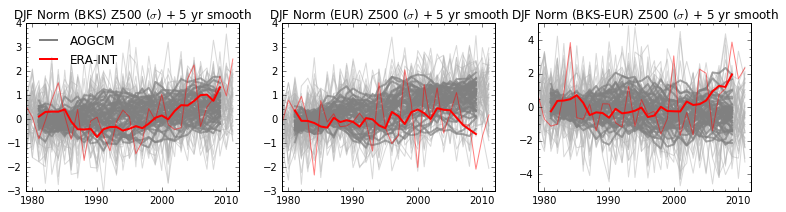

In [46]:
# JUST plot BKS Circ here:
printtofile=False

fig,axs=plt.subplots(1,3)
fig.set_size_inches((13,3))
# Leave off individual components
ax=axs[0]
endyr=2014
fldxx=xx
fldreg = lebks
fldreg2 = leeur
ofld = fldbks
ofld2 = fldeur

if 1:
    endyr=2012
    fldreg = lebks2
    fldreg2 = leeur2
    fldxx=xx[:-2]
    ofld = fldbks2
    ofld2 = fldeur2


window=5
fldxxrun = fldxx[window/2:-window/2+1]

fldreg = fldreg - fldreg[0:10,...].mean(axis=0) 
fldreg2 = fldreg2 - fldreg2[0:10,...].mean(axis=0) 


ax.plot(fldxx, ((fldreg)/np.std(fldreg,axis=0)),
        color='0.7',linewidth=1, alpha=0.5)
ax.plot(fldxxrun, runmean( ((fldreg)/np.std(fldreg,axis=0)),window=window),
        color='0.5',linewidth=2, alpha=0.7)
ax.plot(fldxxrun, runmean( ((ofld)/np.std(ofld)),window=window),
        color='r',linewidth=2)
ax.plot(fldxx, ((ofld)/np.std(ofld)),
        color='r',linewidth=1, alpha=0.5)

    
ax.legend((lelg,eralg), ('AOGCM','ERA-INT'),loc='upper left',frameon=False)
ax.set_title(sea + ' Norm (BKS) Z500 ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(1,len(fldxx),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,endyr,10))
ax.set_ylim((-3,4))
ax.set_xlim((0,endyr-styear))

ax=axs[1]
# now do the difference:

   
ax.plot(fldxx, ((fldreg2)/np.std(fldreg2,axis=0)),
        color='0.7',linewidth=1, alpha=0.5)
ax.plot(fldxxrun, runmean( ((fldreg2)/np.std(fldreg2,axis=0)),window=window),
        color='0.5',linewidth=2, alpha=0.7)
ax.plot(fldxxrun, runmean( ((ofld2)/np.std(ofld2)),window=window),
        color='r',linewidth=2)
ax.plot(fldxx, ((ofld2)/np.std(ofld2)),
        color='r',linewidth=1, alpha=0.5)

    
#ax.legend((lelg,eralg), ('AOGCM','ERA-INT'),loc='lower left',frameon=False)
ax.set_title(sea + ' Norm (EUR) Z500 ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(1,len(fldxx),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,endyr,10))
ax.set_ylim((-3,4))
ax.set_xlim((0,endyr-styear))

# now do the difference:
ax=axs[2]

ax.plot(fldxx, ((fldreg)/np.std(fldreg,axis=0)) - ((fldreg2)/np.std(fldreg2,axis=0)),
        color='0.7',linewidth=1, alpha=0.5)
ax.plot(fldxxrun, runmean( ((fldreg)/np.std(fldreg,axis=0)) - ((fldreg2)/np.std(fldreg2,axis=0)),window=window),
        color='0.5',linewidth=2, alpha=0.7)
ax.plot(fldxxrun, runmean( ((ofld)/np.std(ofld)) - ((ofld2)/np.std(ofld2)),window=window),
        color='r',linewidth=2)
ax.plot(fldxx, ((ofld)/np.std(ofld)) - ((ofld2)/np.std(ofld2)),
        color='r',linewidth=1, alpha=0.5)

    
#ax.legend((lelg,eralg), ('AOGCM','ERA-INT'),loc='lower left',frameon=False)
ax.set_title(sea + ' Norm (BKS-EUR) Z500 ($\sigma$) + ' + str(window) + ' yr smooth')
ax.set_xticks(np.arange(1,len(fldxx),10)) 
ax.minorticks_on()
ax.set_xticklabels(np.arange(styear+1,endyr,10))
ax.set_ylim((-5,5))
ax.set_xlim((0,endyr-styear))

if printtofile:
    fig.savefig('Z500regsLE_stdanom_subplot_' + sea + '_' + str(styear) + '-' + str(endyr) + '_run' + str(window)+'timeseries.pdf')
    fig.savefig('Z500regsLE_stdanom_subplot_' + sea + '_' + str(styear) + '-' + str(endyr) + '_run' + str(window)+'timeseries.png',dpi=600)


(35, 50)
(50,)
(35,)
OBS skew of circ idx (stdized)
0.627125931155
SkewtestResult(statistic=1.658661632038412, pvalue=0.097183994907812987)
OBS skew of bks z500
0.22419460069
SkewtestResult(statistic=0.61941652999498709, pvalue=0.53564199434024395)
OBS skew of eur z500
-0.182621918389
SkewtestResult(statistic=-0.505759241866652, pvalue=0.61302567428565924)
LE anom skew of circ idx
0.736791788136
SkewtestResult(statistic=2.1958613851360331, pvalue=0.028101866353584689)


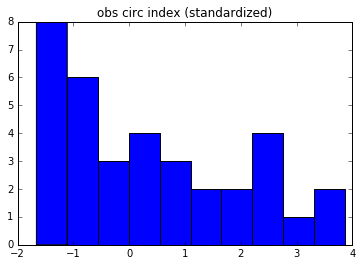

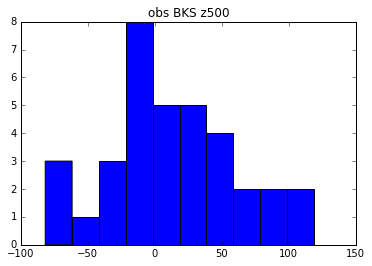

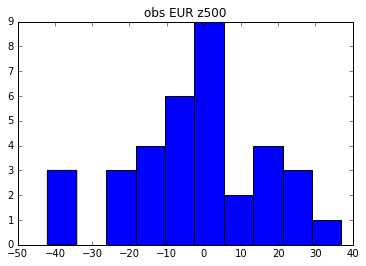

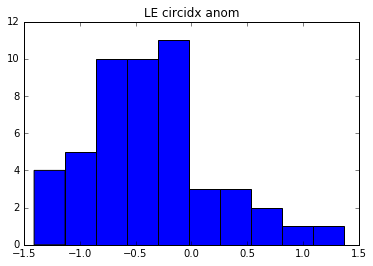

In [47]:

print lebks.shape

# LE circ index anomalies:
#  The index is officially defined as standardized, so get rid of the old version.
#lecircstd = ((lebks)/np.std(lebks,axis=0)) - ((leeur)/np.std(leeur,axis=0))
#lecirc = lebks - leeur

lecircanom = lecirc[-12:-2,:].mean(axis=0)-lecirc[:10,:].mean(axis=0)
print lecircanom.shape


print fldbks.shape # first decade mean already removed
obscircidx = ((fldbks)/np.std(fldbks)) - ((fldeur)/np.std(fldeur))

plt.figure()
plt.hist(obscircidx)
plt.title('obs circ index (standardized)')

plt.figure()
plt.hist(fldbks)
plt.title('obs BKS z500')

plt.figure()
plt.hist(fldeur)
plt.title('obs EUR z500')
 
plt.figure()
plt.hist(lecircanom)
plt.title('LE circidx anom')


print 'OBS skew of circ idx (stdized)'
print sp.stats.skew(obscircidx)
print sp.stats.skewtest(obscircidx)

print 'OBS skew of bks z500'
print sp.stats.skew(fldbks)
print sp.stats.skewtest(fldbks)

print 'OBS skew of eur z500'
print sp.stats.skew(fldeur)
print sp.stats.skewtest(fldeur)


print 'LE anom skew of circ idx'
print sp.stats.skew(lecircanom)
print sp.stats.skewtest(lecircanom)


In [48]:
# OBS
timesel2='1979-01-01,2012-12-31'
print 'OBS ' + timesel2

sea='DJF'

flddt={}; fldregdt={}; latdt={}; londt={}; xxdt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convs[fkey]
    print fname, fields[fkey], conv
    alsomask=None
    if fkey=='sic':
        alsomask='land'
        
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel2,seas=sea)*conv 
    latdt[fkey] = cnc.getNCvar(fname,'lat')
    londt[fkey] = cnc.getNCvar(fname,'lon')

    flddt[fkey] = fld

    regdt={}
    for regkey in regions.keys():
        print regkey
        regdt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                          regions[regkey],model=None,alsomask=alsomask)

    xxdt[fkey] = np.arange(0,len(regdt[regkey])) # length of last reg good for all reg in field
    fldregdt[fkey] = regdt


OBS 1979-01-01,2012-12-31
/HOME/rkm/work/BCs/NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc SICN 100
lat: squeezing data upon read all
lon: squeezing data upon read all
NH
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
GM
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
Global average!
BKS
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
EPAC
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
EUR
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
/HOME/rkm/work/DATA/ERAINT/td_era_int_197901_201507_gp_128_64_st_1979011612-2015071612.nc ST 1
lat: squeezing data upon read all
lon: squeezing data upon read all
NH
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
GM
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
Global average!
BKS
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
EPAC
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
EUR

0.0907723424886 -4.52088529476 0.310274461692 0.078861963028
detrend NORM
0.310274461692 -2.92953986094 0.310274461692 0.078861963028
normalized std?
1.0 1.0


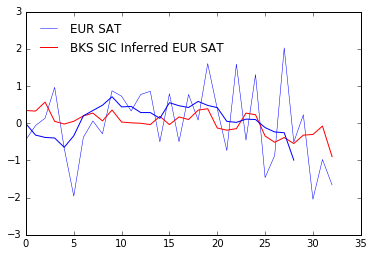

In [49]:
# Do inferred calculation:
#    Y = alpha + beta*X + residual
#    Beta = corr(X,Y) * SD(Y)/SD(X)
#   so beta is regression slope. If X and Y are standardized so they are on same scale,
#     then beta = corr (which is r)
#   
# inferred calc is: regression of BKS SIC on EUR SAT. Use beta * bks sic to get inferred EUR SAT

bkssic=fldregdt['sic']['BKS']
eursat=fldregdt['sat']['EUR']
bkssicn = (bkssic-bkssic.mean())/bkssic.std()


#mm,bb, bkssic_r,bkssic_p = cutl.regress(bkssic,eursat[:-2])
#print bkssic_r,bkssic_p
#norm gives same results as not-normed
#mmnorm,bbnorm,bkssic_rnorm,bkssic_pnorm = cutl.regress(bkssic/bkssic.std(),eursat[:-2]/eursat[:-2].std())
#print bkssic_rnorm,bkssic_pnorm
#mmdtr,bbdtr,bkssic_rdtr,bkssic_pdtr = cutl.regress(cutl.detrend(bkssic),cutl.detrend(eursat[:-2]))
mmdtr,bbdtr,bkssic_rdtr,bkssic_pdtr = cutl.regress(cutl.detrend(bkssic),cutl.detrend(eursat))
print mmdtr,bbdtr,bkssic_rdtr,bkssic_pdtr

# NORM detrend (order is wrong)
#print 'NORM detrend'
#mmdtrn,bbdtrn,bkssic_rdtrn,bkssic_pdtrn = cutl.regress(cutl.detrend(bkssic/bkssic.std()),
#                                                           cutl.detrend(eursat[:-2]/eursat[:-2].std()))
#print mmdtrn,bbdtrn,bkssic_rdtrn,bkssic_pdtrn

print 'detrend NORM'
bkssicdtr = cutl.detrend(bkssic)
eursatdtr = cutl.detrend(eursat)
bkssicdtrn = bkssicdtr/bkssicdtr.std()
eursatdtrn = eursatdtr/eursatdtr.std()

mmdtrn2,bbdtrn2,bkssic_rdtrn2,bkssic_pdtrn2 = cutl.regress(bkssicdtrn,eursatdtrn)
# no norm
mmdtr2,bbdtr2,bkssic_rdtr2,bkssic_pdtr2 = cutl.regress(bkssicdtr,eursatdtr)


print mmdtrn2,bbdtrn2,bkssic_rdtrn2,bkssic_pdtrn2
print 'normalized std?'
print bkssicdtrn.std(), eursatdtrn.std()

#eursatinf = mmdtrn2*bkssic+bbdtrn2
#eursatinf = mmdtrn2*bkssicdtrn+bbdtrn2 
eursatinf = mmdtrn2*bkssicn #+bbdtrn2
eursatraw = eursat-eursat.mean()
eursatrawshort = eursatraw #eursat[:-3]-eursat[:-3].mean() # this will match LE selection thru 2012


eursatinfnonorm = mmdtr2*bkssic

plt.figure()
plt.plot(eursatraw/eursatraw.std(),'b',linewidth=.5)
plt.plot(eursatinf,'r')#,linestyle='--')
plt.plot(runmean(eursatraw/eursatraw.std()),'b',linewidth=1)
plt.legend(('EUR SAT','BKS SIC Inferred EUR SAT'),frameon=False,loc='upper left')
#plt.plot(eursatinf/eursatinf.std(),'r')
#plt.plot(eursatinf/eursatinf.std()-(eursat[:-2]/eursat[:-2].std())[0],'r')

# for inferred: 1. detrend, 2. div by std 3. regress 4. use mm * standardized bkssic (mean removed and div by std)
# Plot with raw as: mean removed and div by std

NOW DO THROUGH 2012 ONLY ================


In [50]:
# GET THE RIGHT YEARS FOR LE
# 1D
fdictbkssic = {'field': 'sic'+ regions['BKS'], 'ncfield': 'sic', 'comp': 'OImon'}
conv=1 #convs['sic']
ledatbkssic = le.load_LEdata(fdictbkssic,casename,timesel=timesel2, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)

#1D
fdicteursat = {'field': 'tas'+ regions['EUR'], 'ncfield': 'tas', 'comp': 'Amon'}
conv=1 #convs['sat']
ledateursat = le.load_LEdata(fdicteursat,casename,timesel=timesel2, 
                   rettype='ndarray',conv=conv,ftype='fullts',local=True,verb=False)


lebkssic = cutl.seasonalize(ledatbkssic.T,season=sea)
leeursat = cutl.seasonalize(ledateursat.T,season=sea)

# regressions in time (1D)
lesiceursat_mm,_,lesiceursat_r,lesiceursat_p = cutl.regress(lebkssic,leeursat)
lesiceursat_mmdtr,_,lesiceursat_rdtr,lesiceursat_pdtr = cutl.regress(cutl.detrend(lebkssic,axis=1),cutl.detrend(leeursat,axis=1))

(50, 408)
(50, 408)
(50, 408)
(50, 408)


DJF
1979-01-01,2012-12-31
50 17
% of corrs that are negative (SIC loss assoc w/ warming) 34.0%
[ 0.05422955  0.0669761 ]
[ 0.33819057  0.32273203]
0.04


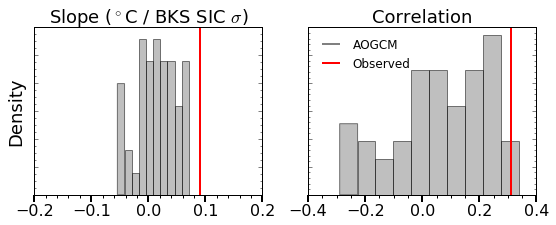

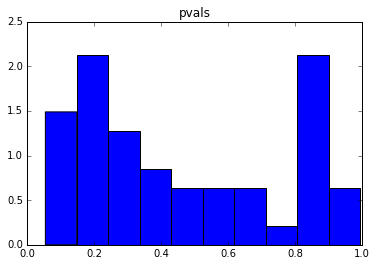

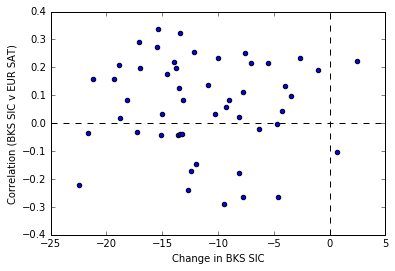

In [51]:
printtofile=False
print sea
print timesel2

fig,axs=plt.subplots(1,2)
fig.set_size_inches(9,3)
ax=axs[0]
ax.hist(lesiceursat_mmdtr, normed=True,color=lecol,alpha=0.5)
ax.axvline(mmdtr,color=obscol,linewidth=2)
#ax.set_title('BKS SIC v EUR SAT')
ax.set_title('Slope ($^\circ$C / BKS SIC $\sigma$)', fontsize=fsz)

ax.set_ylabel('Density',fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.minorticks_on()
ax.set_xlim((-.2,0.2))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
ax.set_yticklabels('')

ax=axs[1]
ax.hist(lesiceursat_rdtr, normed=True, color=lecol,alpha=0.5)
ax.axvline(bkssic_rdtr,color=obscol,linewidth=2)
#ax.set_title('BKS SIC v EUR SAT (detrend)')
ax.set_title('Correlation', fontsize=fsz)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.minorticks_on()
ax.set_xlim((-.4,0.4))
xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])
ax.set_yticklabels('')
ax.legend((lelg,obslg), ('AOGCM','Observed'),loc='upper left',frameon=False)

if printtofile:
    fig.savefig('BKSSIC_EURSAT_slopecorrdtrnd_histLE_' + sea + 'thru2012.pdf')
    
    
print len(lesiceursat_rdtr), len(lesiceursat_rdtr[lesiceursat_rdtr<0])
print '% of corrs that are negative (SIC loss assoc w/ warming) ' +\
      str(len(lesiceursat_rdtr[lesiceursat_rdtr<0]) / np.float(len(lesiceursat_rdtr))*100) + '%'
    
plt.figure()
plt.hist(lesiceursat_pdtr,normed=True)
plt.title('pvals')

print lesiceursat_pdtr[lesiceursat_pdtr<=0.1]
print lesiceursat_rdtr[lesiceursat_pdtr<=0.1]
print 2/50.

# how does the correlation relate to BKS SIC?

lebkssicanom = lebkssic[-10:,:].mean(axis=0) - lebkssic[:10,:].mean(axis=0)


fig,ax = plt.subplots(1,1)
ax.scatter(lebkssicanom,lesiceursat_rdtr)
ax.set_xlabel('Change in BKS SIC')
ax.set_ylabel('Correlation (BKS SIC v EUR SAT)')
ax.axvline(x=0,linestyle='--',color='k')
ax.axhline(y=0,linestyle='--',color='k')

In [52]:
print 'skew of BKS SIC v EUR SAT correlation pdf'
print sp.stats.skew(lesiceursat_rdtr)
print sp.stats.skewtest(lesiceursat_rdtr)
print 'obs corr: ' + str(bkssic_rdtr)

skew of BKS SIC v EUR SAT correlation pdf
-0.49983880424
SkewtestResult(statistic=-1.5480219700098523, pvalue=0.12161700704178915)
obs corr: 0.310274461692


In [53]:
# now do the le:
#print lebkssic.shape


# 1. detrend
lebkssicdtr = cutl.detrend(lebkssic,axis=0)
leeursatdtr = cutl.detrend(leeursat,axis=0)
print lebkssicdtr.shape

# 2. normalize (div by std)
#lebkssicdtrn = (lebkssicdtr / lebkssicdtr.std(axis=0))
lebkssicdtrn = ((lebkssicdtr-lebkssicdtr.mean(axis=0))) / lebkssicdtr.std(axis=0)
#leeursatdtrn = (leeursatdtr / leeursatdtr.std(axis=0))
leeursatdtrn = (leeursatdtr-leeursatdtr.mean(axis=0)) / leeursatdtr.std(axis=0)

# normalize and remove mean for mult by slope (step 4, and plot raw)
leeursatn = (leeursat-leeursat.mean(axis=0)) / leeursat.std(axis=0)
lebkssicn = (lebkssic-lebkssic.mean(axis=0)) / lebkssic.std(axis=0)

#print lebkssicdtrn.shape

# 3. regress detrended and normed timeseries
mmledtrn,bbledtrn,lesiceursat_rdtr,lesiceursat_pdtr = cutl.regress(lebkssicdtrn,
                                                                   leeursatdtrn)
# do on just detrended timeseries!
mmledtr,bbledtr,lesiceursat_rdtr,lesiceursat_pdtr = cutl.regress(lebkssicdtr,
                                                                   leeursatdtr)


#print mmledtrn.shape
#print bbledtrn
#print (mmledtrn*lebkssicdtrn).shape

# 4. calculate inferred eurasian SAT
leeursatinf = mmledtrn*lebkssicn #+ bbledtrn
leeursatinfnonorm = mmledtr*lebkssic # not on normalized values

#print leeursatinf.shape
print leeursat.shape
#print lebkssic.shape

(33, 50)
(33, 50)


100


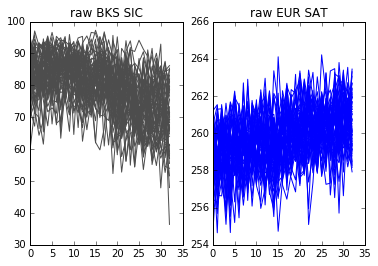

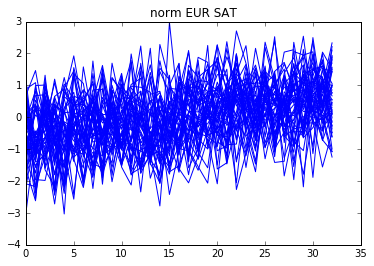

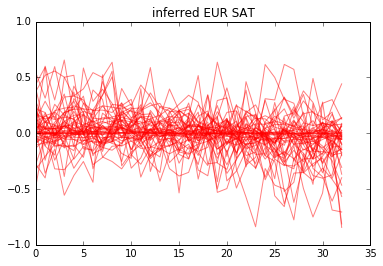

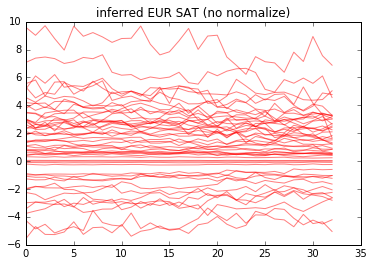

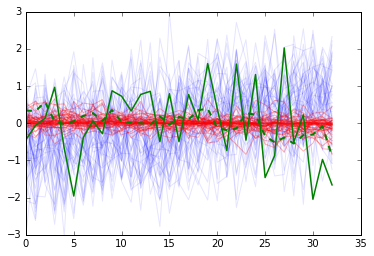

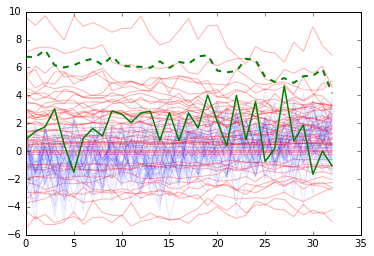

In [54]:
fig,axs=plt.subplots(1,2)
ax=axs[0]
ax.plot(lebkssic,color='0.3')
ax.set_title('raw BKS SIC')

ax=axs[1]
ax.plot(leeursat,'b')
ax.set_title('raw EUR SAT')

print convs['sic']


plt.figure()
plt.plot(leeursatn,'b')
plt.title('norm EUR SAT')

plt.figure()
plt.plot(leeursatinf,'r',linewidth=1,alpha=0.5)
plt.ylim((-1,1))
plt.title('inferred EUR SAT')


plt.figure()
plt.plot(leeursatinfnonorm,'r',linewidth=1,alpha=0.5)
#plt.ylim((-1,1))
plt.title('inferred EUR SAT (no normalize)')


plt.figure()
plt.plot(leeursatn,'b',linewidth=1,alpha=0.1)
plt.plot(leeursatinf,'r',linewidth=1,alpha=0.3)
plt.plot(eursatrawshort/eursatrawshort.std(),'g',linewidth=1.5) # obs (mean already removed)
plt.plot(eursatinf,'g',linestyle='--',linewidth=2) # obs
plt.ylim((-3,3))

plt.figure()
plt.plot(leeursat-leeursat.mean(),'b',linewidth=1,alpha=0.1) # subtract the supermean to put on same scale
plt.plot(leeursatinfnonorm,'r',linewidth=1,alpha=0.3)
plt.plot(eursat,'g',linewidth=1.5) # remember, obs is anomaly
plt.plot(eursatinfnonorm,'g',linestyle='--',linewidth=2) # obs


(33,)
bkssic.shape
(33,)
bkssic
59.8647631867 71.714996691
1979-01-01,2012-12-31
EUR SAT----
mean of inferred dist: -0.199959372067
mean of raw dist: 1.30521862725
obs anom: -0.412096786154
obs inferred anom: -1.07567345422
BKS SIC----
mean of dist: -11.2590157951
obs anom: -11.8502335043


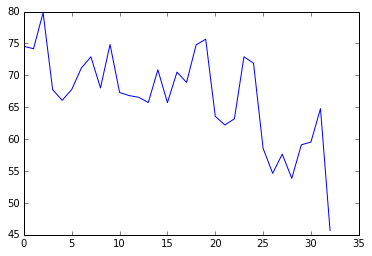

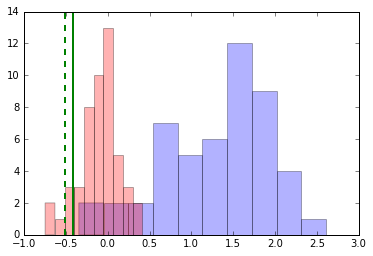

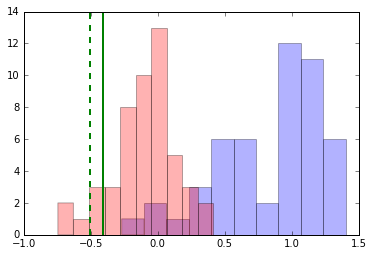

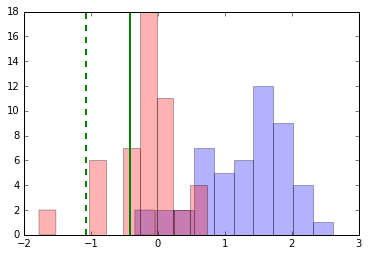

In [55]:
# @@@@@@@@@@@@@ these anomalies are not the same as what I've calc'd 
# @@@@@@@@@@@@@ previously in the paper. Note obs anom is -0.6. Should be more like -0.4
# @@@@@@@@@@@@@ Check chosen averaging indices. May be incorrect.

# now create pdf of raw EUR SAT anomalies (as in paper Fig 2b) and inferred
# first 10 and last 10 winters?
leeursatanom = leeursat[-10:,:].mean(axis=0) - leeursat[:10,:].mean(axis=0)
leeursatnanom = leeursatn[-10:,:].mean(axis=0) - leeursatn[:10,:].mean(axis=0)
lebkssicanom = lebkssic[-10:,:].mean(axis=0) - lebkssic[:10,:].mean(axis=0)

leeursatinfanom = leeursatinf[-10:,:].mean(axis=0) - leeursatinf[:10,:].mean(axis=0)
leeursatinfnonormanom = leeursatinfnonorm[-10:,:].mean(axis=0) - leeursatinfnonorm[:10,:].mean(axis=0)

print eursat.shape
#eursatanom = eursat[-12:-2].mean() - eursat[:10].mean() # CHECK need to ignore last 2?
#eursatanom = eursat[-13:-3].mean() - eursat[:10].mean() # CHECK need to ignore last 2?
#bkssicanom = bkssic[-11:-1].mean() - bkssic[:10].mean()
eursatanom = eursat[-10:].mean() - eursat[:10].mean() # CHECK need to ignore last 2?
bkssicanom = bkssic[-10:].mean() - bkssic[:10].mean()

print 'bkssic.shape'
print bkssic.shape
print 'bkssic'
print bkssic[-10:].mean(), bkssic[:10].mean()
plt.figure(); plt.plot(bkssic)

eursatinfanom = eursatinf[-10:].mean() - eursatinf[:10].mean()
eursatinfnonormanom = eursatinfnonorm[-10:].mean() - eursatinfnonorm[:10].mean()


plt.figure()
plt.hist(leeursatanom,alpha=0.3) # not quite exactly the same as fig 2b!
plt.hist(leeursatinfanom,color='r',alpha=0.3)
plt.axvline(eursatanom,color='g',linewidth=2)
plt.axvline(eursatinfanom,color='g',linestyle='--',linewidth=2)


plt.figure()
plt.hist(leeursatnanom,alpha=0.3) # normalized
plt.hist(leeursatinfanom,color='r',alpha=0.3)
plt.axvline(eursatanom,color='g',linewidth=2)
plt.axvline(eursatinfanom,color='g',linestyle='--',linewidth=2)

print timesel2

#  THIS is the right pdf for paper
print 'EUR SAT----'
print 'mean of inferred dist: ' + str(leeursatinfnonormanom.mean())
print 'mean of raw dist: ' + str(leeursatanom.mean())
print 'obs anom: ' + str(eursatanom)
print 'obs inferred anom: ' + str(eursatinfnonormanom)
print 'BKS SIC----'
print 'mean of dist: ' + str(lebkssicanom.mean())
print 'obs anom: ' + str(bkssicanom)

plt.figure()
plt.hist(leeursatanom,alpha=0.3) # not quite exactly the same as fig 2b!
plt.hist(leeursatinfnonormanom,color='r',alpha=0.3)
plt.axvline(eursatanom,color='g',linewidth=2)
plt.axvline(eursatinfnonormanom,color='g',linestyle='--',linewidth=2)


mean of inferred dist: -0.199959372067
mean of raw dist: 1.30521862725
obs anom: -0.412096786154
obs inferred anom: -1.07567345422


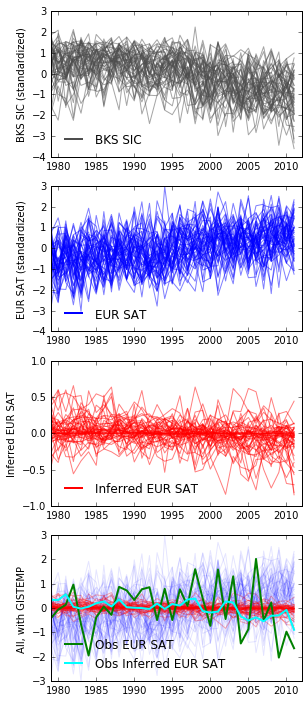

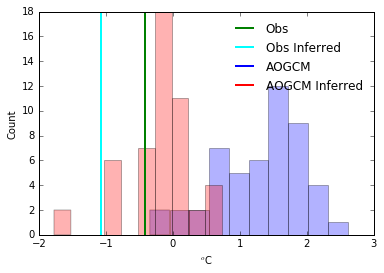

In [56]:
printtofile=False

lesiclg=mlines.Line2D([],[],color='0.3',linewidth=2) 
lesatlg=mlines.Line2D([],[],color='b',linewidth=2) 
lesatinflg=mlines.Line2D([],[],color='r',linewidth=2) 
obssatlg=mlines.Line2D([],[],color='g',linewidth=2) 
obssatinflg=mlines.Line2D([],[],color='cyan',linewidth=2) 


xx=np.arange(1979,1979+leeursatn.shape[0])
xxlim=(1979,2012)


# fig for john
fig,axs=plt.subplots(4,1)
fig.set_size_inches(4.5,12)
ax=axs[0]
#ax.plot(leeursat,'b',alpha=0.5)
#ax.set_ylabel('EUR SAT (raw)')
ax.plot(xx,lebkssicn,color='0.3',alpha=0.5)
ax.set_ylabel('BKS SIC (standardized)')
ax.set_xlim(xxlim)
ax.legend((lesiclg,),('BKS SIC',),frameon=False,loc='lower left')

ax=axs[1]
ax.plot(xx,leeursatn,'b',alpha=0.5)
ax.set_ylabel('EUR SAT (standardized)') # remove mean and div by std
ax.set_xlim(xxlim)
ax.legend((lesatlg,),('EUR SAT',),frameon=False,loc='lower left')


ax=axs[2]
ax.plot(xx,leeursatinf,'r',linewidth=1,alpha=0.5)
# leeursatinf = mmledtrn*lebkssicn 
#   where mmledtrn is from: 
#   mmledtrn,bbledtrn,lesiceursat_rdtr,lesiceursat_pdtr = cutl.regress(lebkssicdtrn,
#                                                                      leeursatdtrn)
#   regression is done on standardized timeseries
ax.set_ylim((-1,1))
ax.set_ylabel('Inferred EUR SAT')
ax.set_xlim(xxlim)
ax.legend((lesatinflg,),('Inferred EUR SAT',),frameon=False,loc='lower left')


ax=axs[3]
ax.plot(xx,leeursatn,'b',linewidth=1,alpha=0.1)
ax.plot(xx,leeursatinf,'r',linewidth=1,alpha=0.3)
ax.plot(xx,eursatrawshort/eursatrawshort.std(),color='g',linewidth=2) # obs
#ax.plot(xx,eursatinf[:-1],color='cyan',linewidth=2) # obs
ax.plot(xx,eursatinf,color='cyan',linewidth=2) # obs
ax.set_ylim((-3,3))
ax.set_xlim(xxlim)
ax.set_ylabel('All, with GISTEMP')
ax.legend((obssatlg, obssatinflg,),('Obs EUR SAT','Obs Inferred EUR SAT',),
            frameon=False,loc='lower left')

if printtofile:
    fig.savefig('EURSAT_andINFERRED_timeseries_' + sea + 'thru2012.pdf')
    

#  THIS is the right pdf for paper
print 'mean of inferred dist: ' + str(leeursatinfnonormanom.mean())
print 'mean of raw dist: ' + str(leeursatanom.mean())
print 'obs anom: ' + str(eursatanom)
print 'obs inferred anom: ' + str(eursatinfnonormanom)


fig,ax=plt.subplots(1,1)
ax.hist(leeursatanom,color='b',alpha=0.3) # not quite exactly the same as fig 2b!
ax.hist(leeursatinfnonormanom,color='r',alpha=0.3)
ax.axvline(eursatanom,color='g',linewidth=2)
ax.axvline(eursatinfnonormanom,color='cyan',linewidth=2)
ax.set_xlabel('$^o$C')
ax.set_ylabel('Count')
ax.legend((obssatlg, obssatinflg,lesatlg,lesatinflg),('Obs','Obs Inferred','AOGCM', 'AOGCM Inferred',),
            frameon=False,loc='upper right')
if printtofile:
    fig.savefig('EURSAT_andINFERRED_hist_' + sea + 'thru2012.pdf')

In [57]:
"""  compute confidence intervals on pdf

rawpdf_fitted,rawmean,rawsd,rawxx = cutl.calc_normfit(lesea) # to get mean
    rawpdf_fitted,rawxx = cutl.calc_kernel(lesea) # @@@@ kernel
    rawdf = len(lesea)-1
    rawstder = rawsd / np.sqrt(rawdf+1)
    rawci = sp.stats.t.interval(1-cisiglevel, rawdf, loc=rawmean, scale=rawstder)
    rawcif = sp.stats.t.interval(1-cisiglevel, rawdf, loc=rawmean, scale=rawsd)
    """
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


cisiglevel=0.05
siglevel=0.05

infpdf_fitted, infmean, infsd, infxx = cutl.calc_normfit(leeursatinfnonormanom)
infpdf_fitted, infxx = cutl.calc_kernel(leeursatinfnonormanom)
infdof = len(leeursatinfnonormanom)-1
infstder = infsd / np.sqrt(infdof+1)
infci = sp.stats.t.interval(1-cisiglevel, infdof, loc=infmean, scale=infstder)
infcif = sp.stats.t.interval(1-cisiglevel, infdof, loc=infmean, scale=infsd)
# is the inferred mean significantly different from 0?


rawpdf_fitted,rawmean,rawsd,rawxx = cutl.calc_normfit(leeursatanom) # to get mean
rawpdf_fitted,rawxx = cutl.calc_kernel(leeursatanom) # @@@@ kernel
rawdf = len(leeursatanom)-1
rawstder = rawsd / np.sqrt(rawdf+1)
rawci = sp.stats.t.interval(1-cisiglevel, rawdf, loc=rawmean, scale=rawstder)
rawcif = sp.stats.t.interval(1-cisiglevel, rawdf, loc=rawmean, scale=rawsd)


rawsicpdf_fitted,rawsicmean,rawsicsd,rawsicxx = cutl.calc_normfit(lebkssicanom) # to get mean
rawsicpdf_fitted,rawsicxx = cutl.calc_kernel(lebkssicanom) # @@@@ kernel
rawsicdf = len(lebkssicanom)-1
rawsicstder = rawsicsd / np.sqrt(rawsicdf+1)
rawsicci = sp.stats.t.interval(1-cisiglevel, rawsicdf, loc=rawsicmean, scale=rawsicstder)
rawsiccif = sp.stats.t.interval(1-cisiglevel, rawsicdf, loc=rawsicmean, scale=rawsicsd)


===== mean -0.199959372067 sigma 0.485394500322
===== mean -0.199959372067 sigma 0.485394500322
===== mean 1.30521862725 sigma 0.647034376859
===== mean 1.30521862725 sigma 0.647034376859
===== mean -11.2590157951 sigma 5.80970857135
===== mean -11.2590157951 sigma 5.80970857135


-11.8502335043
LE inferred hist mean -0.199959372067
pval 0.00582432966673
-0.412096786154
-1.07567345422


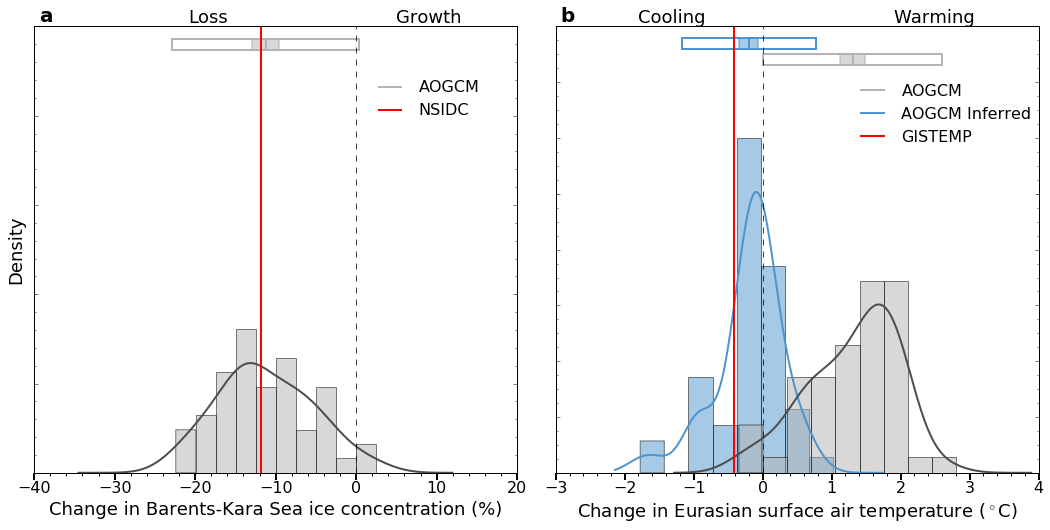

In [58]:
printtofile=False

infcol='g'
infcol=ccm.get_linecolor('steelblue3')
rawcol='0.7'
obscol='r'
fsz=18
fontP = fm.FontProperties()
fontP.set_size(fsz-2)

     
obslg=mlines.Line2D([],[],color=obscol,linewidth=2)    
rawlg=mlines.Line2D([],[],color=rawcol,linewidth=2)    
inflg=mlines.Line2D([],[],color=infcol,linewidth=2) 
    

fig,axs=plt.subplots(1,2)
fig.set_size_inches(18,8)
fig.subplots_adjust(wspace=.08)

yytop = 0.24
boxywi = 0.0032
yincr=boxywi+0.001
legloc=(0.69,0.78) 

ax=axs[0]
ax.hist(lebkssicanom,normed=True,color=rawcol,alpha=0.5)
ax.plot(rawsicxx,rawsicpdf_fitted,color='0.3',linewidth=2)

ax.axvline(x=bkssicanom,color=obscol,linewidth=2)

print bkssicanom

ax.plot((rawsicmean,rawsicmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=rawcol)
ax.add_patch(mpatches.Rectangle((rawsiccif[0],yytop-boxywi),
                                rawsiccif[1]-rawsiccif[0],boxywi*2,ec=rawcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((rawsicci[0],yytop-boxywi),
                                rawsicci[1]-rawsicci[0],boxywi*2,ec=rawcol,fc=rawcol,linewidth=2,alpha=0.5))

ax.annotate('Loss', xy=(0,1.02), xytext=(.32,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('Growth', xy=(0,1.02), xytext=(.75,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('a',xy=(0.01,1.01),xycoords='axes fraction',fontsize=fsz+2,fontweight='bold')
ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_ylim((0,0.25))
ax.set_ylabel('Density',fontsize=fsz)
ax.set_xlabel('Change in Barents-Kara Sea ice concentration (%)', fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend((rawlg,obslg),('AOGCM','NSIDC'), loc=legloc,frameon=False,prop=fontP)



ax=axs[1]
yytop = 1.54
boxywi = 0.02
yincr=boxywi+0.04
legloc=(0.61,0.78) 
binwidth=0.35

# plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
print 'LE inferred hist mean ' + str(leeursatinfnonormanom.mean())
tstat,pval = sp.stats.ttest_1samp(leeursatinfnonormanom, 0)
print 'pval ' + str(pval)

ax.hist(leeursatinfnonormanom,bins=np.arange(min(leeursatinfnonormanom), 
                                             max(leeursatinfnonormanom)+binwidth, binwidth), 
        normed=True,color=infcol,alpha=0.5)
ax.plot(infxx,infpdf_fitted,color=infcol,linewidth=2)

ax.hist(leeursatanom,bins=np.arange(min(leeursatanom), 
                                    max(leeursatanom)+binwidth, binwidth),
        normed=True,color=rawcol,alpha=0.5)
ax.plot(rawxx,rawpdf_fitted,color='0.3',linewidth=2)
print eursatanom
print eursatinfnonormanom
ax.axvline(x=eursatanom,color=obscol,linewidth=2)
#ax.axvline(x=eursatinfnonormanom,color=infcol,linewidth=2)

# uncertainty boxes
ax.plot((infmean,infmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=infcol)
ax.add_patch(mpatches.Rectangle((infcif[0],yytop-boxywi),
                                infcif[1]-infcif[0],boxywi*2,ec=infcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((infci[0],yytop-boxywi),
                                infci[1]-infci[0],boxywi*2,ec=infcol,fc=infcol,linewidth=2,alpha=0.5))

yytop-=yincr
ax.plot((rawmean,rawmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=rawcol)
ax.add_patch(mpatches.Rectangle((rawcif[0],yytop-boxywi),
                                rawcif[1]-rawcif[0],boxywi*2,ec=rawcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((rawci[0],yytop-boxywi),
                                rawci[1]-rawci[0],boxywi*2,ec=rawcol,fc=rawcol,linewidth=2,alpha=0.5))

ax.annotate('Cooling', xy=(0,1.02), xytext=(.17,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('Warming', xy=(0,1.02), xytext=(.7,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)

legloc=(0.61,0.72)
ax.annotate('b',xy=(0.01,1.01),xycoords='axes fraction',fontsize=fsz+2,fontweight='bold')
ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_xlabel('Change in Eurasian surface air temperature ($^\circ$C)',fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend((rawlg,inflg,obslg),('AOGCM','AOGCM Inferred','GISTEMP'), loc=legloc,frameon=False,prop=fontP)

if printtofile:
    fig.savefig('Figure_2_inferred2c.pdf',bbox_inches='tight')
    fig.savefig('Figure_2_inferred2c.eps',bbox_inches='tight', format='eps',dpi=600)
    
 

-11.8502335043
LE inferred hist mean -0.199959372067
pval 0.00582432966673
-0.412096786154
-1.07567345422


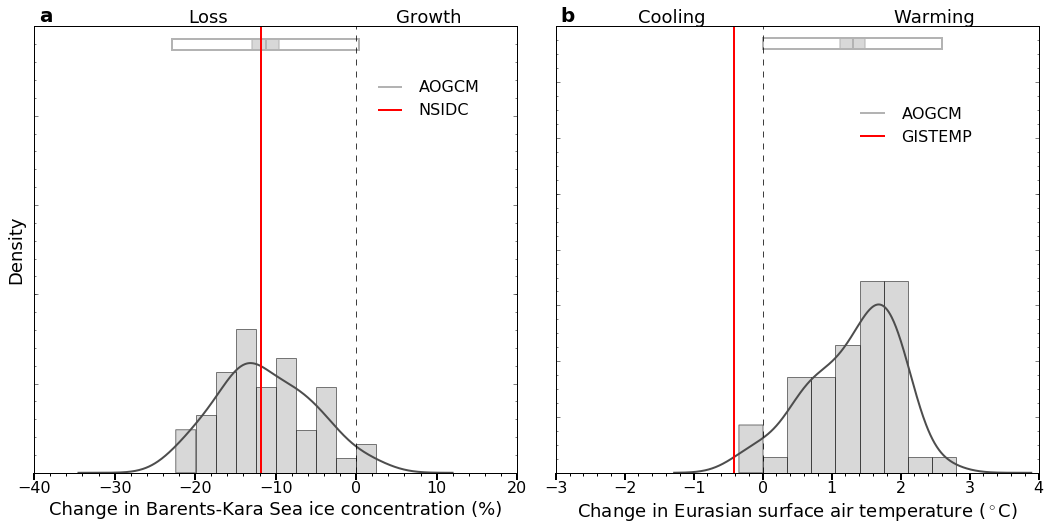

In [59]:
# SAME AS ABOVE BUT NO INFERRED TEMP
printtofile=False

infcol='g'
infcol=ccm.get_linecolor('steelblue3')
rawcol='0.7'
obscol='r'
fsz=18
fontP = fm.FontProperties()
fontP.set_size(fsz-2)

     
obslg=mlines.Line2D([],[],color=obscol,linewidth=2)    
rawlg=mlines.Line2D([],[],color=rawcol,linewidth=2)    
inflg=mlines.Line2D([],[],color=infcol,linewidth=2) 
    

fig,axs=plt.subplots(1,2)
fig.set_size_inches(18,8)
fig.subplots_adjust(wspace=.08)

yytop = 0.24
boxywi = 0.0032
yincr=boxywi+0.001
legloc=(0.69,0.78) 

ax=axs[0]
ax.hist(lebkssicanom,normed=True,color=rawcol,alpha=0.5)
ax.plot(rawsicxx,rawsicpdf_fitted,color='0.3',linewidth=2)

ax.axvline(x=bkssicanom,color=obscol,linewidth=2)

print bkssicanom

ax.plot((rawsicmean,rawsicmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=rawcol)
ax.add_patch(mpatches.Rectangle((rawsiccif[0],yytop-boxywi),
                                rawsiccif[1]-rawsiccif[0],boxywi*2,ec=rawcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((rawsicci[0],yytop-boxywi),
                                rawsicci[1]-rawsicci[0],boxywi*2,ec=rawcol,fc=rawcol,linewidth=2,alpha=0.5))

ax.annotate('Loss', xy=(0,1.02), xytext=(.32,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('Growth', xy=(0,1.02), xytext=(.75,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('a',xy=(0.01,1.01),xycoords='axes fraction',fontsize=fsz+2,fontweight='bold')
ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_ylim((0,0.25))
ax.set_ylabel('Density',fontsize=fsz)
ax.set_xlabel('Change in Barents-Kara Sea ice concentration (%)', fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend((rawlg,obslg),('AOGCM','NSIDC'), loc=legloc,frameon=False,prop=fontP)



ax=axs[1]
yytop = 1.54
boxywi = 0.02
yincr=boxywi+0.04
legloc=(0.61,0.78) 
binwidth=0.35

# plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
print 'LE inferred hist mean ' + str(leeursatinfnonormanom.mean())
tstat,pval = sp.stats.ttest_1samp(leeursatinfnonormanom, 0)
print 'pval ' + str(pval)

#ax.hist(leeursatinfnonormanom,bins=np.arange(min(leeursatinfnonormanom), 
#                                             max(leeursatinfnonormanom)+binwidth, binwidth), 
#        normed=True,color=infcol,alpha=0.5)
#ax.plot(infxx,infpdf_fitted,color=infcol,linewidth=2)

ax.hist(leeursatanom,bins=np.arange(min(leeursatanom), 
                                    max(leeursatanom)+binwidth, binwidth),
        normed=True,color=rawcol,alpha=0.5)
ax.plot(rawxx,rawpdf_fitted,color='0.3',linewidth=2)
print eursatanom
print eursatinfnonormanom
ax.axvline(x=eursatanom,color=obscol,linewidth=2)
#ax.axvline(x=eursatinfnonormanom,color=infcol,linewidth=2)

# uncertainty boxes
#ax.plot((infmean,infmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=infcol)
#ax.add_patch(mpatches.Rectangle((infcif[0],yytop-boxywi),
#                                infcif[1]-infcif[0],boxywi*2,ec=infcol,fc='white',linewidth=2))
#ax.add_patch(mpatches.Rectangle((infci[0],yytop-boxywi),
#                                infci[1]-infci[0],boxywi*2,ec=infcol,fc=infcol,linewidth=2,alpha=0.5))

#yytop-=yincr
ax.plot((rawmean,rawmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=rawcol)
ax.add_patch(mpatches.Rectangle((rawcif[0],yytop-boxywi),
                                rawcif[1]-rawcif[0],boxywi*2,ec=rawcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((rawci[0],yytop-boxywi),
                                rawci[1]-rawci[0],boxywi*2,ec=rawcol,fc=rawcol,linewidth=2,alpha=0.5))

ax.annotate('Cooling', xy=(0,1.02), xytext=(.17,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('Warming', xy=(0,1.02), xytext=(.7,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)

legloc=(0.61,0.72)
ax.annotate('b',xy=(0.01,1.01),xycoords='axes fraction',fontsize=fsz+2,fontweight='bold')
ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_xlabel('Change in Eurasian surface air temperature ($^\circ$C)',fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend((rawlg,obslg),('AOGCM','GISTEMP'), loc=legloc,frameon=False,prop=fontP)
ax.set_xlim((-3,4))
if printtofile:
    fig.savefig('Figure_2_NOinferred2c.pdf',bbox_inches='tight')
    fig.savefig('Figure_2_NOinferred2c.eps',bbox_inches='tight', format='eps',dpi=600)
    
 

In [60]:
   
# compute skew?
print 'skew (raw)'
print sp.stats.skew(leeursatanom)
print sp.stats.skewtest(leeursatanom) # returns zscore, pval
print 'skew (inferred)'
print sp.stats.skew(leeursatinfnonormanom)
print sp.stats.skewtest(leeursatinfnonormanom)





skew (raw)
-0.576526362849
SkewtestResult(statistic=-1.7651834456806363, pvalue=0.077532939886635066)
skew (inferred)
-1.07863696361
SkewtestResult(statistic=-3.0099686333366846, pvalue=0.0026127467045108377)


In [61]:
def sliding_subsamp_pi(pidat, overlap=.6, numyrs=33,verb=False):
    """ subsample piControl with a sliding numyrs window.

        overlap: the amount the sliding samples should overlap, as a fraction of numyrs

                 Make sure the data is seasonalized before passing into function.

                 returns subsamp (not anoms)
    """

    ndim=pidat.ndim
    if ndim==1:
        ntime = pidat.shape[0]
        initshape=()
    elif ndim==3:
        (ntime,nlat,nlon)=pidat.shape
        initshape=(nlat,nlon)
    else:
        # what is this mysterious shape?
        (ntime,nspace)=pidat.shape
        
    overyr = np.trunc(numyrs*overlap) # number of yrs of overlap
    samp = np.trunc(ntime/(numyrs-overyr)) # number of samples (s/b at least 50)
    if verb:
        print 'overlapping by ' + str(overyr) + 'yrs, samples= ' + str(samp)

    allsubsamp = np.zeros((samp,numyrs)+initshape)
    allanom = np.zeros((samp,)+initshape)
    
    aii=0
    #for slideii in np.arange(0,len(pidat),overyr):
    for slideii in np.arange(0,len(pidat),numyrs-overyr): # incremement is not the overlap, but its complement
        # select numyrs data
        sel = pidat[slideii:slideii+numyrs,...]
        if sel.shape[0] < numyrs:
            break
    
        if verb:
            print sel.shape
            print slideii, slideii+numyrs
            
        selanom = sel[:-10,...].mean(axis=0) - sel[:10,...].mean(axis=0) # difference first and last decades

        allsubsamp[aii,...] = sel # [samp x numyrs x lat x lon]
        allanom[aii,...] = selanom # [samp x lat x lon]

        aii+=1
                    
    if verb: print 'actual number of samps ' + str(aii)
        
    return allsubsamp, allanom


In [62]:
# from canesm_LE_general.py

def subsamp_sims(simsdf,numyrs=11,styears=None,threed=False):
    """ select 11 year segments from given simsdf (data should be anoms)
             simsdf.keys(): sims
             simsdf.index(): time index

             if threed = True: the incoming data (simsdf) should be an ndarray
                     with dims [nsims x ntime x nlat x nlon]. Return data will be
                     nsamp x nlat x nlon

             number of total samples will be determined by length of all sim data
                      and numyrs (e.g. (ntime / numyrs)*numsims)

             returns ndarray of subsample averages, and startyrs
    """
    #print simsdf

    
    if threed:
        (numsims,ntime,nlat,nlon)=simsdf.shape
        initshape=(nlat,nlon)
        keys=np.arange(0,numsims)
    else:
        if len(simsdf.values.shape)==1:
            # just one simulation is passed in
            ntime=len(simsdf.values)
            numsims=1
        else:
            ntime,numsims=simsdf.values.shape
        initshape=()
        keys=simsdf.keys()

    print 'KEYS: ' + str(keys)
    
    samp = ntime/numyrs
    allsii=0 # keep track of all sims and all subsamps
    initshape=(samp*numsims,)+initshape

    subsampavg=np.zeros(initshape)

    print 'sample each of ' + str(numsims) + ' sims ' + str(samp) + ' times'
    savstyears = np.zeros((numsims))

    
    for nii,sim in enumerate(keys):
        
        if threed:
            vals = simsdf[nii,...]
        else:
            if numsims==1:
                vals=simsdf[sim]
                print 'vals.shape ' + str(vals.shape)
            else:
                print sim
                vals=simsdf[sim].values     
        
        if styears == None:
            # random index to start looping, since we have a remainder when ntime/numyrs
            startyr = np.random.randint(np.mod(ntime,numyrs))
        else:
            # start years were passed in: use them
            startyr = styears[nii]

        print 'start ' + str(startyr)
        savstyears[nii] = startyr
        for sii in np.arange(startyr,ntime-numyrs,numyrs):

            #print 'sii ' + str(sii) + ', allsii ' + str(allsii)
            #subsampavg[allsii] = vals[sii+sii*numyrs:sii+sii*numyrs+numyrs].mean()
            if numsims==1:
                sii=int(sii)
                subsampavg[allsii] = vals[sii:sii+numyrs].mean()
            else:
                subsampavg[allsii,...] = vals[sii:sii+numyrs,...].mean(axis=0)
            allsii+=1

    return subsampavg,savstyears



In [63]:
# now do Fig 3 with PI simulation, new sampling method

import loadCanESM2data as lcd
import cccmautils as cutl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


cisiglevel=0.05
siglevel=0.05

fdicteursat = {'field': 'taseurasiamori', 'ncfield': 'tas', 'comp': 'Amon'}
local=True
leconv=1
verb=True
sea='DJF'


pidat = lcd.load_data(fdicteursat,'piControl',local=local,conv=leconv,detrend=False,verb=verb)
piseadat = cutl.seasonalize_monthlyts(pidat,season=sea)
piseadat = cutl.detrend(piseadat,axis=0)

# 33yrs matches 1979-2012
pisubsamp,pianom = sliding_subsamp_pi(piseadat, overlap=.4, numyrs=33, verb=verb) 

#@@@pianoms=pianom[-50:] # choose the last 50 anomalies
pianoms=pianom
print pianoms.shape
pipdf_fitted,pimean,pisd,pixx = cutl.calc_normfit(pianoms)
pipdf_fitted,pixx = cutl.calc_kernel(pianoms)
pidf = len(pianoms)-1
pistder = pisd / np.sqrt(pidf+1)
pici = sp.stats.t.interval(1-cisiglevel, pidf, loc=pimean, scale=pistder)
picif = sp.stats.t.interval(1-cisiglevel, pidf, loc=pimean, scale=pisd)



/HOME/rkm/work/DATA/CanESM2/piControl/taseurasiamori/taseurasiamori_Amon_CanESM2_piControl_r1i1p1_201501-231012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/taseurasiamori/taseurasiamori_Amon_CanESM2_piControl_r1i1p1_231101-241012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/taseurasiamori/taseurasiamori_Amon_CanESM2_piControl_r1i1p1_241101-251012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/taseurasiamori/taseurasiamori_Amon_CanESM2_piControl_r1i1p1_251101-261012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/taseurasiamori/taseurasiamori_Amon_CanESM2_piControl_r1i1p1_261101-271012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/taseurasiamori/taseurasiamori_Amon_CanESM2_piControl_r1i1p1_271101-281012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/taseurasiamori/taseurasiamori_Amon_CanESM2_piControl_r1i1p1_281101-291012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/taseurasiamori/taseurasiamori_Amon_CanESM2_piControl_r1i1p1_291101-301012.nc
tas: squeezing data upon read all
tas: squeezing data upon read all
tas: squeezi

/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


['sic', 'sat2', 'sat', 'slp', 'z500']
(33,) (33,)
-0.412096786154
-0.659437436175
(49,)


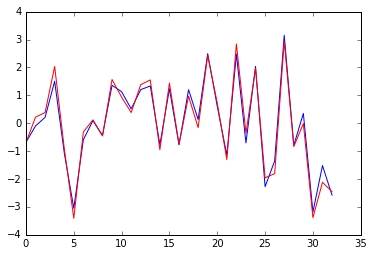

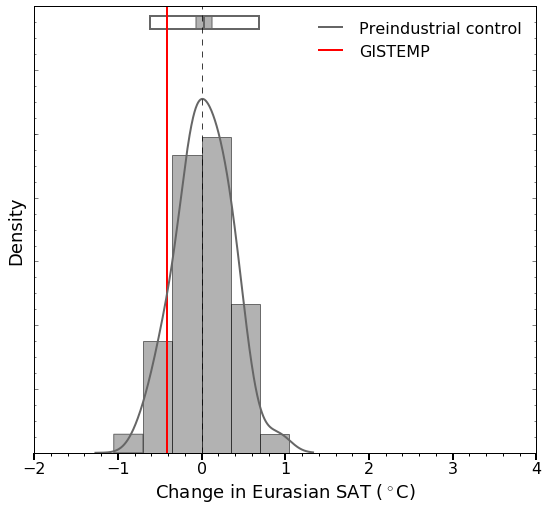

In [211]:
# @@@@@@@review
# **PAPER SUPP**

printtofile=True

print fldregdt.keys()

eursat = fldregdt['sat']['EUR'] #*100 #convs['sat'] #why scale factor ??
eursatera = fldregdt['sat2']['EUR']*convs['sat2'] #from era reanalysis

plt.figure()
plt.plot(eursat-eursat.mean())
plt.plot(eursatera-eursatera.mean(),'r')

print eursat.shape, eursatera.shape

eursatanom = eursat[-10:].mean() - eursat[:10].mean() # CHECK need to ignore last 2? NO
print eursatanom
eursatanomera = eursatera[-10:].mean() - eursatera[:10].mean() # CHECK need to ignore last 2? NO
print eursatanomera


obscol='r'
fsz=18
fontP = fm.FontProperties()
fontP.set_size(fsz-2)

     
obslg=mlines.Line2D([],[],color=obscol,linewidth=2)    

picol='0.4'
simcol=ccm.get_linecolor('paperblue')
simecol='k'
osimcol='g'

pilg=mlines.Line2D([],[],color=picol,linewidth=2) 
simlg=mlines.Line2D([],[],color=simcol,linewidth=2) 
simplg=mlines.Line2D([],[],color=simcol,linewidth=2,linestyle='--') 
simelg=mlines.Line2D([],[],color=simecol,linewidth=2) 
osimlg=mlines.Line2D([],[],color=osimcol,linewidth=2) 



binwidth=0.35
be1=np.arange(0,pianoms.min()-binwidth,-binwidth)
be2=np.arange(0,pianoms.max()+binwidth,binwidth)
binedges=np.concatenate((be1[::-1], be2))

fig,ax=plt.subplots(1,1)
fig.set_size_inches(9,8)

yytop = 1.35
boxywi = 0.02
yincr=boxywi+0.03
legloc=(0.65,0.78) 

#ax.axvline(x=eursatanomera,color='r',linewidth=2) # ERA-INT?
ax.axvline(x=eursatanom,color='r',linestyle='-',linewidth=2) # GISS

print pianom.shape
ax.hist(pianoms,bins=binedges,normed=True,color=picol,alpha=0.5)

#ax.hist(pianoms,normed=True,color=picol,alpha=0.5)
ax.plot(pixx,pipdf_fitted,color=picol,linewidth=2)

ax.plot((pimean,pimean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=picol)
ax.add_patch(mpatches.Rectangle((picif[0],yytop-boxywi),
                              picif[1]-picif[0],boxywi*2,ec=picol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((pici[0],yytop-boxywi),
                            pici[1]-pici[0],boxywi*2,ec=picol,fc=picol,linewidth=2,alpha=0.5))
ax.set_xlim((-2,4))
ax.legend((pilg,obslg),('Preindustrial control','GISTEMP'), loc='upper right',frameon=False,prop=fontP)

#lgh=lgh+(pilg,); lgstr=lgstr+('Preindustrial',)
#suff=suff+'withPI'
ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_xlabel('Change in Eurasian SAT ($^\circ$C)',fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.set_ylabel('Density',fontsize=fsz)
if printtofile:
    fig.savefig('SuppFigure_EURsat_piControl_slidingsamplehist49gray.pdf')
    fig.savefig('SuppFigure_EURsat_piControl_slidingsamplehist49gray.png',dpi=300)
    fig.savefig('SuppFigure_EURsat_piControl_slidingsamplehist49gray.eps',dpi=300)

In [212]:
import pandas as pd
import loadmodeldata as lmd

alsomask=None

field='tas'
sims=('R1','R2','R3','R4','R5')
region='eurasiamori'
styearsR = [ 8.,  7.,  2.,  8.,  8.]

simconv1=1
if field=='tas': simfield1='st'; simncfield1='ST'
elif field=='zg50000.00': simfield1='gz50000'; simncfield1='PHI'; simconv1=1/con.get_g()
elif field=='sia': simfield1='sicn'; simncfield1='SICN'; print '@@ danger, sia actually sicn average'
elif field=='sic': simfield1='sicn'; simncfield1='SICN';
else: print 'cannot addsims for ' + field;

simflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,alsomask=alsomask))*simconv1


simanoms,styears = subsamp_sims(simflddf,numyrs=11,styears=styearsR)


simpdf_fitted,simmean,simsd,simxx = cutl.calc_normfit(simanoms)
simpdf_fitted,simxx = cutl.calc_kernel(simanoms)
simdf = len(simanoms)-1
simstder = simsd / np.sqrt(simdf+1)
simci = sp.stats.t.interval(1-cisiglevel, simdf, loc=simmean, scale=simstder)
simcif = sp.stats.t.interval(1-cisiglevel, simdf, loc=simmean, scale=simsd)


simyrs = np.array(simflddf).flatten()

print 'yearly: less than zero: ' + str(simyrs[simyrs<0].shape)
print 'yearly: greater than zero: ' + str(simyrs[simyrs>0].shape)

print 'less than zero: ' + str(simanoms[simanoms<0].shape)
print 'greater than zero: ' + str(simanoms[simanoms>0].shape)


@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_st_001-121_ts.nc
lat: squeezing data upon read all
lo

/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [213]:
print '@@'
print simflddf.values.shape
print len(simflddf.values.shape)

@@
(119, 5)
2


In [214]:
# Do control and pert separatly
#    CTL
sims=('R1','R2','R3','R4','R5')

simcflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,alsomask=alsomask,
                                      filetype='ctl'))*simconv1
simcanoms,styears = subsamp_sims(simcflddf,numyrs=11,styears=styearsR)


simcpdf_fitted,simcmean,simcsd,simcxx = cutl.calc_normfit(simcanoms)
simcpdf_fitted,simcxx = cutl.calc_kernel(simcanoms)
simcdf = len(simcanoms)-1
simcstder = simcsd / np.sqrt(simcdf+1)
simcci = sp.stats.t.interval(1-cisiglevel, simcdf, loc=simcmean, scale=simcstder)
simccif = sp.stats.t.interval(1-cisiglevel, simcdf, loc=simcmean, scale=simcsd)

#    PERT
simpflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,alsomask=alsomask, 
                                      filetype='pert'))*simconv1

simpanoms,styears = subsamp_sims(simpflddf,numyrs=11,styears=styearsR)


simppdf_fitted,simpmean,simpsd,simpxx = cutl.calc_normfit(simpanoms)
simppdf_fitted,simpxx = cutl.calc_kernel(simpanoms)
simpdf = len(simpanoms)-1
simpstder = simpsd / np.sqrt(simpdf+1)
simpci = sp.stats.t.interval(1-cisiglevel, simpdf, loc=simpmean, scale=simpstder)
simpcif = sp.stats.t.interval(1-cisiglevel, simpdf, loc=simpmean, scale=simpsd)

@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_st_001-121_ts.nc
lat: squeezing data upon read all
lo

/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
KEYS: Index([u'R1', u'R2', u'R3', u'R4', u'R5'], dtype=

@@ probably should invert the order such that it is field, season, sim?
DJF
sicn SICN
R1
/HOME/rkm/work/DATA/CanAM4/kemctl1r1/ts/kemctl1r1_sicn_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R2
/HOME/rkm/work/DATA/CanAM4/kemctl1r2/ts/kemctl1r2_sicn_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R3
/HOME/rkm/work/DATA/CanAM4/kemctl1r3/ts/kemctl1r3_sicn_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R4
/HOME/rkm/work/DATA/CanAM4/kemctl1r4/ts/kemctl1r4_sicn_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
R5
/HOME/rkm/work/DATA/CanAM4/kemctl1r5/ts/kemctl1r5_sicn_001-121_ts.nc
lat: squeezing data up

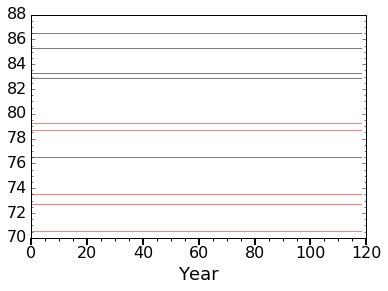

In [215]:
# plot timeseries of BKS SIC ctl and pert sims for presentation
# Do control and pert separatly
#    CTL
sims=('R1','R2','R3','R4','R5')
pltfield='sic'
pltregion='bksmori'
styearsR = [ 8.,  7.,  2.,  8.,  8.]

pltsimconv1=1
if pltfield=='tas': pltsimfield1='st'; pltsimncfield1='ST'
elif pltfield=='zg50000.00': pltsimfield1='gz50000'; pltsimncfield1='PHI'; pltsimconv1=1/con.get_g()
elif pltfield=='sia': pltsimfield1='sicn'; pltsimncfield1='SICN'; print '@@ danger, sia actually sicn average'
elif pltfield=='sic': pltsimfield1='sicn'; pltsimncfield1='SICN'; pltsimconv1=100

else: print 'cannot addsims for ' + pltfield;

simcbkssic = pd.DataFrame(lmd.loaddata((pltsimfield1,),sims,ncfields=(pltsimncfield1,), 
                                      timefreq=sea,region=pltregion,alsomask='land',
                                       filetype='ctl'))*pltsimconv1 # timefreq=sea,


#    PERT
simpbkssic = pd.DataFrame(lmd.loaddata((pltsimfield1,),sims,ncfields=(pltsimncfield1,), 
                                      timefreq=sea,region=pltregion, alsomask='land',
                                       filetype='pert'))*pltsimconv1 # timefreq=sea,





print simcbkssic.shape

printtofile=False

# plot timeseries of all BKS ice
fig,ax = plt.subplots(1,1)


ax.plot(simcbkssic, color='k',alpha=0.5)
ax.plot(simpbkssic, color='r',alpha=0.5)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.minorticks_on()
#ax.set_xticks(np.arange(1,2014-styear,10))
#ax.set_xticklabels(np.arange(styear+1,2014,10),fontsize=fsz)
#ax.set_xlim((1979-1979,2014-1979))
ax.set_xlabel('Year',fontsize=fsz)

if printtofile:
    fig.savefig('BKSSIC_Rsims_timeseries_DJF.pdf')
    


In [216]:
sims=('E1','E2','E3','E4','E5')
styearsE=[ 4.,  1.,  7.,  3.,  1.]

simeflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,alsomask=alsomask))*simconv1

simeanoms,styearse = subsamp_sims(simeflddf,numyrs=11,styears=styearsE)


simepdf_fitted,simemean,simesd,simexx = cutl.calc_normfit(simeanoms)
simepdf_fitted,simexx = cutl.calc_kernel(simeanoms)
simedf = len(simeanoms)-1
simestder = simesd / np.sqrt(simedf+1)
simeci = sp.stats.t.interval(1-cisiglevel, simedf, loc=simemean, scale=simestder)
simecif = sp.stats.t.interval(1-cisiglevel, simedf, loc=simemean, scale=simesd)

simeyrs = np.array(simeflddf).flatten()

print 'yearly: less than zero: ' + str(simeyrs[simeyrs<0].shape)
print 'yearly: greater than zero: ' + str(simeyrs[simeyrs>0].shape)

print 'less than zero: ' + str(simeanoms[simeanoms<0].shape)
print 'greater than zero: ' + str(simeanoms[simeanoms>0].shape)


@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
E1
/HOME/rkm/work/DATA/CanAM4/kemctl1/ts/kemctl1_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E2
/HOME/rkm/work/DATA/CanAM4/kemctl1e2/ts/kemctl1e2_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E3
/HOME/rkm/work/DATA/CanAM4/kemctl1e3/ts/kemctl1e3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E4
/HOME/rkm/work/DATA/CanAM4/kemctl1e4/ts/kemctl1e4_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E5
/HOME/rkm/work/DATA/CanAM4/kemctl1e5/ts/kemctl1e5_st_001-121_ts.nc
lat: squeezing data upon read all
lon: s

/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [217]:
# Do control and pert separatly
#    CTL
sims=('E1','E2','E3','E4','E5')
print simncfield1
print region
simecflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,alsomask=alsomask,
                                       filetype='ctl'))*simconv1
simecanoms,styears = subsamp_sims(simecflddf,numyrs=11,styears=styearsE)


simecpdf_fitted,simecmean,simecsd,simecxx = cutl.calc_normfit(simecanoms)
simecpdf_fitted,simecxx = cutl.calc_kernel(simecanoms)
simecdf = len(simecanoms)-1
simecstder = simecsd / np.sqrt(simecdf+1)
simecci = sp.stats.t.interval(1-cisiglevel, simecdf, loc=simecmean, scale=simecstder)
simeccif = sp.stats.t.interval(1-cisiglevel, simecdf, loc=simecmean, scale=simecsd)

#    PERT
simepflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,alsomask=alsomask, 
                                       filetype='pert'))*simconv1

simepanoms,styears = subsamp_sims(simepflddf,numyrs=11,styears=styearsE)


simeppdf_fitted,simepmean,simepsd,simepxx = cutl.calc_normfit(simepanoms)
simeppdf_fitted,simepxx = cutl.calc_kernel(simepanoms)
simepdf = len(simepanoms)-1
simepstder = simepsd / np.sqrt(simepdf+1)
simepci = sp.stats.t.interval(1-cisiglevel, simepdf, loc=simepmean, scale=simepstder)
simepcif = sp.stats.t.interval(1-cisiglevel, simepdf, loc=simepmean, scale=simepsd)

ST
eurasiamori
@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
E1
/HOME/rkm/work/DATA/CanAM4/kemctl1/ts/kemctl1_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E2
/HOME/rkm/work/DATA/CanAM4/kemctl1e2/ts/kemctl1e2_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E3
/HOME/rkm/work/DATA/CanAM4/kemctl1e3/ts/kemctl1e3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E4
/HOME/rkm/work/DATA/CanAM4/kemctl1e4/ts/kemctl1e4_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E5
/HOME/rkm/work/DATA/CanAM4/kemctl1e5/ts/kemctl1e5_st_001-121_ts.nc
lat: squeezing data upon 

/usr/local/anaconda2-2.5.0/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E2
/HOME/rkm/work/DATA/CanAM4/kemctl1e2/ts/kemctl1e2_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E3
/HOME/rkm/work/DATA/CanAM4/kemctl1e3/ts/kemctl1e3_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E4
/HOME/rkm/work/DATA/CanAM4/kemctl1e4/ts/kemctl1e4_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
E5
/HOME/rkm/work/DATA/CanAM4/kemctl1e5/ts/kemctl1e5_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
KEYS: Index([u'E1', u'E2', u'E3', u'E4', u'E5'], dtype=

k [ 0.          0.21960784  0.88627451]


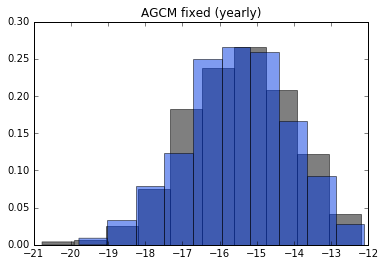

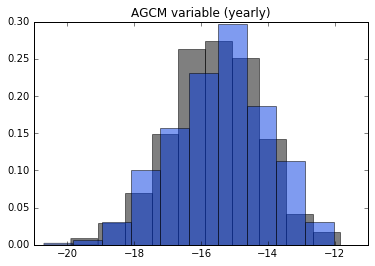

In [218]:
picol='purple'
simcol=ccm.get_linecolor('paperblue')
simecol='k'
osimcol='g'

simecflddf.shape
simecyrs = np.array(simecflddf)
simecyrs = simecyrs.flatten()
simepflddf.shape
simepyrs = np.array(simepflddf)
simepyrs = simepyrs.flatten()


print simecol, simcol
fig,ax=plt.subplots(1,1)
ax.hist(simecyrs,normed=True,color=simecol,alpha=0.5)# control is black
ax.hist(simepyrs,normed=True,color=simcol,alpha=0.5) # pert is blue
ax.set_title('AGCM fixed (yearly)')

simcflddf.shape
simcyrs = np.array(simcflddf)
simcyrs = simcyrs.flatten()
simpflddf.shape
simpyrs = np.array(simpflddf)
simpyrs = simpyrs.flatten()

fig,ax=plt.subplots(1,1)
ax.hist(simcyrs,normed=True,color=simecol,alpha=0.5)# control is black
ax.hist(simpyrs,normed=True,color=simcol,alpha=0.5) # pert is blue
ax.set_title('AGCM variable (yearly)')


@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
NSIDC
/HOME/rkm/work/DATA/CanAM4/kemnsidcctl/ts/kemnsidcctl_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
KEYS: Index([u'NSIDC'], dtype='object')
sample each of 1 sims 10 times
vals.shape (119,)
start 1.0
===== mean 0.0455207576551 sigma 0.56077570496
===== mean 0.0455207576551 sigma 0.56077570496
less than zero: (3,)
greater than zero: (7,)
yearly: less than zero: (65,)
yearly: greater than zero: (54,)
######### yearly 
skew (NSIDC anoms)
-0.0883492812192
SkewtestResult(statistic=-0.41453182111801079, pvalue=0.67848466765329041)


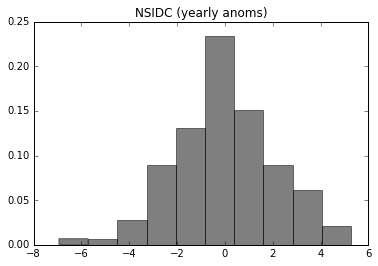

In [219]:
sims=('NSIDC',)
styearsN=[1.]
osimflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,alsomask=alsomask))*simconv1

osimanoms,styearso = subsamp_sims(osimflddf,numyrs=11,styears=styearsN)


osimpdf_fitted,osimmean,osimsd,osimxx = cutl.calc_normfit(osimanoms)
osimpdf_fitted,osimxx = cutl.calc_kernel(osimanoms)
osimdf = len(osimanoms)-1
osimstder = osimsd / np.sqrt(osimdf+1)
osimci = sp.stats.t.interval(1-cisiglevel, osimdf, loc=osimmean, scale=osimstder)
osimcif = sp.stats.t.interval(1-cisiglevel, osimdf, loc=osimmean, scale=osimsd)

print 'less than zero: ' + str(osimanoms[osimanoms<0].shape)
print 'greater than zero: ' + str(osimanoms[osimanoms>0].shape)


# yearly anoms
osimflddf.shape
osimyrs = np.array(osimflddf)
osimyrs = osimyrs.flatten()

print 'yearly: less than zero: ' + str(osimyrs[osimyrs<0].shape)
print 'yearly: greater than zero: ' + str(osimyrs[osimyrs>0].shape)

fig,ax=plt.subplots(1,1)
ax.hist(osimyrs,normed=True,color='k',alpha=0.5)# control is black
ax.set_title('NSIDC (yearly anoms)')


print '######### yearly '
print 'skew (NSIDC anoms)'
print sp.stats.skew(osimyrs)
print sp.stats.skewtest(osimyrs) # returns zscore, pval


In [220]:
# DO NSIDC CTL AND PERT SEPARATELY
#   CTL
sims=('NSIDC',)
styearsN=[1.]
osimcflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                     timefreq=sea, region=region,alsomask=alsomask,
                                       filetype='ctl'))*simconv1

osimcanoms,styearso = subsamp_sims(osimcflddf,numyrs=11,styears=styearsN)


osimcpdf_fitted,osimcmean,osimcsd,osimcxx = cutl.calc_normfit(osimcanoms)
osimcpdf_fitted,osimcxx = cutl.calc_kernel(osimcanoms)
osimcdf = len(osimcanoms)-1
osimcstder = osimcsd / np.sqrt(osimcdf+1)
osimcci = sp.stats.t.interval(1-cisiglevel, osimcdf, loc=osimcmean, scale=osimcstder)
osimccif = sp.stats.t.interval(1-cisiglevel, osimcdf, loc=osimcmean, scale=osimcsd)

#  PERT
osimpflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                        timefreq=sea, region=region,alsomask=alsomask,
                                       filetype='pert'))*simconv1

osimpanoms,styearso = subsamp_sims(osimpflddf,numyrs=11,styears=styearsN)


osimppdf_fitted,osimpmean,osimpsd,osimpxx = cutl.calc_normfit(osimpanoms)
osimppdf_fitted,osimpxx = cutl.calc_kernel(osimpanoms)
osimpdf = len(osimpanoms)-1
osimpstder = osimpsd / np.sqrt(osimpdf+1)
osimpci = sp.stats.t.interval(1-cisiglevel, osimpdf, loc=osimpmean, scale=osimpstder)
osimpcif = sp.stats.t.interval(1-cisiglevel, osimpdf, loc=osimpmean, scale=osimpsd)


@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
NSIDC
/HOME/rkm/work/DATA/CanAM4/kemnsidcctl/ts/kemnsidcctl_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
KEYS: Index([u'NSIDC'], dtype='object')
sample each of 1 sims 10 times
vals.shape (119,)
start 1.0
===== mean -15.1707399948 sigma 0.349124280174
===== mean -15.1707399948 sigma 0.349124280174
@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
NSIDC
/HOME/rkm/work/DATA/CanAM4/kemnsidcctl/ts/kemnsidcctl_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
KEYS: Index([u'NSIDC'], dtype='object')
sample each of 1 sims 10 times
vals.shape (119,)
start 1.0
===== mean -15.1252192371 sigma 0.437074689522
===== mean -15.1252192371 sigma 0.437074689522


######### yearly 
skew (NSIDC ctl)
-0.142234729514
SkewtestResult(statistic=-0.66564979776257105, pvalue=0.50563496872909997)
skew (NSIDC pert)
-0.252290876017
SkewtestResult(statistic=-1.1704198606264695, pvalue=0.24183204705249395)
==== testing NSIDC pert vs NSIDC ctl ====
TSTAT: -0.218205192827 PVAL: 0.827457801947
LSTAT: 0.443439444629 PVAL: 0.506117398055
######### subsampled 
skew (NSIDC ctl)
0.0297711365488
SkewtestResult(statistic=0.053283267496682933, pvalue=0.95750621186503526)
skew (NSIDC pert)
-0.557712674538
SkewtestResult(statistic=-0.98668285198140138, pvalue=0.32379813914482014)
==== testing NSIDC pert vs NSIDC ctl ====
TSTAT: 0.244125224234 PVAL: 0.809894788754
LSTAT: 2.35980362946e-05 PVAL: 0.996177500701


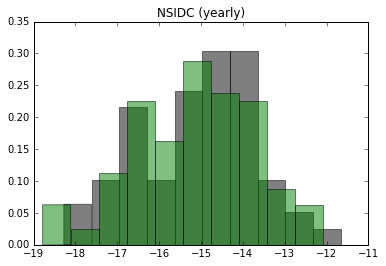

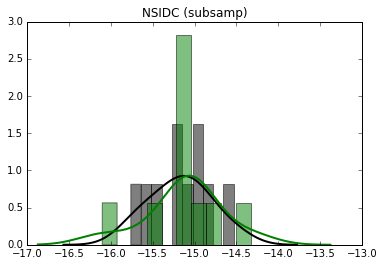

In [221]:
osimcflddf.shape
osimcyrs = np.array(osimcflddf)
osimcyrs = osimcyrs.flatten()
osimpflddf.shape
osimpyrs = np.array(osimpflddf)
osimpyrs = osimpyrs.flatten()

fig,ax=plt.subplots(1,1)
ax.hist(osimcyrs,normed=True,color='k',alpha=0.5)# control is black
ax.hist(osimpyrs,normed=True,color='g',alpha=0.5) # pert is green
ax.set_title('NSIDC (yearly)')


print '######### yearly '
print 'skew (NSIDC ctl)'
print sp.stats.skew(osimcyrs)
print sp.stats.skewtest(osimcyrs) # returns zscore, pval
print 'skew (NSIDC pert)'
print sp.stats.skew(osimpyrs)
print sp.stats.skewtest(osimpyrs) # returns zscore, pval


tstat, pval = sp.stats.ttest_ind(osimpyrs,osimcyrs)
lstat, lpval = sp.stats.levene(osimpyrs,osimcyrs)
print '==== testing NSIDC pert vs NSIDC ctl ===='
print 'TSTAT: ' + str(tstat) + ' PVAL: ' + str(pval)
if pval<=siglevel:
     print 'The ensemble means are significantly different (' + str(1-siglevel) + ')'
print 'LSTAT: ' + str(lstat) + ' PVAL: ' + str(lpval)
if lpval<=siglevel:
    print 'The ensemble variances are significantly different (' + str(1-siglevel) + ')'



fig,ax=plt.subplots(1,1)
ax.hist(osimcanoms,normed=True,color='k',alpha=0.5)
ax.hist(osimpanoms,normed=True,color='g',alpha=0.5)
ax.plot(osimcxx,osimcpdf_fitted,color='k',linewidth=2)
ax.plot(osimpxx,osimppdf_fitted,color='g',linewidth=2)
ax.set_title('NSIDC (subsamp)')


print '######### subsampled '
print 'skew (NSIDC ctl)'
print sp.stats.skew(osimcanoms)
print sp.stats.skewtest(osimcanoms) # returns zscore, pval
print 'skew (NSIDC pert)'
print sp.stats.skew(osimpanoms)
print sp.stats.skewtest(osimpanoms) # returns zscore, pval


tstat, pval = sp.stats.ttest_ind(osimpanoms,osimcanoms)
lstat, lpval = sp.stats.levene(osimpanoms,osimcanoms)
print '==== testing NSIDC pert vs NSIDC ctl ===='
print 'TSTAT: ' + str(tstat) + ' PVAL: ' + str(pval)
if pval<=siglevel:
     print 'The ensemble means are significantly different (' + str(1-siglevel) + ')'
print 'LSTAT: ' + str(lstat) + ' PVAL: ' + str(lpval)
if lpval<=siglevel:
    print 'The ensemble variances are significantly different (' + str(1-siglevel) + ')'


==== testing AGCM var vs AGCM fix ====
TSTAT: 0.647565498371 PVAL: 0.518780157482
LSTAT: 0.243251575733 PVAL: 0.622970853279


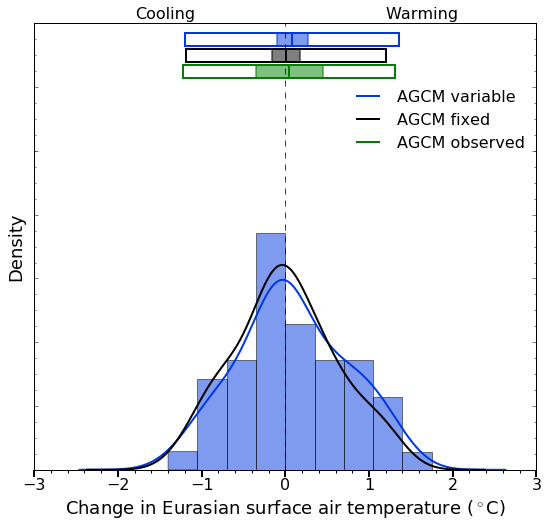

In [222]:
printtofile=False

incpi=False # include PI sim
incosim=True # obs simulation
suff='withFIX'

picol='purple'
simcol=ccm.get_linecolor('paperblue')
simecol='k'
osimcol='g'

pilg=mlines.Line2D([],[],color=picol,linewidth=2) 
simlg=mlines.Line2D([],[],color=simcol,linewidth=2) 
simplg=mlines.Line2D([],[],color=simcol,linewidth=2,linestyle='--') 
simelg=mlines.Line2D([],[],color=simecol,linewidth=2) 
osimlg=mlines.Line2D([],[],color=osimcol,linewidth=2) 

fsz=18
fontP = fm.FontProperties()
fontP.set_size(fsz-2)


binwidth=0.35
be1=np.arange(0,simanoms.min()-binwidth,-binwidth)
be2=np.arange(0,simanoms.max()+binwidth,binwidth)
binedges=np.concatenate((be1[::-1], be2))

fig,ax=plt.subplots(1,1)
fig.set_size_inches(9,8)

yytop = 1.35
boxywi = 0.02
yincr=boxywi+0.03
legloc=(0.65,0.78) 

ax.hist(simanoms,bins=binedges,normed=True,color=simcol,alpha=0.5)
ax.plot(simxx,simpdf_fitted,color=simcol,linewidth=2)

ax.plot((simmean,simmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simcol)
ax.add_patch(mpatches.Rectangle((simcif[0],yytop-boxywi),
                                simcif[1]-simcif[0],boxywi*2,ec=simcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((simci[0],yytop-boxywi),
                                simci[1]-simci[0],boxywi*2,ec=simcol,fc=simcol,linewidth=2,alpha=0.5))
lgh=(simlg,); lgstr=('AGCM variable',)


yytop-=yincr
ax.plot(simexx,simepdf_fitted,color=simecol,linewidth=2)

ax.plot((simemean,simemean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simecol)
ax.add_patch(mpatches.Rectangle((simecif[0],yytop-boxywi),
                                simecif[1]-simecif[0],boxywi*2,ec=simecol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((simeci[0],yytop-boxywi),
                                simeci[1]-simeci[0],boxywi*2,ec=simecol,fc=simecol,linewidth=2,alpha=0.5))
lgh=lgh+(simelg,); lgstr=lgstr+('AGCM fixed',)


if incpi:
    yytop-=yincr
    #ax.hist(pianoms,normed=True,color=picol,alpha=0.5)
    ax.plot(pixx,pipdf_fitted,color=picol,linewidth=2)

    ax.plot((pimean,pimean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=picol)
    ax.add_patch(mpatches.Rectangle((picif[0],yytop-boxywi),
                                picif[1]-picif[0],boxywi*2,ec=picol,fc='white',linewidth=2))
    ax.add_patch(mpatches.Rectangle((pici[0],yytop-boxywi),
                                pici[1]-pici[0],boxywi*2,ec=picol,fc=picol,linewidth=2,alpha=0.5))
    lgh=lgh+(pilg,); lgstr=lgstr+('Preindustrial',)
    suff=suff+'withPI'
    legloc=(0.65,0.7)

if incosim:
    yytop-=yincr
    #ax.plot(osimxx,osimpdf_fitted,color=osimcol,linewidth=2)

    ax.plot((osimmean,osimmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimcol)
    ax.add_patch(mpatches.Rectangle((osimcif[0],yytop-boxywi),
                                osimcif[1]-osimcif[0],boxywi*2,ec=osimcol,fc='white',linewidth=2))
    ax.add_patch(mpatches.Rectangle((osimci[0],yytop-boxywi),
                                osimci[1]-osimci[0],boxywi*2,ec=osimcol,fc=osimcol,linewidth=2,alpha=0.5))
    lgh=lgh+(osimlg,); lgstr=lgstr+('AGCM observed',)
    suff=suff+'withOBSSIM'
    legloc=(0.62,0.7)
    
ax.annotate('Cooling', xy=(0,1.02), xytext=(.2,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz-2)
ax.annotate('Warming', xy=(0,1.02), xytext=(.7,1.02),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz-2)

ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_ylim((0,1.4))
ax.set_ylabel('Density',fontsize=fsz)
ax.set_xlabel('Change in Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend(lgh,lgstr, loc=legloc,frameon=False,prop=fontP)

if printtofile:
    fig.savefig('Figure_3_' + suff + '.pdf',bbox_inches='tight')
    fig.savefig('Figure_3_' + suff + '.eps',bbox_inches='tight', format='eps',dpi=600)

    
tstat, pval = sp.stats.ttest_ind(simanoms,simeanoms)
lstat, lpval = sp.stats.levene(simanoms,simeanoms)
print '==== testing AGCM var vs AGCM fix ===='
print 'TSTAT: ' + str(tstat) + ' PVAL: ' + str(pval)
if pval<=siglevel:
     print 'The ensemble means are significantly different (' + str(1-siglevel) + ')'
print 'LSTAT: ' + str(lstat) + ' PVAL: ' + str(lpval)
if lpval<=siglevel:
    print 'The ensemble variances are significantly different (' + str(1-siglevel) + ')'


-15.5523459716 -15.5523459716
==== testing AGCM var CTL vs AGCM var PERT ====
CTL mean -15.5523459716, PERT mean -15.4666233686, DIFF 0.0857226030682
TSTAT: -0.95753552585 PVAL: 0.340653307575
LSTAT: 0.00109335912771 PVAL: 0.973689223665


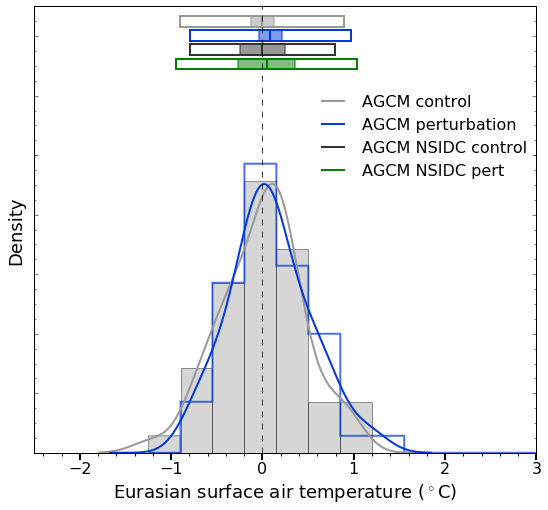

In [223]:
# CTL and PERT separately
printtofile=False

incfix=False  # include the FIXED ensemble
incosim=True # include NSIDC obs sim
subctl=True  # subtract the CTL mean from the data
suff=''

plinsty='solid'

simpcol=ccm.get_linecolor('paperblue')
simcol='0.6'
simepcol='k'
osimpcol='g'
osimcol='0.2'

simplg=mlines.Line2D([],[],color=simpcol,linewidth=2,linestyle=plinsty)
simlg=mlines.Line2D([],[],color=simcol,linewidth=2,linestyle=plinsty)

simeplg=mlines.Line2D([],[],color=simepcol,linewidth=2,linestyle='--') 

osimlg=mlines.Line2D([],[],color=osimcol,linewidth=2) 
osimplg=mlines.Line2D([],[],color=osimpcol,linewidth=2) 


binwidth=0.35
be1=np.arange(0,simcanoms.min()-binwidth,-binwidth)
be2=np.arange(0,simcanoms.max()+binwidth,binwidth)
binedges=np.concatenate((be1[::-1], be2))

submean=simcanoms.mean()
print submean, simcmean


fig,ax=plt.subplots(1,1)
fig.set_size_inches(9,8)

yytop = 1.45
boxywi = 0.018
yincr=boxywi+0.03
legloc=(0.58,0.78) 

if subctl:
    ax.hist(simcanoms-submean,bins=binedges-submean,normed=True,color=simcol,alpha=0.4)
    ax.plot(simcxx-submean,simcpdf_fitted,color=simcol,linewidth=2)

    ax.plot((simcmean-submean,simcmean-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simcol)
    ax.add_patch(mpatches.Rectangle((simccif[0]-submean,yytop-boxywi),
                                simccif[1]-simccif[0],boxywi*2,ec=simcol,fc='white',linewidth=2))
    ax.add_patch(mpatches.Rectangle((simcci[0]-submean,yytop-boxywi),
                                    simcci[1]-simcci[0],boxywi*2,ec=simcol,fc=simcol,linewidth=2,alpha=0.5))
else:
    ax.hist(simcanoms,bins=binedges,normed=True,color=simcol,alpha=0.4)
    ax.plot(simcxx,simcpdf_fitted,color=simcol,linewidth=2)

    ax.plot((simcmean,simcmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simcol)
    ax.add_patch(mpatches.Rectangle((simccif[0],yytop-boxywi),
                                simccif[1]-simccif[0],boxywi*2,ec=simcol,fc='white',linewidth=2))
    ax.add_patch(mpatches.Rectangle((simcci[0],yytop-boxywi),
                                    simcci[1]-simcci[0],boxywi*2,ec=simcol,fc=simcol,linewidth=2,alpha=0.5))
lgh=(simlg,); lgstr=('AGCM control',)


yytop-=yincr
if subctl:
    ax.hist(simpanoms-submean,bins=binedges-submean,normed=True,color=simpcol,linewidth=2,alpha=0.7,histtype='step')
    ax.plot(simpxx-submean,simppdf_fitted,color=simpcol,linewidth=2, linestyle=plinsty)

    ax.plot((simpmean-submean,simpmean-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simpcol)
    ax.add_patch(mpatches.Rectangle((simpcif[0]-submean,yytop-boxywi),
                                    simpcif[1]-simpcif[0],boxywi*2,ec=simpcol,fc='white',linewidth=2,linestyle=plinsty))
    ax.add_patch(mpatches.Rectangle((simpci[0]-submean,yytop-boxywi),
                                    simpci[1]-simpci[0],boxywi*2,ec=simpcol,fc=simpcol,linewidth=2,alpha=0.5))
else:
    ax.hist(simpanoms,bins=binedges,normed=True,color=simpcol,linewidth=2,alpha=0.7,histtype='step')
    ax.plot(simpxx,simppdf_fitted,color=simpcol,linewidth=2, linestyle=plinsty)

    ax.plot((simpmean,simpmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simpcol)
    ax.add_patch(mpatches.Rectangle((simpcif[0],yytop-boxywi),
                                    simpcif[1]-simpcif[0],boxywi*2,ec=simpcol,fc='white',linewidth=2,linestyle=plinsty))
    ax.add_patch(mpatches.Rectangle((simpci[0],yytop-boxywi),
                                    simpci[1]-simpci[0],boxywi*2,ec=simpcol,fc=simpcol,linewidth=2,alpha=0.5))
lgh=lgh+(simplg,); lgstr=lgstr+('AGCM perturbation',)

if incfix:
    yytop-=yincr

    #ax.hist(simecanoms,bins=binedges,normed=True,color=simecol,alpha=0.5)
    ax.plot(simecxx,simecpdf_fitted,color=simecol,linewidth=2)

    ax.plot((simecmean,simecmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simecol)
    ax.add_patch(mpatches.Rectangle((simeccif[0],yytop-boxywi),
                                simeccif[1]-simeccif[0],boxywi*2,ec=simecol,fc='white',linewidth=2))
    ax.add_patch(mpatches.Rectangle((simecci[0],yytop-boxywi),
                                simecci[1]-simecci[0],boxywi*2,ec=simecol,fc=simecol,linewidth=2,alpha=0.5))
    lgh=lgh+(simelg,); lgstr=lgstr+('AGCM fix control',)


    yytop-=yincr
    #ax.hist(simepanoms,bins=binedges,normed=True,color=simepcol,linewidth=2,alpha=0.5, histtype='step')
    ax.plot(simepxx,simeppdf_fitted,color=simepcol,linewidth=2, linestyle='--')

    ax.plot((simepmean,simepmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simepcol)
    ax.add_patch(mpatches.Rectangle((simepcif[0],yytop-boxywi),
                                simepcif[1]-simepcif[0],boxywi*2,ec=simepcol,fc='white',linewidth=2,linestyle='dashed'))
    ax.add_patch(mpatches.Rectangle((simepci[0],yytop-boxywi),
                                simepci[1]-simepci[0],boxywi*2,ec=simepcol,fc=simepcol,linewidth=2,alpha=0.5))
    lgh=lgh+(simeplg,); lgstr=lgstr+('AGCM fix pert',)
    legloc=(0.6,0.62) 
    suff=suff+'withFIX'

  
if incosim:
    yytop-=yincr
    #boxywi=boxywi/2. # to indicate less samples
    #ax.plot(osimxx,osimpdf_fitted,color=osimcol,linewidth=2)
    submean=osimcanoms.mean()
    if subctl:
        ax.plot((osimcmean-submean,osimcmean-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimcol)
        ax.add_patch(mpatches.Rectangle((osimccif[0]-submean,yytop-boxywi),
                                    osimccif[1]-osimccif[0],boxywi*2,ec=osimcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((osimcci[0]-submean,yytop-boxywi),
                                    osimcci[1]-osimcci[0],boxywi*2,ec=osimcol,fc=osimcol,linewidth=2,alpha=0.5))
    else:
        ax.plot((osimcmean,osimcmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimcol)
        ax.add_patch(mpatches.Rectangle((osimccif[0],yytop-boxywi),
                                    osimccif[1]-osimccif[0],boxywi*2,ec=osimcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((osimcci[0],yytop-boxywi),
                                    osimcci[1]-osimcci[0],boxywi*2,ec=osimcol,fc=osimcol,linewidth=2,alpha=0.5))
    lgh=lgh+(osimlg,); lgstr=lgstr+('AGCM NSIDC control',)
    
    yytop-=yincr
    if subctl:
        ax.plot((osimpmean-submean,osimpmean-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimpcol)
        ax.add_patch(mpatches.Rectangle((osimpcif[0]-submean,yytop-boxywi),
                                    osimpcif[1]-osimpcif[0],boxywi*2,ec=osimpcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((osimpci[0]-submean,yytop-boxywi),
                                    osimpci[1]-osimpci[0],boxywi*2,ec=osimpcol,fc=osimpcol,linewidth=2,alpha=0.5))
    else:
        ax.plot((osimpmean,osimpmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimpcol)
        ax.add_patch(mpatches.Rectangle((osimpcif[0],yytop-boxywi),
                                    osimpcif[1]-osimpcif[0],boxywi*2,ec=osimpcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((osimpci[0],yytop-boxywi),
                                    osimpci[1]-osimpci[0],boxywi*2,ec=osimpcol,fc=osimpcol,linewidth=2,alpha=0.5))
    lgh=lgh+(osimplg,); lgstr=lgstr+('AGCM NSIDC pert',)
    suff=suff+'withOBSSIM'
    legloc=(0.55,0.6)

if subctl:
    suff=suff+'subctl'
    ax.set_xlim((-2.5,3))
else:
    ax.set_xlim((-18,-13))

ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_ylim((0,1.5))
ax.set_ylabel('Density',fontsize=fsz)
ax.set_xlabel('Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend(lgh,lgstr, loc=legloc,frameon=False,prop=fontP)

if printtofile:
    fig.savefig('Figure_3_AGCMctlpert' + suff +'2.pdf',bbox_inches='tight')
    fig.savefig('Figure_3_AGCMctlpert' + suff +'2.eps',bbox_inches='tight', format='eps',dpi=600)

    
tstat, pval = sp.stats.ttest_ind(simcanoms,simpanoms)
lstat, lpval = sp.stats.levene(simcanoms,simpanoms)
print '==== testing AGCM var CTL vs AGCM var PERT ===='
print 'CTL mean ' + str(simcanoms.mean()) + ', PERT mean ' + str(simpanoms.mean()) +\
      ', DIFF ' + str(simpanoms.mean()-simcanoms.mean())
print 'TSTAT: ' + str(tstat) + ' PVAL: ' + str(pval)
if pval<=siglevel:
     print 'The ensemble means are significantly different (' + str(1-siglevel) + ')'
print 'LSTAT: ' + str(lstat) + ' PVAL: ' + str(lpval)
if lpval<=siglevel:
    print 'The ensemble variances are significantly different (' + str(1-siglevel) + ')'


bkssicanom -11.8502335043
LE inferred hist mean -0.199959372067
pval 0.00582432966673
eursatanom -0.412096786154
-1.07567345422
-15.5523459716 -15.5523459716
ksstat, kspval: 0.12 0.840948046391


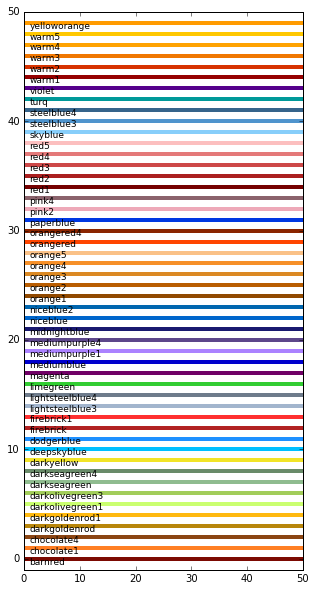

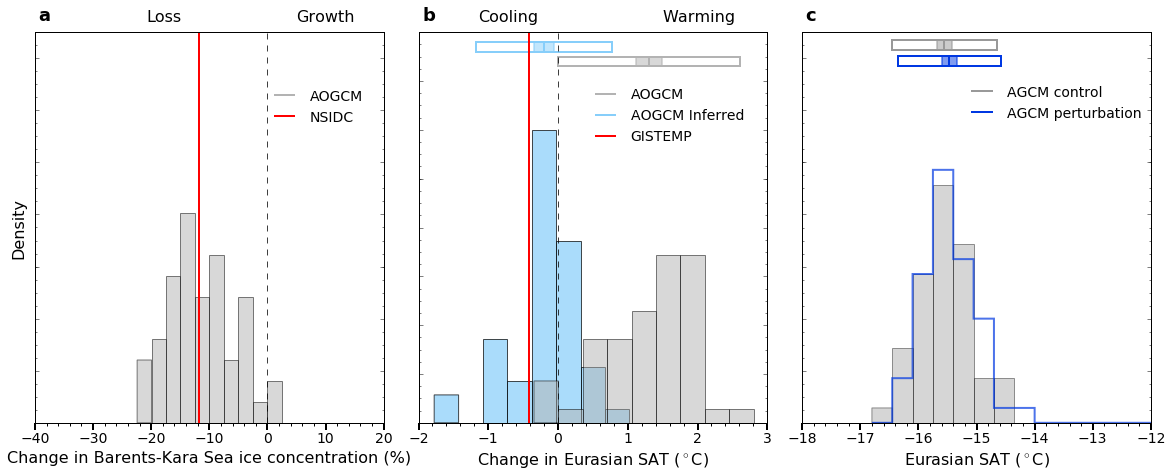

In [224]:
printtofile=True
dohoriz=True


ccm.show_linecolors()

infcol='g'
infcol=ccm.get_linecolor('skyblue') #steelblue3') #skyblue') #steelblue4')
rawcol='0.7'
obscol='r'
fsz=16
fontP = fm.FontProperties()
fontP.set_size(fsz-2)

     
obslg=mlines.Line2D([],[],color=obscol,linewidth=2)    
rawlg=mlines.Line2D([],[],color=rawcol,linewidth=2)    
inflg=mlines.Line2D([],[],color=infcol,linewidth=2) 
    
if dohoriz:
    fig,axs=plt.subplots(1,3)
    fig.set_size_inches(20,7)
    fig.subplots_adjust(wspace=.1)
else:
    fig,axs=plt.subplots(3,1)
    fig.set_size_inches(6,20)
    fig.subplots_adjust(hspace=.3)

yytop = 0.24
boxywi = 0.0032
yincr=boxywi+0.001
legloc=(0.66,0.75) 

ax=axs[0]
ax.hist(lebkssicanom,normed=True,color=rawcol,alpha=0.5)
#@@@ax.plot(rawsicxx,rawsicpdf_fitted,color='0.3',linewidth=2)

ax.axvline(x=bkssicanom,color=obscol,linewidth=2)

print 'bkssicanom ' + str(bkssicanom)

ax.plot((rawsicmean,rawsicmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=rawcol)
ax.add_patch(mpatches.Rectangle((rawsiccif[0],yytop-boxywi),
                                rawsiccif[1]-rawsiccif[0],boxywi*2,ec=rawcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((rawsicci[0],yytop-boxywi),
                                rawsicci[1]-rawsicci[0],boxywi*2,ec=rawcol,fc=rawcol,linewidth=2,alpha=0.5))

ax.annotate('Loss', xy=(0,1.04), xytext=(.32,1.04),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('Growth', xy=(0,1.04), xytext=(.75,1.04),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('a',xy=(0.01,1.03),xycoords='axes fraction',fontsize=fsz+2,fontweight='bold')
ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_ylim((0,0.15)) #0.25))
ax.set_xlim((-40,20))
ax.set_ylabel('Density',fontsize=fsz)
ax.set_xlabel('Change in Barents-Kara Sea ice concentration (%)', fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend((rawlg,obslg),('AOGCM','NSIDC'), loc=legloc,frameon=False,prop=fontP)



ax=axs[1]
yytop = 1.54
boxywi = 0.02
yincr=boxywi+0.04
legloc=(0.48,0.7) 

binwidth=0.35

# plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
print 'LE inferred hist mean ' + str(leeursatinfnonormanom.mean())
tstat,pval = sp.stats.ttest_1samp(leeursatinfnonormanom, 0)
print 'pval ' + str(pval)

ax.hist(leeursatinfnonormanom,bins=np.arange(min(leeursatinfnonormanom), 
                                             max(leeursatinfnonormanom)+binwidth, binwidth), 
        normed=True,color=infcol,alpha=0.7)
#@@@ax.plot(infxx,infpdf_fitted,color=infcol,linewidth=2)

ax.hist(leeursatanom,bins=np.arange(min(leeursatanom), 
                                    max(leeursatanom)+binwidth, binwidth),
        normed=True,color=rawcol,alpha=0.5)
#@@@ax.plot(rawxx,rawpdf_fitted,color='0.3',linewidth=2)
print 'eursatanom ' + str(eursatanom)
print eursatinfnonormanom
ax.axvline(x=eursatanom,color=obscol,linewidth=2)
#ax.axvline(x=eursatinfnonormanom,color=infcol,linewidth=2)

# uncertainty boxes
ax.plot((infmean,infmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=infcol)
ax.add_patch(mpatches.Rectangle((infcif[0],yytop-boxywi),
                                infcif[1]-infcif[0],boxywi*2,ec=infcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((infci[0],yytop-boxywi),
                                infci[1]-infci[0],boxywi*2,ec=infcol,fc=infcol,linewidth=2,alpha=0.5))

yytop-=yincr
ax.plot((rawmean,rawmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=rawcol)
ax.add_patch(mpatches.Rectangle((rawcif[0],yytop-boxywi),
                                rawcif[1]-rawcif[0],boxywi*2,ec=rawcol,fc='white',linewidth=2))
ax.add_patch(mpatches.Rectangle((rawci[0],yytop-boxywi),
                                rawci[1]-rawci[0],boxywi*2,ec=rawcol,fc=rawcol,linewidth=2,alpha=0.5))

ax.annotate('Cooling', xy=(0,1.04), xytext=(.17,1.04),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)
ax.annotate('Warming', xy=(0,1.04), xytext=(.7,1.04),xycoords='axes fraction',
            verticalalignment='center',fontsize=fsz)

#ax.set_ylabel('Density',fontsize=fsz)
ax.annotate('b',xy=(0.01,1.03),xycoords='axes fraction',fontsize=fsz+2,fontweight='bold')
ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_xlabel('Change in Eurasian SAT ($^\circ$C)',fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend((rawlg,inflg,obslg),('AOGCM','AOGCM Inferred','GISTEMP'), loc=legloc,frameon=False,prop=fontP)


# ================= AGCM PANEL

# CTL and PERT separately

incfix=False  # include the FIXED ensemble
incosim=False # include NSIDC obs sim
subctl=False  # subtract the CTL mean from the data
suff=''

plinsty='solid'

simpcol=ccm.get_linecolor('paperblue')
simcol='0.6'
simepcol='k'
osimpcol='g'
osimcol='0.2'

simplg=mlines.Line2D([],[],color=simpcol,linewidth=2,linestyle=plinsty)
simlg=mlines.Line2D([],[],color=simcol,linewidth=2,linestyle=plinsty)

simeplg=mlines.Line2D([],[],color=simepcol,linewidth=2,linestyle='--') 

osimlg=mlines.Line2D([],[],color=osimcol,linewidth=2) 
osimplg=mlines.Line2D([],[],color=osimpcol,linewidth=2) 


binwidth=0.35
be1=np.arange(0,simcanoms.min()-binwidth,-binwidth)
be2=np.arange(0,simcanoms.max()+binwidth,binwidth)
binedges=np.concatenate((be1[::-1], be2))

submean=simcanoms.mean()
print submean, simcmean

ax = axs[2]
#fig,ax=plt.subplots(1,1)
#fig.set_size_inches(9,8)

if incosim:
    yytop = 1.45
    boxywi = 0.018
    yincr=boxywi+0.03
    legloc=(0.53,0.67) 
else:
    yytop = 1.45
    boxywi = 0.02
    yincr=boxywi+0.04
    legloc=(0.46,0.76) 

# =============== test whether distributions are diff:
ksstat, kspval = sp.stats.ks_2samp(simcanoms,simpanoms)
print 'ksstat, kspval: ' + str(ksstat),str(kspval)
# ===========================

if subctl:
    ax.hist(simcanoms-submean,bins=binedges-submean,normed=True,color=simcol,alpha=0.4)
    ax.plot(simcxx-submean,simcpdf_fitted,color=simcol,linewidth=2)

    ax.plot((simcmean-submean,simcmean-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simcol)
    ax.add_patch(mpatches.Rectangle((simccif[0]-submean,yytop-boxywi),
                                simccif[1]-simccif[0],boxywi*2,ec=simcol,fc='white',linewidth=2))
    ax.add_patch(mpatches.Rectangle((simcci[0]-submean,yytop-boxywi),
                                    simcci[1]-simcci[0],boxywi*2,ec=simcol,fc=simcol,linewidth=2,alpha=0.5))
else:
    ax.hist(simcanoms,bins=binedges,normed=True,color=simcol,alpha=0.4)
    #@@@ax.plot(simcxx,simcpdf_fitted,color=simcol,linewidth=2)

    ax.plot((simcmean,simcmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simcol)
    ax.add_patch(mpatches.Rectangle((simccif[0],yytop-boxywi),
                                simccif[1]-simccif[0],boxywi*2,ec=simcol,fc='white',linewidth=2))
    ax.add_patch(mpatches.Rectangle((simcci[0],yytop-boxywi),
                                    simcci[1]-simcci[0],boxywi*2,ec=simcol,fc=simcol,linewidth=2,alpha=0.5))
lgh=(simlg,); lgstr=('AGCM control',)


yytop-=yincr
if subctl:
    ax.hist(simpanoms-submean,bins=binedges-submean,normed=True,color=simpcol,linewidth=2,alpha=0.7,histtype='step')
    ax.plot(simpxx-submean,simppdf_fitted,color=simpcol,linewidth=2, linestyle=plinsty)

    ax.plot((simpmean-submean,simpmean-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simpcol)
    ax.add_patch(mpatches.Rectangle((simpcif[0]-submean,yytop-boxywi),
                                    simpcif[1]-simpcif[0],boxywi*2,ec=simpcol,fc='white',linewidth=2,linestyle=plinsty))
    ax.add_patch(mpatches.Rectangle((simpci[0]-submean,yytop-boxywi),
                                    simpci[1]-simpci[0],boxywi*2,ec=simpcol,fc=simpcol,linewidth=2,alpha=0.5))
else:
    ax.hist(simpanoms,bins=binedges,normed=True,color=simpcol,linewidth=2,alpha=0.7,histtype='step')
    #@@@ax.plot(simpxx,simppdf_fitted,color=simpcol,linewidth=2, linestyle=plinsty)

    ax.plot((simpmean,simpmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simpcol)
    ax.add_patch(mpatches.Rectangle((simpcif[0],yytop-boxywi),
                                    simpcif[1]-simpcif[0],boxywi*2,ec=simpcol,fc='white',linewidth=2,linestyle=plinsty))
    ax.add_patch(mpatches.Rectangle((simpci[0],yytop-boxywi),
                                    simpci[1]-simpci[0],boxywi*2,ec=simpcol,fc=simpcol,linewidth=2,alpha=0.5))
lgh=lgh+(simplg,); lgstr=lgstr+('AGCM perturbation',)

if incfix:
    yytop-=yincr

    #ax.hist(simecanoms,bins=binedges,normed=True,color=simecol,alpha=0.5)
    ax.plot(simecxx,simecpdf_fitted,color=simecol,linewidth=2)

    ax.plot((simecmean,simecmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simecol)
    ax.add_patch(mpatches.Rectangle((simeccif[0],yytop-boxywi),
                                simeccif[1]-simeccif[0],boxywi*2,ec=simecol,fc='white',linewidth=2))
    ax.add_patch(mpatches.Rectangle((simecci[0],yytop-boxywi),
                                simecci[1]-simecci[0],boxywi*2,ec=simecol,fc=simecol,linewidth=2,alpha=0.5))
    lgh=lgh+(simelg,); lgstr=lgstr+('AGCM fix control',)


    yytop-=yincr
    #ax.hist(simepanoms,bins=binedges,normed=True,color=simepcol,linewidth=2,alpha=0.5, histtype='step')
    ax.plot(simepxx,simeppdf_fitted,color=simepcol,linewidth=2, linestyle='--')

    ax.plot((simepmean,simepmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simepcol)
    ax.add_patch(mpatches.Rectangle((simepcif[0],yytop-boxywi),
                                simepcif[1]-simepcif[0],boxywi*2,ec=simepcol,fc='white',linewidth=2,linestyle='dashed'))
    ax.add_patch(mpatches.Rectangle((simepci[0],yytop-boxywi),
                                simepci[1]-simepci[0],boxywi*2,ec=simepcol,fc=simepcol,linewidth=2,alpha=0.5))
    lgh=lgh+(simeplg,); lgstr=lgstr+('AGCM fix pert',)
    legloc=(0.6,0.62) 
    suff=suff+'withFIX'

  
if incosim:
    yytop-=yincr
    #boxywi=boxywi/2. # to indicate less samples
    #ax.plot(osimxx,osimpdf_fitted,color=osimcol,linewidth=2)
    submean=osimcanoms.mean()
    if subctl:
        ax.plot((osimcmean-submean,osimcmean-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimcol)
        ax.add_patch(mpatches.Rectangle((osimccif[0]-submean,yytop-boxywi),
                                    osimccif[1]-osimccif[0],boxywi*2,ec=osimcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((osimcci[0]-submean,yytop-boxywi),
                                    osimcci[1]-osimcci[0],boxywi*2,ec=osimcol,fc=osimcol,linewidth=2,alpha=0.5))
    else:
        ax.plot((osimcmean,osimcmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimcol)
        ax.add_patch(mpatches.Rectangle((osimccif[0],yytop-boxywi),
                                    osimccif[1]-osimccif[0],boxywi*2,ec=osimcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((osimcci[0],yytop-boxywi),
                                    osimcci[1]-osimcci[0],boxywi*2,ec=osimcol,fc=osimcol,linewidth=2,alpha=0.5))
    lgh=lgh+(osimlg,); lgstr=lgstr+('AGCM NSIDC control',)
    
    yytop-=yincr
    if subctl:
        ax.plot((osimpmean-submean,osimpmean-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimpcol)
        ax.add_patch(mpatches.Rectangle((osimpcif[0]-submean,yytop-boxywi),
                                    osimpcif[1]-osimpcif[0],boxywi*2,ec=osimpcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((osimpci[0]-submean,yytop-boxywi),
                                    osimpci[1]-osimpci[0],boxywi*2,ec=osimpcol,fc=osimpcol,linewidth=2,alpha=0.5))
    else:
        ax.plot((osimpmean,osimpmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=osimpcol)
        ax.add_patch(mpatches.Rectangle((osimpcif[0],yytop-boxywi),
                                    osimpcif[1]-osimpcif[0],boxywi*2,ec=osimpcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((osimpci[0],yytop-boxywi),
                                    osimpci[1]-osimpci[0],boxywi*2,ec=osimpcol,fc=osimpcol,linewidth=2,alpha=0.5))
    lgh=lgh+(osimplg,); lgstr=lgstr+('AGCM NSIDC pert',)
    suff=suff+'withOBSSIM'
    if dohoriz:
        legloc=(0.4,0.62)
    else:
        legloc=(0.44,0.53)

if subctl:
    suff=suff+'subctl'
    ax.set_xlim((-2.5,4))
else:
    ax.set_xlim((-18,-12))

ax.annotate('c',xy=(0.01,1.03),xycoords='axes fraction',fontsize=fsz+2,fontweight='bold')
ax.axvline(x=0,linewidth=0.75, linestyle='--', color='k')
ax.set_ylim((0,1.5))
#ax.set_ylabel('Density',fontsize=fsz)
ax.set_xlabel('Eurasian SAT ($^\circ$C)', fontsize=fsz)
ax.xaxis.set_ticks_position('bottom')
ax.minorticks_on()
ax.xaxis.set_tick_params(direction='out',which='both')
ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
ax.tick_params('x', length=3, width=1, which='minor')
ax.set_yticklabels('')
ax.legend(lgh,lgstr, loc=legloc,frameon=False,prop=fontP)


if printtofile:
    if dohoriz:
        fig.savefig('Figure_23_inferred2d_horiz3nocurve.pdf',bbox_inches='tight')
        fig.savefig('Figure_23_inferred2d_horiz3nocurve.eps',bbox_inches='tight', format='eps',dpi=600)
    else:
        fig.savefig('Figure_23_inferred2d3nocurve.pdf',bbox_inches='tight')
        fig.savefig('Figure_23_inferred2d3nocurve.eps',bbox_inches='tight', format='eps',dpi=600)
    
 

In [225]:
be1=np.arange(0,simanoms.min()-binwidth,-binwidth)
be2=np.arange(0,simanoms.max()+binwidth,binwidth)
binedges=np.concatenate((be1[::-1],be2))

print simanoms.min(), simanoms.max()
print binedges

-1.27225768979 1.40472225408
[-1.4  -1.05 -0.7  -0.35  0.    0.    0.35  0.7   1.05  1.4   1.75]


In [226]:
print 'skew (PI)'
print sp.stats.skew(pianoms)
print sp.stats.skewtest(pianoms) # returns zscore, pval
print 'skew (AGCM)'
print sp.stats.skew(simanoms)
print sp.stats.skewtest(simanoms) # returns zscore, pval


tstat, pval = sp.stats.ttest_ind(pianoms,simanoms)
lstat, lpval = sp.stats.levene(pianoms,simanoms)
print '==== testing PI vs AGCM_var ===='
print 'TSTAT: ' + str(tstat) + ' PVAL: ' + str(pval)
if pval<=siglevel:
     print 'The ensemble means are significantly different (' + str(1-siglevel) + ')'
print 'LSTAT: ' + str(lstat) + ' PVAL: ' + str(lpval)
if lpval<=siglevel:
    print 'The ensemble variances are significantly different (' + str(1-siglevel) + ')'



skew (PI)
0.0831266100425
SkewtestResult(statistic=0.26501511559416879, pvalue=0.79099781746491526)
skew (AGCM)
0.0694029022941
SkewtestResult(statistic=0.22320995421235545, pvalue=0.8233721050297087)
==== testing PI vs AGCM_var ====
TSTAT: -0.526278205729 PVAL: 0.599896205504
LSTAT: 15.3684392082 PVAL: 0.000164934736897
The ensemble variances are significantly different (0.95)


In [227]:
def compute_diststats(input, cisiglevel=0.05):
    """ returns
           pdf_fitted, xx, inmean, ci, cif
    """
    pdf_fitted,inmean,sd,xx = cutl.calc_normfit(input)
    pdf_fitted,xx = cutl.calc_kernel(input)
    dof = len(input)-1
    stder = sd / np.sqrt(dof+1)
    ci = sp.stats.t.interval(1-cisiglevel, dof, loc=inmean, scale=stder)
    cif = sp.stats.t.interval(1-cisiglevel, dof, loc=inmean, scale=sd)

    return pdf_fitted, xx, inmean, ci, cif

In [228]:
# ############# produce CTL / PERT pdfs for each simulation separately
#    make the fig as the boundary condition figure: 2x3

# loop through each sim to load:
# Do control and pert separatly
#    CTL
simsary=('NSIDC','R1','R2','R3','R4','R5')
styearsary = [ 1., 8.,  7.,  2.,  8.,  8.]

simcyrvals={}; simpyrvals={}
simcanomsdt={}; simpanomsdt={}
simcpdf_fitted={}; simppdf_fitted={}
simcmeandt={}; simpmeandt={}
simcxx={}; simpxx={}
simcci={}; simpci={}
simccif={}; simpcif={}
for sii,sim in enumerate(simsary):
    styears={}
    sims = (sim,)
    print sims
    
    styear = styearsary[sii]
    styears[0] = styear
    simcflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                         timefreq=sea, region=region,alsomask=alsomask,
                                          filetype='ctl'))*simconv1
    simcyrvals[sim]= simcflddf.values
    simcanomsdt[sim],_ = subsamp_sims(simcflddf,numyrs=11,styears=styears)


    simcpdf_fitted[sim],simcmeandt[sim],simcsd,simcxx[sim] = cutl.calc_normfit(simcanomsdt[sim])
    simcpdf_fitted[sim],simcxx[sim] = cutl.calc_kernel(simcanomsdt[sim])
    simcdf = len(simcanomsdt[sim])-1
    simcstder = simcsd / np.sqrt(simcdf+1)
    simcci[sim] = sp.stats.t.interval(1-cisiglevel, simcdf, loc=simcmeandt[sim], scale=simcstder)
    simccif[sim] = sp.stats.t.interval(1-cisiglevel, simcdf, loc=simcmeandt[sim], scale=simcsd)

    #    PERT
    simpflddf = pd.DataFrame(lmd.loaddata((simfield1,),sims,ncfields=(simncfield1,), 
                                         timefreq=sea, region=region,alsomask=alsomask, 
                                          filetype='pert'))*simconv1
    simpyrvals[sim]= simpflddf.values
    simpanomsdt[sim],_ = subsamp_sims(simpflddf,numyrs=11,styears=styears)


    simppdf_fitted[sim],simpmeandt[sim],simpsd,simpxx[sim] = cutl.calc_normfit(simpanomsdt[sim])
    simppdf_fitted[sim],simpxx[sim] = cutl.calc_kernel(simpanomsdt[sim])
    simpdf = len(simpanomsdt[sim])-1
    simpstder = simpsd / np.sqrt(simpdf+1)
    simpci[sim] = sp.stats.t.interval(1-cisiglevel, simpdf, loc=simpmeandt[sim], scale=simpstder)
    simpcif[sim] = sp.stats.t.interval(1-cisiglevel, simpdf, loc=simpmeandt[sim], scale=simpsd)
    
    

('NSIDC',)
@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
NSIDC
/HOME/rkm/work/DATA/CanAM4/kemnsidcctl/ts/kemnsidcctl_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
KEYS: Index([u'NSIDC'], dtype='object')
sample each of 1 sims 10 times
vals.shape (119,)
start 1.0
===== mean -15.1707399948 sigma 0.349124280174
===== mean -15.1707399948 sigma 0.349124280174
@@ probably should invert the order such that it is field, season, sim?
DJF
st ST
NSIDC
/HOME/rkm/work/DATA/CanAM4/kemnsidcctl/ts/kemnsidcctl_st_001-121_ts.nc
lat: squeezing data upon read all
lon: squeezing data upon read all
calc_regmean() removing extra lon. fld new shape: (119, 64, 128)
KEYS: Index([u'NSIDC'], dtype='object')
sample each of 1 sims 10 times
vals.shape (119,)
start 1.0
===== mean -15.1252192371 sigma 0.437074689522
===== mean -15.1252192371 sigma 0.437074689522
('R1',)
@@ probably

-15.1707399948 -15.1707399948
NSIDC ==== testing PERT vs CTL ====
CTL mean -15.1707399948, PERT mean -15.1252192371, DIFF 0.0455207576551
TSTAT: 0.244125224234 PVAL: 0.809894788754
LSTAT: 2.35980362946e-05 PVAL: 0.996177500701
-15.495757442 -15.495757442
R1 ==== testing PERT vs CTL ====
CTL mean -15.495757442, PERT mean -15.4155722009, DIFF 0.0801852411507
TSTAT: 0.349108045852 PVAL: 0.731058842605
LSTAT: 0.00171234878469 PVAL: 0.967448081476
-15.6026135427 -15.6026135427
R2 ==== testing PERT vs CTL ====
CTL mean -15.6026135427, PERT mean -15.7825694851, DIFF -0.179955942446
TSTAT: -0.975127583357 PVAL: 0.342420725013
LSTAT: 0.225948715501 PVAL: 0.640261393878
-15.4516919824 -15.4516919824
R3 ==== testing PERT vs CTL ====
CTL mean -15.4516919824, PERT mean -15.4634693501, DIFF -0.0117773677658
TSTAT: -0.0629958551869 PVAL: 0.950464088408
LSTAT: 0.0859032790212 PVAL: 0.772803515636
-15.6802595494 -15.6802595494
R4 ==== testing PERT vs CTL ====
CTL mean -15.6802595494, PERT mean -15.3848

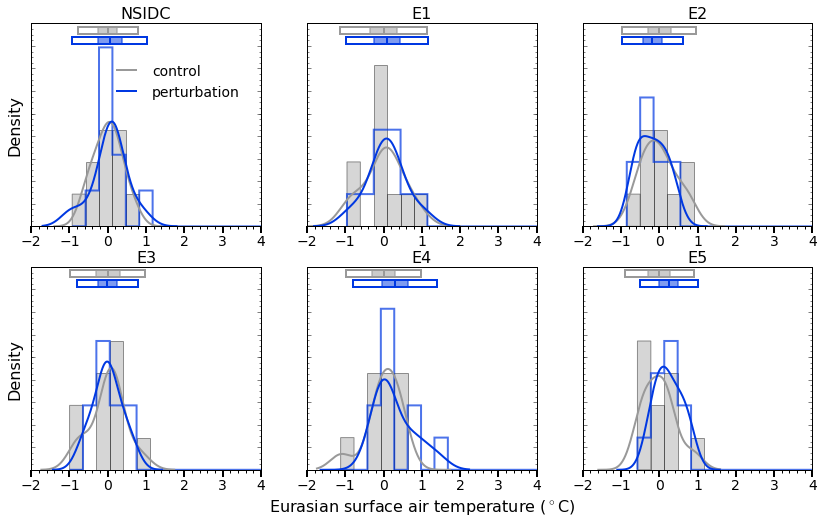

In [229]:
# CTL and PERT separately, subplot of all 6
printtofile=False


subctl=True  # subtract the CTL mean from the data
suff=''

plinsty='solid'

simpcol=ccm.get_linecolor('paperblue')
simcol='0.6'
simepcol='k'
osimpcol='g'
osimcol='0.2'

simplg=mlines.Line2D([],[],color=simpcol,linewidth=2,linestyle=plinsty)
simlg=mlines.Line2D([],[],color=simcol,linewidth=2,linestyle=plinsty)

simeplg=mlines.Line2D([],[],color=simepcol,linewidth=2,linestyle='--') 

osimlg=mlines.Line2D([],[],color=osimcol,linewidth=2) 
osimplg=mlines.Line2D([],[],color=osimpcol,linewidth=2) 



fig,axs=plt.subplots(2,3)
fig.set_size_inches(14,8)

legloc=(0.33,0.6) 


for sii,sim in enumerate(simsary):
    yytop = 1.74
    boxywi = 0.03
    yincr=boxywi+0.06
    
    ax=axs.flatten()[sii]
    
    simcanomspl=simcanomsdt[sim]
    simcmeanpl=simcmeandt[sim]
    simcxxpl=simcxx[sim]
    simcpdf_fittedpl = simcpdf_fitted[sim]
    simccifpl = simccif[sim]
    simccipl = simcci[sim]
    
    simpanomspl=simpanomsdt[sim]
    simpmeanpl=simpmeandt[sim]
    simpxxpl=simpxx[sim]
    simppdf_fittedpl = simppdf_fitted[sim]
    simpcifpl = simpcif[sim]
    simpcipl = simpci[sim]
    
    binwidth=0.35
    be1=np.arange(0,simcanomspl.min()-binwidth,-binwidth)
    be2=np.arange(0,simcanomspl.max()+binwidth,binwidth)
    binedges=np.concatenate((be1[::-1], be2))

    submean=simcanomspl.mean()
    print submean, simcmeanpl

    
    if subctl:
        ax.hist(simcanomspl-submean,bins=binedges-submean,normed=True,color=simcol,alpha=0.4)
        ax.plot(simcxxpl-submean,simcpdf_fittedpl,color=simcol,linewidth=2)

        ax.plot((simcmeanpl-submean,simcmeanpl-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simcol)
        ax.add_patch(mpatches.Rectangle((simccifpl[0]-submean,yytop-boxywi),
                                    simccifpl[1]-simccifpl[0],boxywi*2,ec=simcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((simccipl[0]-submean,yytop-boxywi),
                                        simccipl[1]-simccipl[0],boxywi*2,ec=simcol,fc=simcol,linewidth=2,alpha=0.5))
    #else:
    #    ax.hist(simcanoms,bins=binedges,normed=True,color=simcol,alpha=0.4)
    #    ax.plot(simcxx,simcpdf_fitted,color=simcol,linewidth=2)

    #    ax.plot((simcmean,simcmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simcol)
    #    ax.add_patch(mpatches.Rectangle((simccif[0],yytop-boxywi),
    #                                simccif[1]-simccif[0],boxywi*2,ec=simcol,fc='white',linewidth=2))
    #    ax.add_patch(mpatches.Rectangle((simcci[0],yytop-boxywi),
    #                                    simcci[1]-simcci[0],boxywi*2,ec=simcol,fc=simcol,linewidth=2,alpha=0.5))
    lgh=(simlg,); lgstr=('control',)


    yytop-=yincr
    if subctl:
        ax.hist(simpanomspl-submean,bins=binedges-submean,normed=True,color=simpcol,linewidth=2,alpha=0.7,histtype='step')
        ax.plot(simpxxpl-submean,simppdf_fittedpl,color=simpcol,linewidth=2, linestyle=plinsty)

        ax.plot((simpmeanpl-submean,simpmeanpl-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simpcol)
        ax.add_patch(mpatches.Rectangle((simpcifpl[0]-submean,yytop-boxywi),
                                        simpcifpl[1]-simpcifpl[0],boxywi*2,ec=simpcol,fc='white',linewidth=2,linestyle=plinsty))
        ax.add_patch(mpatches.Rectangle((simpcipl[0]-submean,yytop-boxywi),
                                    simpcipl[1]-simpcipl[0],boxywi*2,ec=simpcol,fc=simpcol,linewidth=2,alpha=0.5))
    #else:
    #    ax.hist(simpanoms,bins=binedges,normed=True,color=simpcol,linewidth=2,alpha=0.7,histtype='step')
    #    ax.plot(simpxx,simppdf_fitted,color=simpcol,linewidth=2, linestyle=plinsty)#

    #    ax.plot((simpmean,simpmean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simpcol)
    #    ax.add_patch(mpatches.Rectangle((simpcif[0],yytop-boxywi),
    #                                    simpcif[1]-simpcif[0],boxywi*2,ec=simpcol,fc='white',linewidth=2,linestyle=plinsty))
    #    ax.add_patch(mpatches.Rectangle((simpci[0],yytop-boxywi),
    #                                    simpci[1]-simpci[0],boxywi*2,ec=simpcol,fc=simpcol,linewidth=2,alpha=0.5))
    lgh=lgh+(simplg,); lgstr=lgstr+('perturbation',)
    
    ax.set_xlim((-2,4))
    ax.set_ylim((0,1.8))
    if ax.is_first_col():
        ax.set_ylabel('Density',fontsize=fsz)
    if ax.is_last_row() and not ax.is_first_col() and not ax.is_last_col():
        ax.set_xlabel('Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
    if sii==0:
        ax.set_title(sim,fontsize=fsz)
    else:
        ax.set_title('E'+str(sii),fontsize=fsz)
    ax.xaxis.set_ticks_position('bottom')
    ax.minorticks_on()
    ax.xaxis.set_tick_params(direction='out',which='both')
    ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
    ax.tick_params('x', length=3, width=1, which='minor')
    ax.set_yticklabels('')
    if ax.is_first_col() and ax.is_first_row():
        ax.legend(lgh,lgstr, loc=legloc,frameon=False,prop=fontP)
        
    tstat, pval = sp.stats.ttest_ind(simpanomspl,simcanomspl)
    lstat, lpval = sp.stats.levene(simpanomspl,simcanomspl)
    print sim + ' ==== testing PERT vs CTL ===='
    print 'CTL mean ' + str(simcanomspl.mean()) + ', PERT mean ' + str(simpanomspl.mean()) +\
          ', DIFF ' + str(simpanomspl.mean()-simcanomspl.mean())
    print 'TSTAT: ' + str(tstat) + ' PVAL: ' + str(pval)
    if pval<=siglevel:
         print 'The ensemble means are significantly different (' + str(1-siglevel) + ')'
    print 'LSTAT: ' + str(lstat) + ' PVAL: ' + str(lpval)
    if lpval<=siglevel:
        print 'The ensemble variances are significantly different (' + str(1-siglevel) + ')'

        
if printtofile:
    fig.savefig('SuppFigure_3_AGCMctlpert_subplots.pdf',bbox_inches='tight')
    fig.savefig('SuppFigure_3_AGCMctlpert_subplots.eps',bbox_inches='tight', format='eps',dpi=600)


===== mean -15.1206356679 sigma 1.37673939292
===== mean -15.1206356679 sigma 1.37673939292
===== mean -15.1610571088 sigma 1.4675988668
===== mean -15.1610571088 sigma 1.4675988668
-15.1206356679 -15.1206356679
NSIDC ==== YEARLY: testing PERT vs CTL ====
TSTAT: -0.218205192827 PVAL: 0.827457801947
LSTAT: 0.443439444629 PVAL: 0.506117398055
===== mean -15.5093616073 sigma 1.31747876297
===== mean -15.5093616073 sigma 1.31747876297
===== mean -15.3872117767 sigma 1.35324870901
===== mean -15.3872117767 sigma 1.35324870901
-15.5093616073 -15.5093616073
R1 ==== YEARLY: testing PERT vs CTL ====
TSTAT: 0.702555030955 PVAL: 0.483025479271
LSTAT: 0.0570198670409 PVAL: 0.811476943684
===== mean -15.6293812119 sigma 1.1962136094
===== mean -15.6293812119 sigma 1.1962136094
===== mean -15.7342292324 sigma 1.58793359579
===== mean -15.7342292324 sigma 1.58793359579
-15.6293812119 -15.6293812119
R2 ==== YEARLY: testing PERT vs CTL ====
TSTAT: -0.572885053503 PVAL: 0.567267937259
LSTAT: 8.044439021

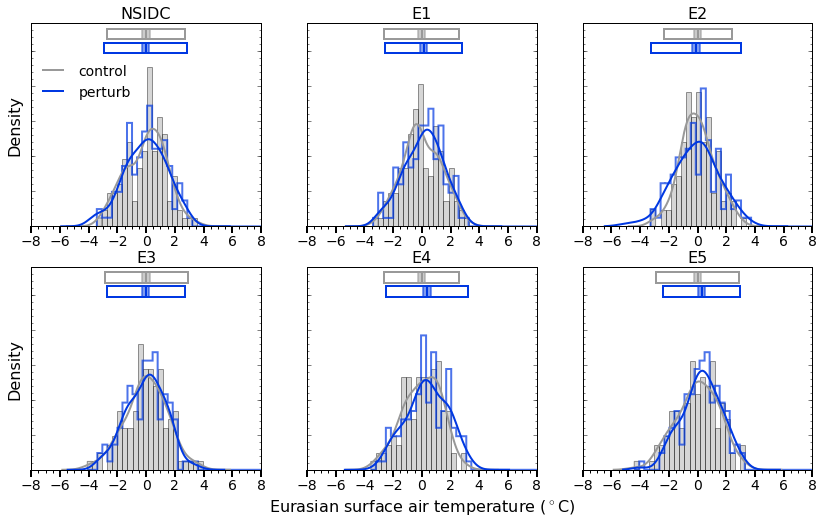

In [230]:

# CTL and PERT separately, subplot of all 6
printtofile=False


subctl=True  # subtract the CTL mean from the data
suff=''

plinsty='solid'

simpcol=ccm.get_linecolor('paperblue')
simcol='0.6'
simepcol='k'
osimpcol='g'
osimcol='0.2'

simplg=mlines.Line2D([],[],color=simpcol,linewidth=2,linestyle=plinsty)
simlg=mlines.Line2D([],[],color=simcol,linewidth=2,linestyle=plinsty)

simeplg=mlines.Line2D([],[],color=simepcol,linewidth=2,linestyle='--') 

osimlg=mlines.Line2D([],[],color=osimcol,linewidth=2) 
osimplg=mlines.Line2D([],[],color=osimpcol,linewidth=2) 



fig,axs=plt.subplots(2,3)
fig.set_size_inches(14,8)

legloc=(0.01,0.6) 


for sii,sim in enumerate(simsary):
    yytop = 0.55
    boxywi = 0.015
    yincr=boxywi+0.025
    
    ax=axs.flatten()[sii]
    
    simcanomspl = np.squeeze(simcyrvals[sim])    
    simcpdf_fittedpl, simcxxpl, simcmeanpl, simccipl, simccifpl = compute_diststats(simcanomspl)

    simpanomspl = np.squeeze(simpyrvals[sim])
    simppdf_fittedpl, simpxxpl, simpmeanpl, simpcipl, simpcifpl = compute_diststats(simpanomspl)
    
    
    binwidth=0.35
    be1=np.arange(0,simcanomspl.min()-binwidth,-binwidth)
    be2=np.arange(0,simcanomspl.max()+binwidth,binwidth)
    binedges=np.concatenate((be1[::-1], be2))

    submean=simcanomspl.mean()
    print submean, simcmeanpl

    
    if subctl:
        ax.hist(simcanomspl-submean,bins=binedges-submean,normed=True,color=simcol,alpha=0.4)
        ax.plot(simcxxpl-submean,simcpdf_fittedpl,color=simcol,linewidth=2)

        ax.plot((simcmeanpl-submean,simcmeanpl-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simcol)
        ax.add_patch(mpatches.Rectangle((simccifpl[0]-submean,yytop-boxywi),
                                    simccifpl[1]-simccifpl[0],boxywi*2,ec=simcol,fc='white',linewidth=2))
        ax.add_patch(mpatches.Rectangle((simccipl[0]-submean,yytop-boxywi),
                                        simccipl[1]-simccipl[0],boxywi*2,ec=simcol,fc=simcol,linewidth=2,alpha=0.5))
    lgh=(simlg,); lgstr=('control',)


    yytop-=yincr
    if subctl:
        ax.hist(simpanomspl-submean,bins=binedges-submean,normed=True,color=simpcol,linewidth=2,alpha=0.7,histtype='step')
        ax.plot(simpxxpl-submean,simppdf_fittedpl,color=simpcol,linewidth=2, linestyle=plinsty)

        ax.plot((simpmeanpl-submean,simpmeanpl-submean),(yytop-boxywi,yytop+boxywi),linewidth=2,color=simpcol)
        ax.add_patch(mpatches.Rectangle((simpcifpl[0]-submean,yytop-boxywi),
                                        simpcifpl[1]-simpcifpl[0],boxywi*2,ec=simpcol,fc='white',linewidth=2,linestyle=plinsty))
        ax.add_patch(mpatches.Rectangle((simpcipl[0]-submean,yytop-boxywi),
                                    simpcipl[1]-simpcipl[0],boxywi*2,ec=simpcol,fc=simpcol,linewidth=2,alpha=0.5))
    lgh=lgh+(simplg,); lgstr=lgstr+('perturb',)
    
    ax.set_xlim((-8,8))
    ax.set_ylim((0,0.58))
    if ax.is_first_col():
        ax.set_ylabel('Density',fontsize=fsz)
    if ax.is_last_row() and not ax.is_first_col() and not ax.is_last_col():
        ax.set_xlabel('Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
    if sii==0:
        ax.set_title(sim,fontsize=fsz)
    else:
        ax.set_title('E'+str(sii),fontsize=fsz)
    ax.xaxis.set_ticks_position('bottom')
    ax.minorticks_on()
    ax.xaxis.set_tick_params(direction='out',which='both')
    ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
    ax.tick_params('x', length=3, width=1, which='minor')
    ax.set_yticklabels('')
    if ax.is_first_col() and ax.is_first_row():
        ax.legend(lgh,lgstr, loc=legloc,frameon=False,prop=fontP)
        
    tstat, pval = sp.stats.ttest_ind(simpanomspl,simcanomspl)
    lstat, lpval = sp.stats.levene(simpanomspl,simcanomspl)
    print sim + ' ==== YEARLY: testing PERT vs CTL ===='
    print 'TSTAT: ' + str(tstat) + ' PVAL: ' + str(pval)
    if pval<=siglevel:
         print 'The ensemble means are significantly different (' + str(1-siglevel) + ')'
    print 'LSTAT: ' + str(lstat) + ' PVAL: ' + str(lpval)
    if lpval<=siglevel:
        print 'The ensemble variances are significantly different (' + str(1-siglevel) + ')'

        
if printtofile:
    fig.savefig('SuppFigure_3_AGCMctlpertYRLY_subplots.pdf',bbox_inches='tight')
    fig.savefig('SuppFigure_3_AGCMctlpertYRLY_subplots.eps',bbox_inches='tight', format='eps',dpi=600)
